## Comp2-1 量表类型数据

主要适配于临床数据的建模和刻画。典型的应用场景探究rad_score最终临床诊断的作用。

## Onekey步骤

1. 数据校验，检查数据格式是否正确。
3. 查看一些统计信息，检查数据时候存在异常点。
4. 正则化，将数据变化到服从 N~(0, 1)。
5. 通过相关系数，例如spearman、person等筛选出特征。
6. 构建训练集和测试集，这里使用的是随机划分，正常多中心验证，需要大家根据自己的场景构建两份数据。
7. 通过Lasso筛选特征，选取其中的非0项作为后续模型的特征。
8. 使用机器学习算法，例如LR、SVM、RF等进行任务学习。
9. 模型结果可视化，例如AUC、ROC曲线，混淆矩阵等。


# 筛选临床特征

需要根据自己的情况，筛选特征，一般情况筛选pvalue<0.05的。

In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
from onekey_algo import OnekeyDS as okds
from onekey_algo import get_param_in_cwd
import onekey_algo.custom.components as okcomp
from onekey_algo.custom.components.comp1 import fillna
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300

## 一、数据校验
首先需要检查诊断数据，如果显示`检查通过！`择可以正常运行之后的，否则请根据提示调整数据。

数据文件中的数据都是数值类型，或者可以映射成数值类型，这里的`label`某些情况下可能是非数值的，需要自定义数值函数。

**注意：在使用树模型时，可以存在缺失，但是线性模型不允许缺失，请自行根据需要填充缺省值**

In [2]:
# 读取数据
data_file = r'data/clinical.csv'
labels = [get_param_in_cwd('task_column')]
featrues_not_use = ['ID']

structed_data = pd.read_csv(data_file, header=0)
structed_data

ID  Gender  age  Enhancement_pattern_  Enhancement_degree_  \
0      1.nii.gz       1   42                     0                    1   
1      2.nii.gz       2   62                     0                    2   
2      3.nii.gz       1   55                     0                    1   
3      4.nii.gz       1   51                     0                    2   
4      5.nii.gz       2   56                     0                    1   
..          ...     ...  ...                   ...                  ...   
335  453.nii.gz       1   63                     0                    2   
336  454.nii.gz       1   42                     1                    2   
337  455.nii.gz       2   51                     1                    1   
338  457.nii.gz       2   60                     0                    1   
339  458.nii.gz       1   52                     1                    2   

     Contour  necrotic  Lymphadenopathy  Pleural_invasion  \
0          1         0                0                 0   
1          2         1                0                 0   
2          1         1                1                 0   
3          0         0                0                 0   
4          2         0                1                 1   
..       ...       ...              ...               ...   
335        1         0                0                 0   
336        1         1                0                 0   
337        1         0                1                 0   
338        0         0                0                 0   
339        1         1                0                 1   

     Great_vessel_invasion  Calcification  group  label  
0                        0              1    val      1  
1                        1              0    val      1  
2                        0              0  train      1  
3                        0              0    val      1  
4                        1              0    val      1  
..                     ...            ...    ...    ...  
335                      0              0  test2      0  
336                      0              0  test2      0  
337                      0              1  test2      0  
338                      1              0  test2      1  
339                      1              0  test2      1  

[340 rows x 13 columns]

### 特征维度

In [3]:
# 删掉ID这一列。
ids = structed_data['ID']
structed_data = structed_data.drop(featrues_not_use, axis=1)
structed_data

Gender  age  Enhancement_pattern_  Enhancement_degree_  Contour  \
0         1   42                     0                    1        1   
1         2   62                     0                    2        2   
2         1   55                     0                    1        1   
3         1   51                     0                    2        0   
4         2   56                     0                    1        2   
..      ...  ...                   ...                  ...      ...   
335       1   63                     0                    2        1   
336       1   42                     1                    2        1   
337       2   51                     1                    1        1   
338       2   60                     0                    1        0   
339       1   52                     1                    2        1   

     necrotic  Lymphadenopathy  Pleural_invasion  Great_vessel_invasion  \
0           0                0                 0                      0   
1           1                0                 0                      1   
2           1                1                 0                      0   
3           0                0                 0                      0   
4           0                1                 1                      1   
..        ...              ...               ...                    ...   
335         0                0                 0                      0   
336         1                0                 0                      0   
337         0                1                 0                      0   
338         0                0                 0                      1   
339         1                0                 1                      1   

     Calcification  group  label  
0                1    val      1  
1                0    val      1  
2                0  train      1  
3                0    val      1  
4                0    val      1  
..             ...    ...    ...  
335              0  test2      0  
336              0  test2      0  
337              1  test2      0  
338              0  test2      1  
339              0  test2      1  

[340 rows x 12 columns]

## 二、数据统计

1. count，统计样本个数。
2. mean、std, 对应特征的均值、方差
3. min, 25%, 50%, 75%, max，对应特征的最小值，25,50,75分位数，最大值。

In [4]:
structed_data.describe()

Gender      age  Enhancement_pattern_  Enhancement_degree_  Contour  \
count  340.000  340.000               340.000              340.000  340.000   
mean     1.409   55.174                 0.674                1.062    1.162   
std      0.492   11.039                 0.470                0.764    0.879   
min      1.000   21.000                 0.000                0.000    0.000   
25%      1.000   48.000                 0.000                0.000    0.000   
50%      1.000   56.000                 1.000                1.000    1.000   
75%      2.000   62.000                 1.000                2.000    2.000   
max      2.000   80.000                 1.000                2.000    2.000   

       necrotic  Lymphadenopathy  Pleural_invasion  Great_vessel_invasion  \
count   340.000          340.000           340.000                340.000   
mean      0.565            0.321             0.462                  0.544   
std       0.497            0.467             0.499                  0.499   
min       0.000            0.000             0.000                  0.000   
25%       0.000            0.000             0.000                  0.000   
50%       1.000            0.000             0.000                  1.000   
75%       1.000            1.000             1.000                  1.000   
max       1.000            1.000             1.000                  1.000   

       Calcification    label  
count        340.000  340.000  
mean           0.285    0.685  
std            0.452    0.465  
min            0.000    0.000  
25%            0.000    0.000  
50%            0.000    1.000  
75%            1.000    1.000  
max            1.000    1.000

## 三、正则化

临床特征可选是否正则化，默认不进行

`normalize_df` 为onekey中正则化的API，将数据变化到0均值1方差。正则化的方法为

$column = \frac{column - mean}{std}$

In [5]:
# from onekey_algo.custom.components.comp1 import normalize_df
# data = normalize_df(structed_data, not_norm=labels + ['group'])
# data = data.dropna(axis=1)
# data.describe()
data = structed_data
data

Gender  age  Enhancement_pattern_  Enhancement_degree_  Contour  \
0         1   42                     0                    1        1   
1         2   62                     0                    2        2   
2         1   55                     0                    1        1   
3         1   51                     0                    2        0   
4         2   56                     0                    1        2   
..      ...  ...                   ...                  ...      ...   
335       1   63                     0                    2        1   
336       1   42                     1                    2        1   
337       2   51                     1                    1        1   
338       2   60                     0                    1        0   
339       1   52                     1                    2        1   

     necrotic  Lymphadenopathy  Pleural_invasion  Great_vessel_invasion  \
0           0                0                 0                      0   
1           1                0                 0                      1   
2           1                1                 0                      0   
3           0                0                 0                      0   
4           0                1                 1                      1   
..        ...              ...               ...                    ...   
335         0                0                 0                      0   
336         1                0                 0                      0   
337         0                1                 0                      0   
338         0                0                 0                      1   
339         1                0                 1                      1   

     Calcification  group  label  
0                1    val      1  
1                0    val      1  
2                0  train      1  
3                0    val      1  
4                0    val      1  
..             ...    ...    ...  
335              0  test2      0  
336              0  test2      0  
337              1  test2      0  
338              0  test2      1  
339              0  test2      1  

[340 rows x 12 columns]

## 四、相关系数

计算相关系数的方法有3种可供选择
1. pearson （皮尔逊相关系数）: standard correlation coefficient

2. kendall (肯德尔相关性系数) : Kendall Tau correlation coefficient

3. spearman (斯皮尔曼相关性系数): Spearman rank correlation

三种相关系数参考：https://blog.csdn.net/zmqsdu9001/article/details/82840332

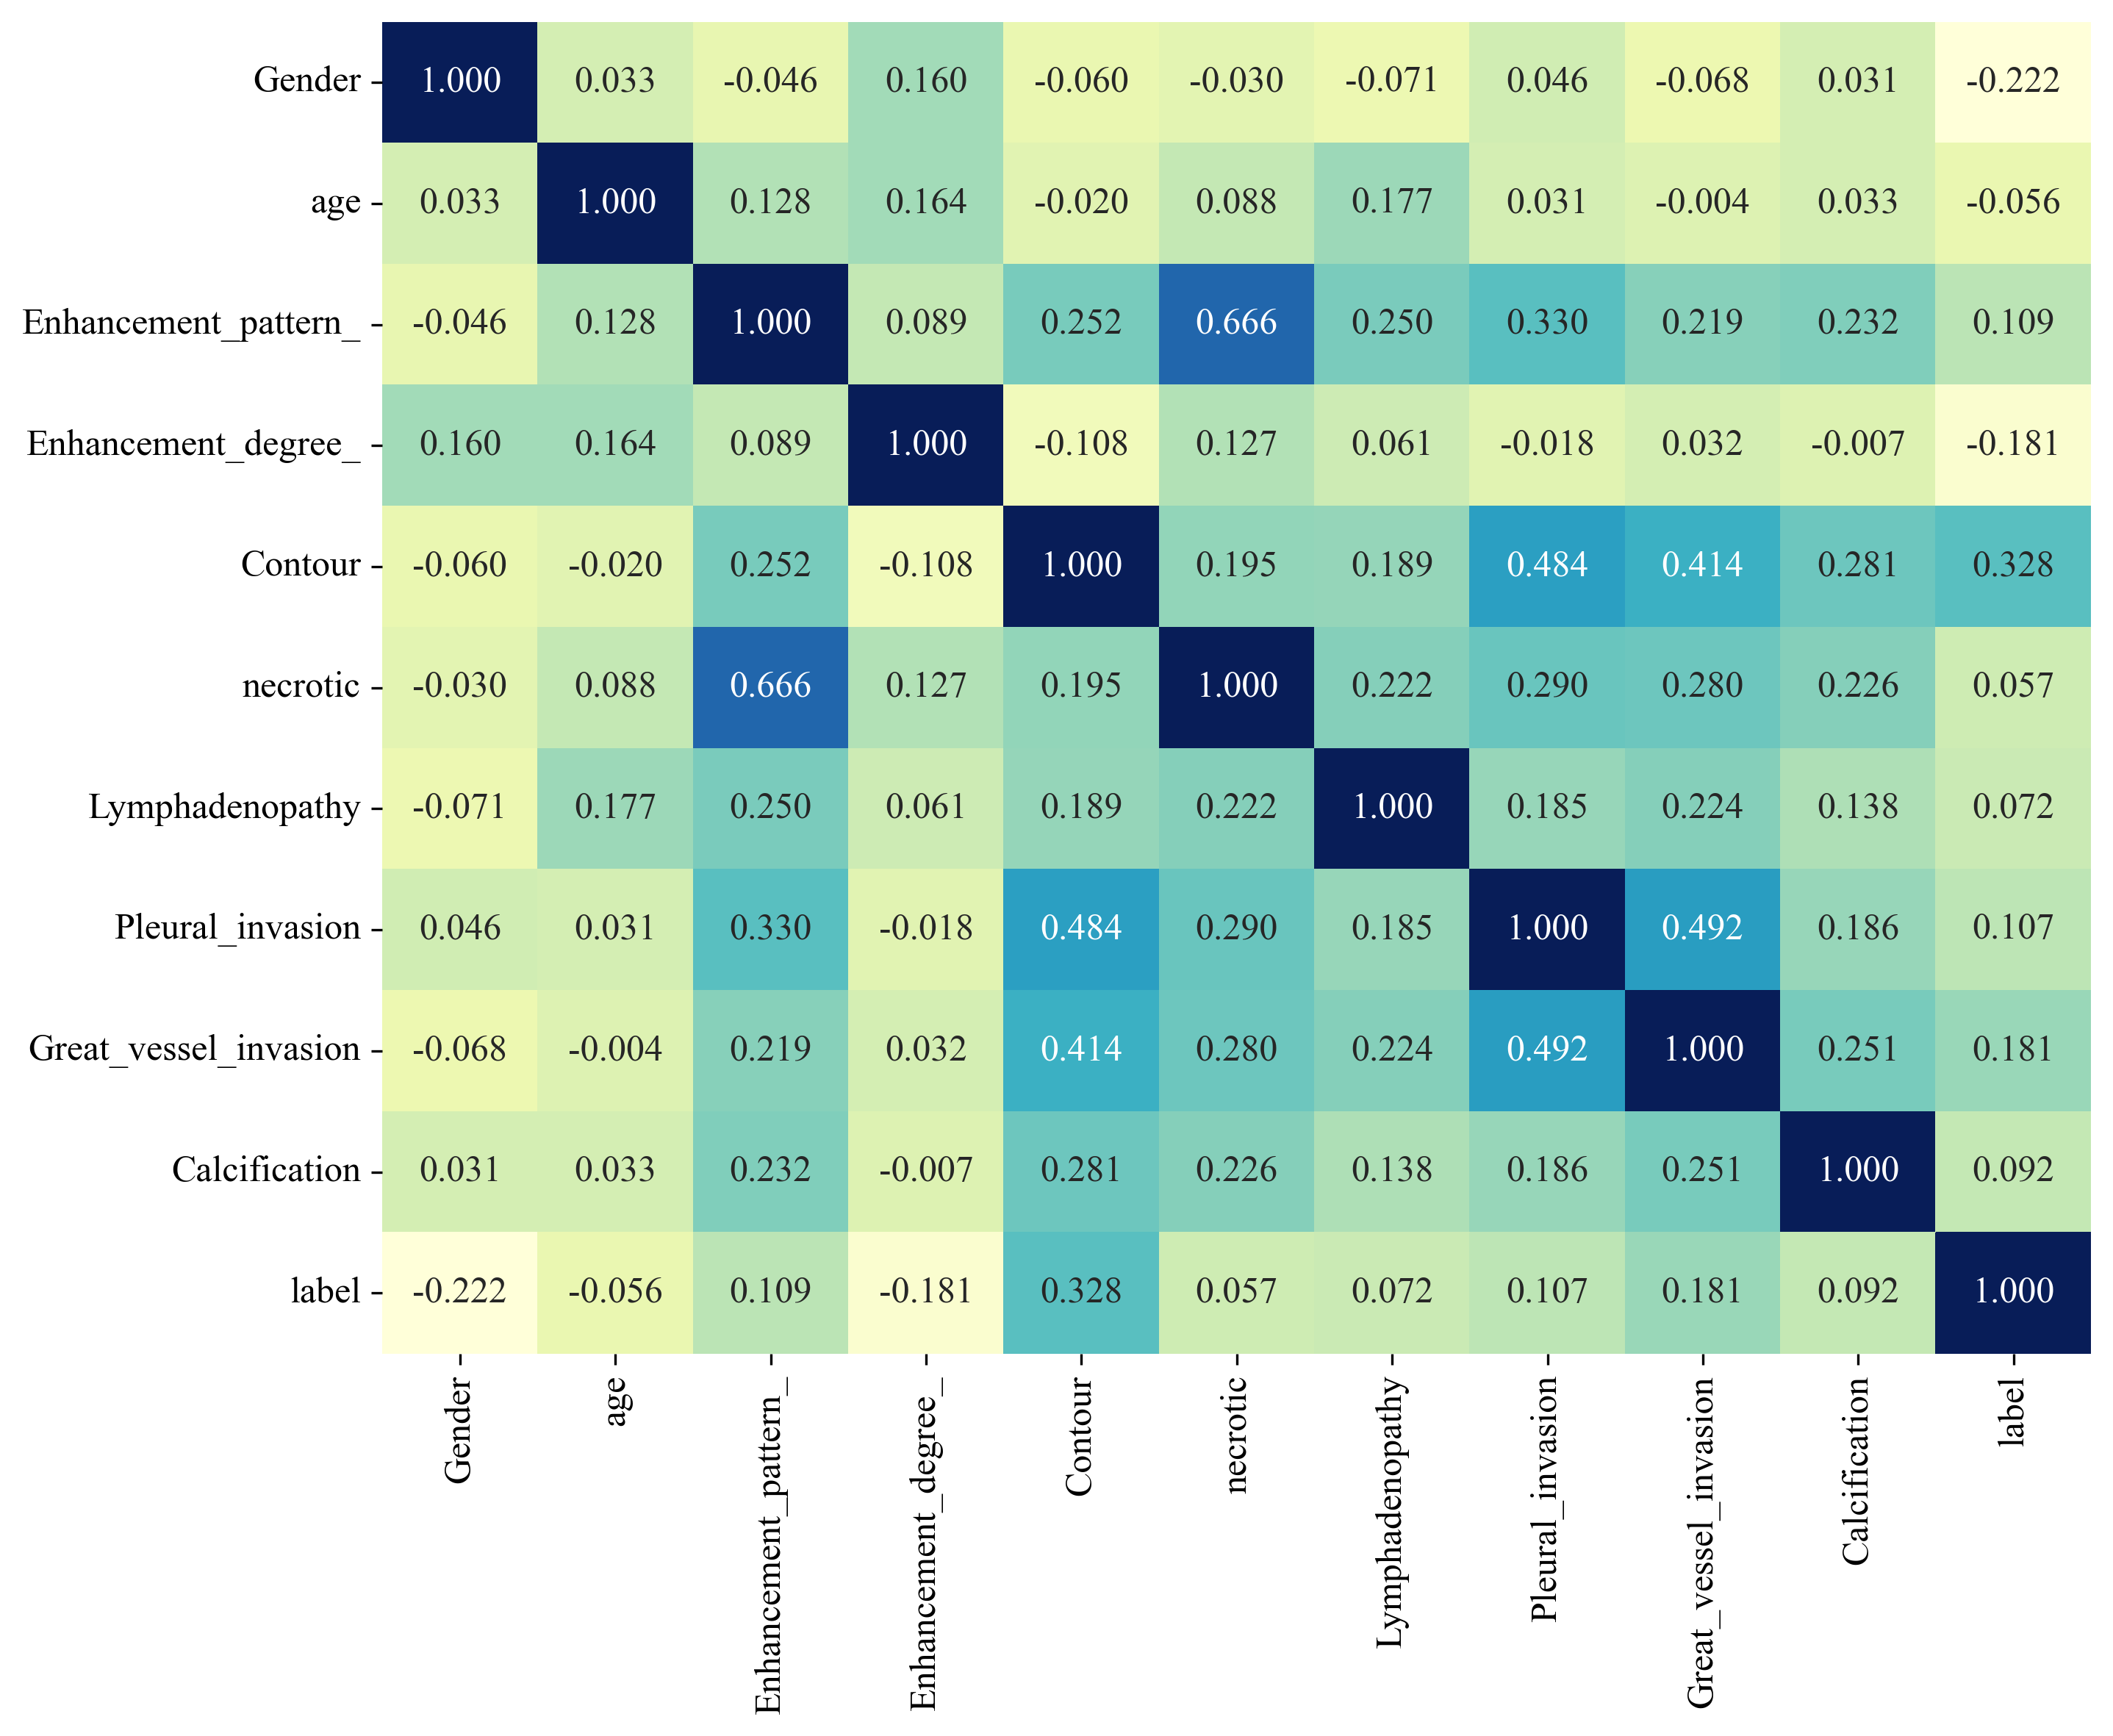

In [6]:
# 如果需要选择相关系数使用对应的相关系数即可。
# pearson_corr = data.corr('pearson')
# kendall_corr = data.corr('kendall')
spearman_corr = data.corr('spearman')

import seaborn as sns
import matplotlib.pyplot as plt
from onekey_algo.custom.components.comp1 import draw_matrix
plt.figure(figsize=(10.0, 8.0))

# 选择可视化的相关系数
draw_matrix(spearman_corr, annot=True, cmap='YlGnBu', cbar=False)
plt.savefig(f'img/Clinic_feature_corr.svg', bbox_inches = 'tight')

## 五、构建数据

将样本的训练数据X与监督信息y分离出来，并且对训练数据进行划分，一般的划分原则为80%-20%

In [7]:
import numpy as np
import onekey_algo.custom.components as okcomp

n_classes = 2
train_data = data[(data['group'] == 'train')]
train_ids = ids.loc[list(train_data.index)]
train_data = train_data.reset_index()
train_data = train_data.drop('index', axis=1)
y_data = train_data[labels]
X_data = train_data.drop(labels + ['group'], axis=1)

test_data = data[data['group'] != 'train']
test_ids = ids.loc[list(test_data.index)]
test_data = test_data.reset_index()
test_data = test_data.drop('index', axis=1)
y_test_data = test_data[labels]
X_test_data = test_data.drop(labels + ['group'], axis=1)

y_all_data = data[labels]
X_all_data = data.drop(labels + ['group'], axis=1)

column_names = X_data.columns
print(f"训练集样本数：{X_data.shape}, 验证集样本数：{X_test_data.shape}")

训练集样本数：(143, 10), 验证集样本数：(197, 10)


## 六、模型筛选

根据筛选出来的数据，做模型的初步选择。当前主要使用到的是Onekey中的

1. SVM，支持向量机，引用参考。
2. KNN，K紧邻，引用参考。
3. Decision Tree，决策树，引用参考。
4. Random Forests, 随机森林，引用参考。
5. XGBoost, bosting方法。引用参考。
6. LightGBM, bosting方法，引用参考。

In [8]:
model_names = get_param_in_cwd('ml_models') or ['SVM', 'KNN', 'RandomForest', 'ExtraTrees', 'XGBoost', 'LightGBM', 'MLP', 'LR']
models = okcomp.comp1.create_clf_model(model_names)
model_names = list(models.keys())

### 交叉验证

`n_trails`指定随机次数，每次采用的是80%训练，随机20%进行测试，找到最好的模型，以及对应的最好的数据划分。

这里的数据并没有使用前面`Lasso`筛选出来的特征进行训练，理论来说，特征筛选仅对线性模型有一定作用，例如`SVM`、`LR`，但是对树模型没什么作用，例如`DecisionTree`、`Random`这些。所以默认不筛选。

```python
def get_bst_split(X_data: pd.DataFrame, y_data: pd.DataFrame,
            models: dict, test_size=0.2, metric_fn=accuracy_score, n_trails=10,
            cv: bool = False, shuffle: bool = False, metric_cut_off: float = None, random_state=None):
    """
    寻找数据集中最好的数据划分。
    Args:
        X_data: 训练数据
        y_data: 监督数据
        models: 模型名称，Dict类型、
        test_size: 测试集比例
        metric_fn: 评价模型好坏的函数，默认准确率，可选roc_auc_score。
        n_trails: 尝试多少次寻找最佳数据集划分。
        cv: 是否是交叉验证，默认是False，当为True时，n_trails为交叉验证的n_fold
        shuffle: 是否进行随机打乱
        metric_cut_off: 当metric_fn的值达到多少时进行截断。
        random_state: 随机种子

    Returns: {'max_idx': max_idx, "max_model": max_model, "max_metric": max_metric, "results": results}

    """
```

**注意：这里采用了【挑数据】，如果想要严谨，请修改`n_trails=1`。**

[2025-04-14 18:19:59 - <frozen onekey_algo.custom.components.comp1>: 502]	WARNING	当cv=True的时候，采用的是交叉验证的模式，此时test_size的参数是不生效的，我们将忽略这个test_size设置。如果需要手动指定测试集比例，请修改cv=False。


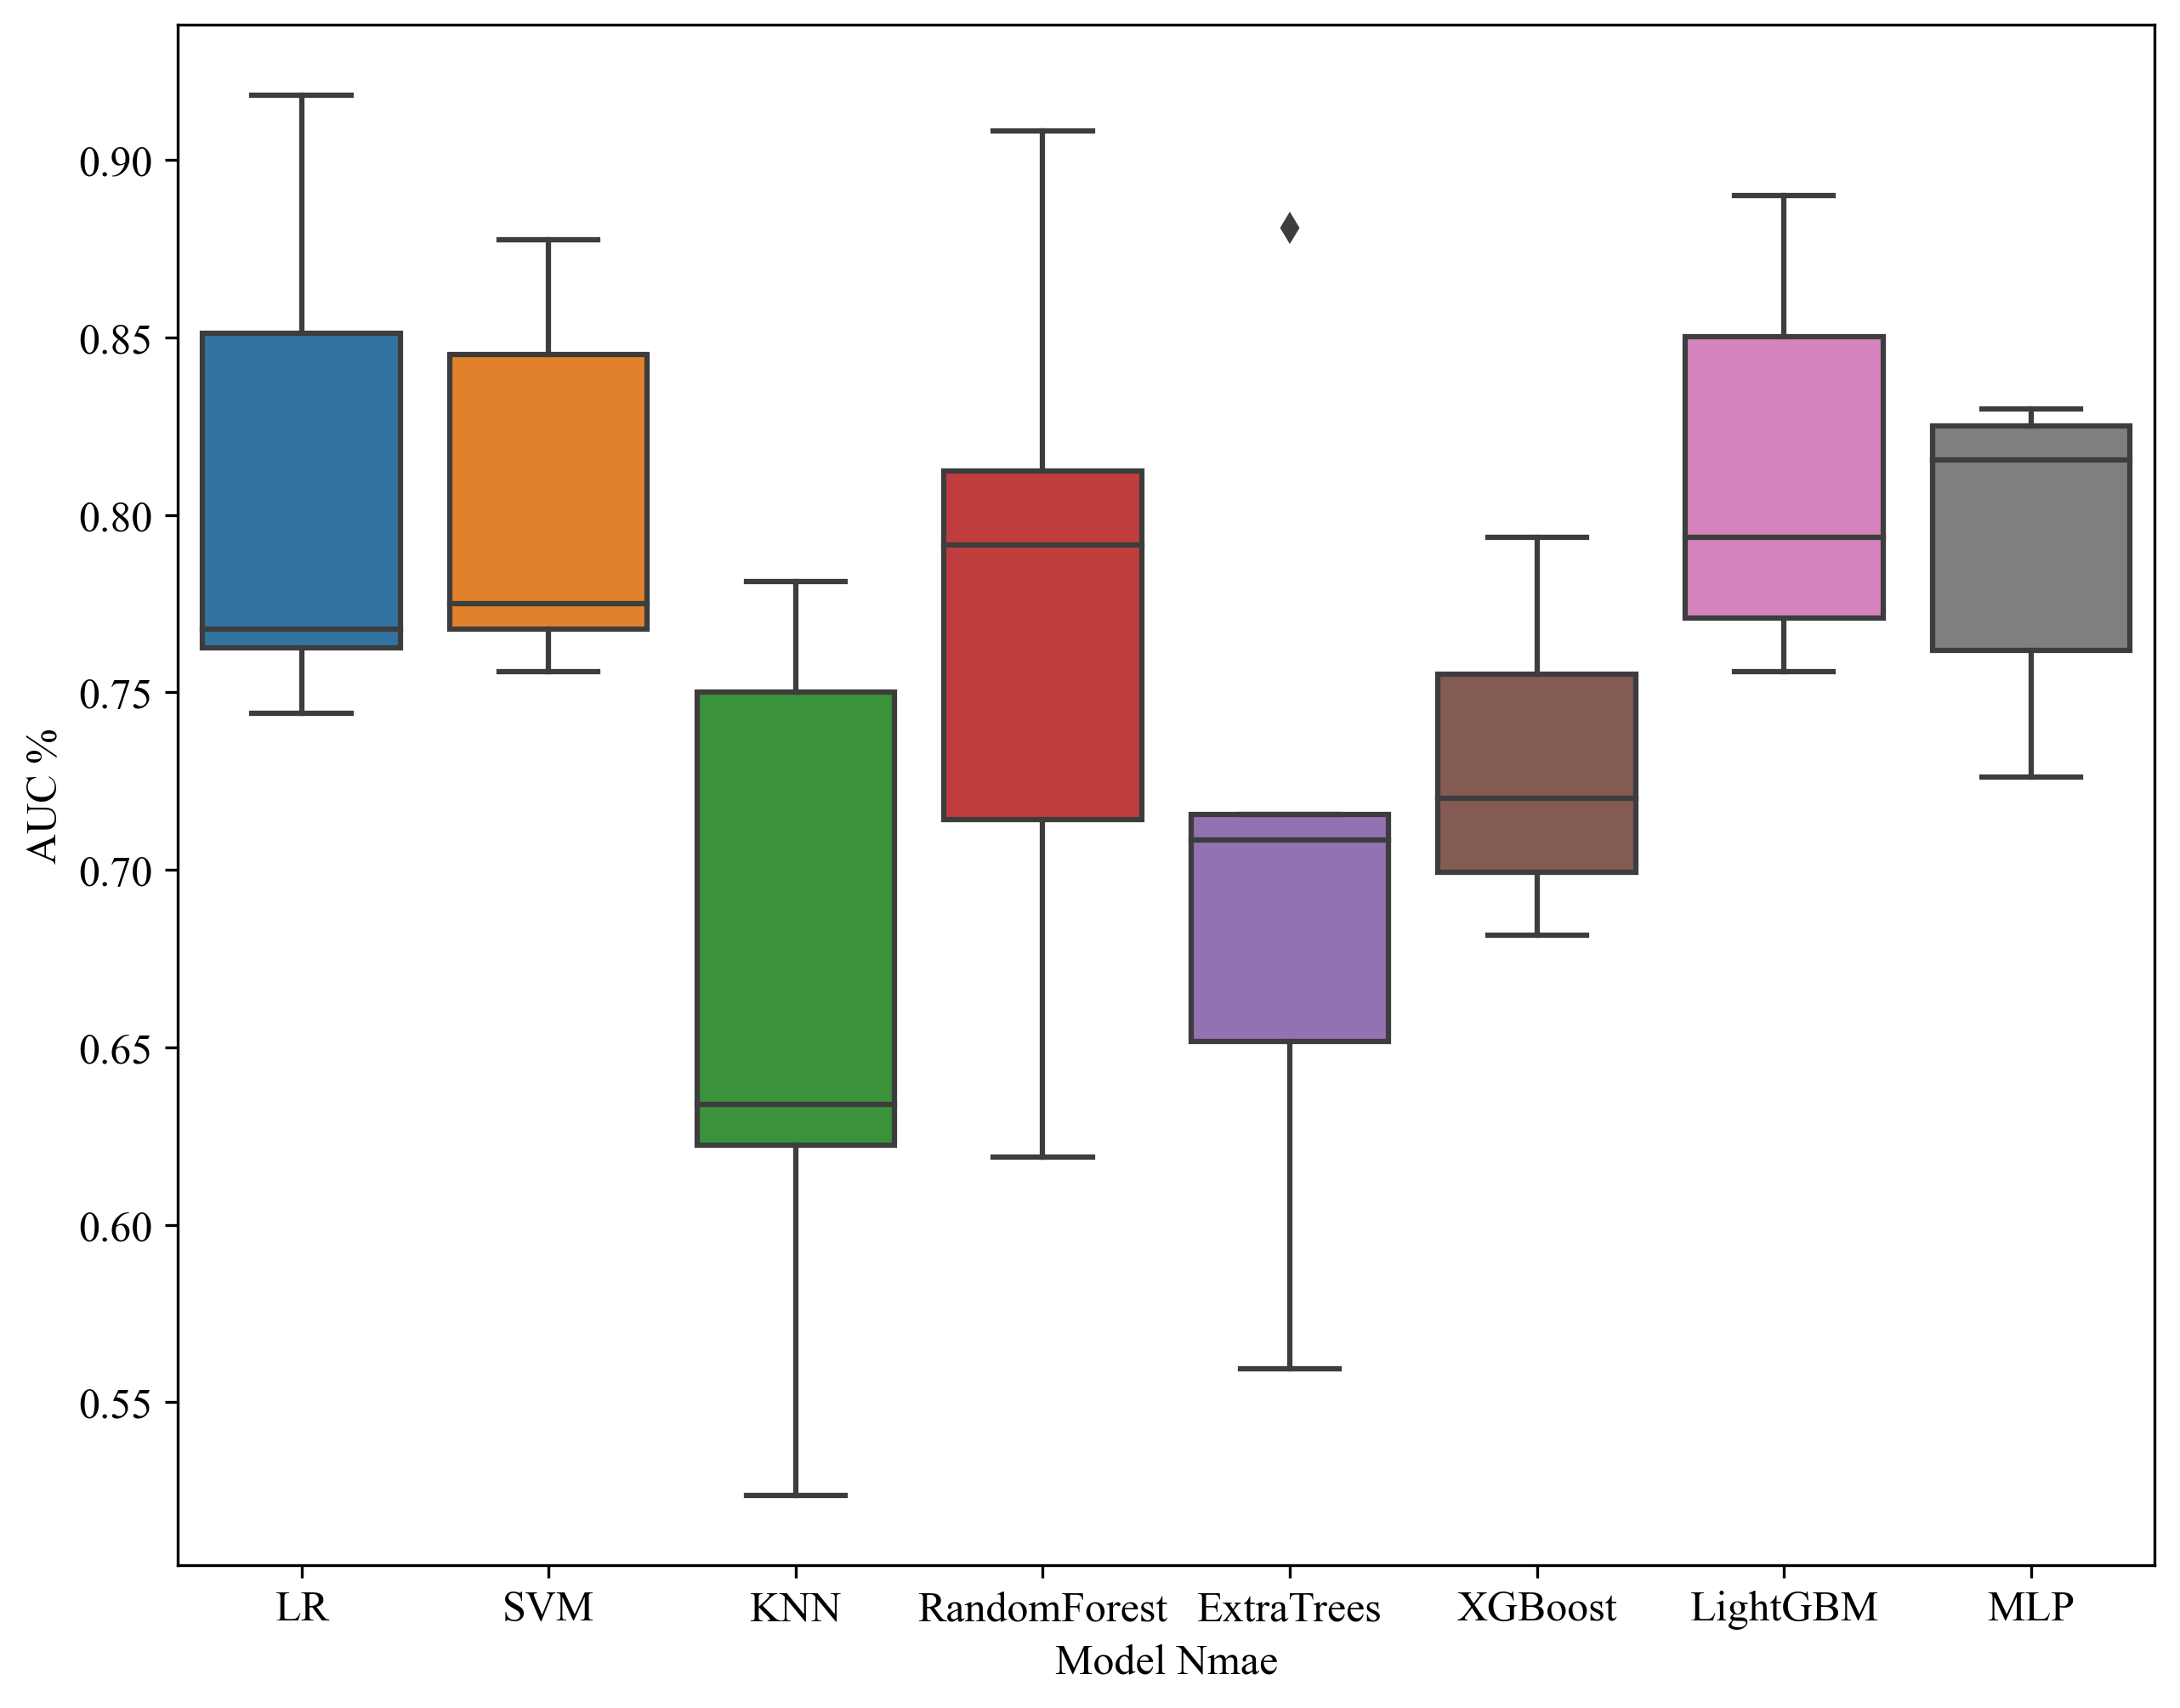

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

# 随机使用n_trails次数据划分，找到最好的一次划分方法，并且保存在results中。
results = okcomp.comp1.get_bst_split(X_data, y_data, models, test_size=0.2, metric_fn=roc_auc_score, n_trails=5, cv=True, random_state=0)
_, (X_train_sel, X_test_sel, y_train_sel, y_test_sel) = results['results'][results['max_idx']]
X_train_sel, X_test_sel, y_train_sel, y_test_sel = X_data, X_test_data, y_data, y_test_data
trails, _ = zip(*results['results'])
cv_results = pd.DataFrame(trails, columns=model_names)
# 可视化每个模型在不同的数据划分中的效果。
sns.boxplot(data=cv_results)
plt.ylabel('AUC %')
plt.xlabel('Model Nmae')
plt.savefig(f'img/Clinic_model_cv.svg', bbox_inches = 'tight')

### 模型筛选

使用最好的数据划分，进行后续的模型研究。

**注意**: 一般情况下论文使用的是随机划分的数据，但也有些论文使用【刻意】筛选的数据划分。

In [10]:
targets = []
for l in labels:
    new_models = list(okcomp.comp1.create_clf_model(model_names).values())
    for m in new_models:
        m.fit(X_train_sel, y_train_sel[l])
        y_pred = m.predict(X_test_sel)
    targets.append(new_models)

## 七、预测结果

* predictions，二维数据，每个label对应的每个模型的预测结果。
* pred_scores，二维数据，每个label对应的每个模型的预测概率值。

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from onekey_algo.custom.components.delong import calc_95_CI
from onekey_algo.custom.components.metrics import analysis_pred_binary

predictions = [[(model.predict(X_train_sel), model.predict(X_test_sel)) 
                for model in target] for label, target in zip(labels, targets)]
pred_scores = [[(model.predict_proba(X_train_sel), model.predict_proba(X_test_sel)) 
                for model in target] for label, target in zip(labels, targets)]

metric = []
pred_sel_idx = []
for label, prediction, scores in zip(labels, predictions, pred_scores):
    pred_sel_idx_label = []
    for mname, (train_pred, test_pred), (train_score, test_score) in zip(model_names, prediction, scores):
        # 计算训练集指数
        acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y_train_sel[label], 
                                                                                              train_score[:, 1])
        ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
        metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, f"{label}-train"))
                 
        # 计算验证集指标
        acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y_test_sel[label], 
                                                                                              test_score[:, 1])
        ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
        metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, f"{label}-test"))
        # 计算thres对应的sel idx
        pred_sel_idx_label.append(np.logical_or(test_score[:, 0] >= thres, test_score[:, 1] >= thres))
    
    pred_sel_idx.append(pred_sel_idx_label)
metric = pd.DataFrame(metric, index=None, columns=['model_name', 'Accuracy', 'AUC', '95% CI',
                                                   'Sensitivity', 'Specificity', 
                                                   'PPV', 'NPV', 'Precision', 'Recall', 'F1',
                                                   'Threshold', 'Task'])
metric

model_name  Accuracy    AUC           95% CI  Sensitivity  Specificity  \
0             LR     0.811  0.839  0.7651 - 0.9134        0.856        0.692   
1             LR     0.650  0.662  0.5823 - 0.7422        0.612        0.721   
2            SVM     0.776  0.846  0.7739 - 0.9189        0.750        0.846   
3            SVM     0.629  0.659  0.5770 - 0.7400        0.589        0.706   
4            KNN     0.825  0.912  0.8683 - 0.9562        0.817        0.846   
5            KNN     0.579  0.595  0.5154 - 0.6751        0.558        0.618   
6   RandomForest     0.979  0.998  0.9956 - 1.0000        0.971        1.000   
7   RandomForest     0.660  0.629  0.5459 - 0.7120        0.775        0.441   
8     ExtraTrees     1.000  1.000  1.0000 - 1.0000        1.000        1.000   
9     ExtraTrees     0.695  0.648  0.5653 - 0.7317        0.845        0.412   
10       XGBoost     0.923  0.983  0.9679 - 0.9986        0.913        0.949   
11       XGBoost     0.640  0.630  0.5470 - 0.7127        0.659        0.603   
12      LightGBM     0.783  0.875  0.8155 - 0.9338        0.740        0.897   
13      LightGBM     0.685  0.644  0.5613 - 0.7259        0.744        0.574   
14           MLP     0.727  0.802  0.7255 - 0.8785        0.702        0.795   
15           MLP     0.665  0.655  0.5720 - 0.7387        0.667        0.662   

      PPV    NPV  Precision  Recall     F1  Threshold         Task  
0   0.881  0.643      0.881   0.856  0.868      0.643  label-train  
1   0.806  0.495      0.806   0.612  0.696      0.663   label-test  
2   0.929  0.559      0.929   0.750  0.830      0.745  label-train  
3   0.792  0.475      0.792   0.589  0.676      0.683   label-test  
4   0.934  0.635      0.934   0.817  0.872      0.800  label-train  
5   0.735  0.424      0.735   0.558  0.634      0.800   label-test  
6   1.000  0.929      1.000   0.971  0.985      0.600  label-train  
7   0.725  0.508      0.725   0.775  0.749      0.500   label-test  
8   1.000  1.000      1.000   1.000  1.000      1.000  label-train  
9   0.732  0.583      0.732   0.845  0.784      0.400   label-test  
10  0.979  0.804      0.979   0.913  0.945      0.710  label-train  
11  0.759  0.482      0.759   0.659  0.705      0.651   label-test  
12  0.951  0.565      0.951   0.740  0.832      0.723  label-train  
13  0.768  0.542      0.768   0.744  0.756      0.665   label-test  
14  0.901  0.500      0.901   0.702  0.789      0.722  label-train  
15  0.789  0.511      0.789   0.667  0.723      0.664   label-test

### 绘制曲线

绘制的不同模型的准确率柱状图和折线图曲线。

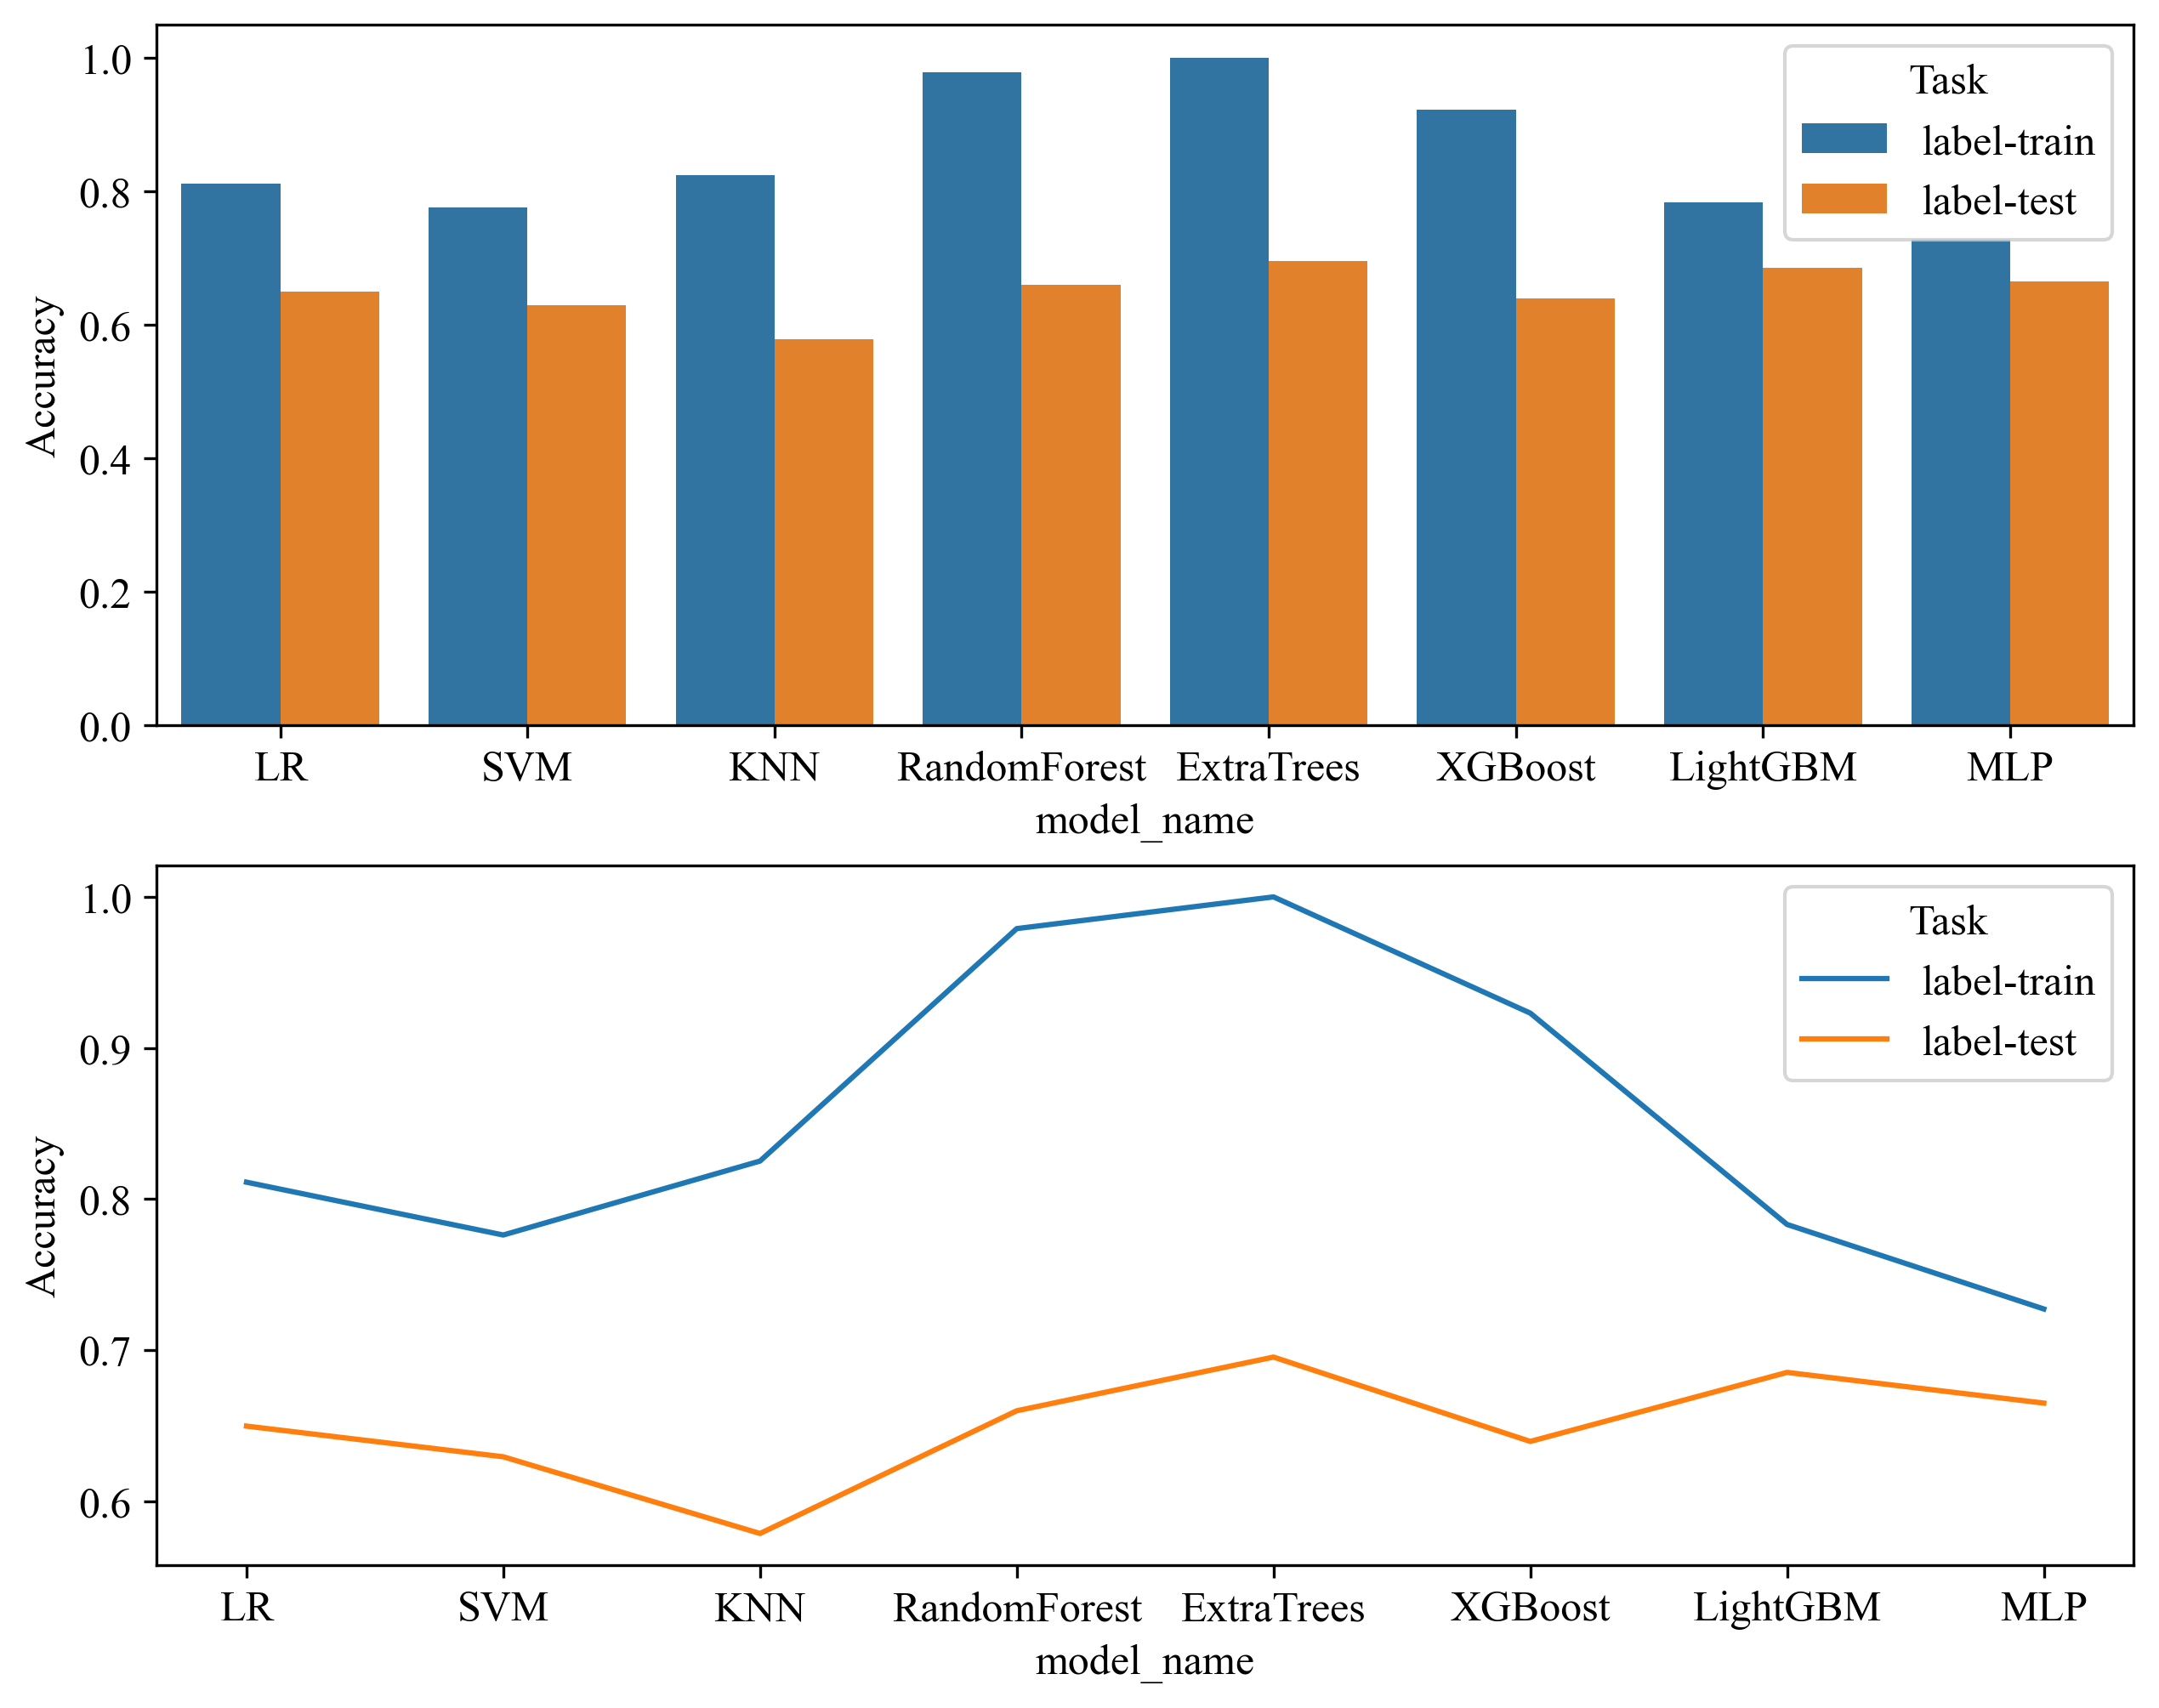

In [12]:
import seaborn as sns

plt.subplot(211)
sns.barplot(x='model_name', y='Accuracy', data=metric, hue='Task')
plt.subplot(212)
sns.lineplot(x='model_name', y='Accuracy', data=metric, hue='Task')
plt.savefig(f'img/Clinic_model_acc.svg', bbox_inches = 'tight')

## 绘制ROC曲线
确定最好的模型，并且绘制曲线。

```python
def draw_roc(y_test, y_score, title='ROC', labels=None):
```

`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

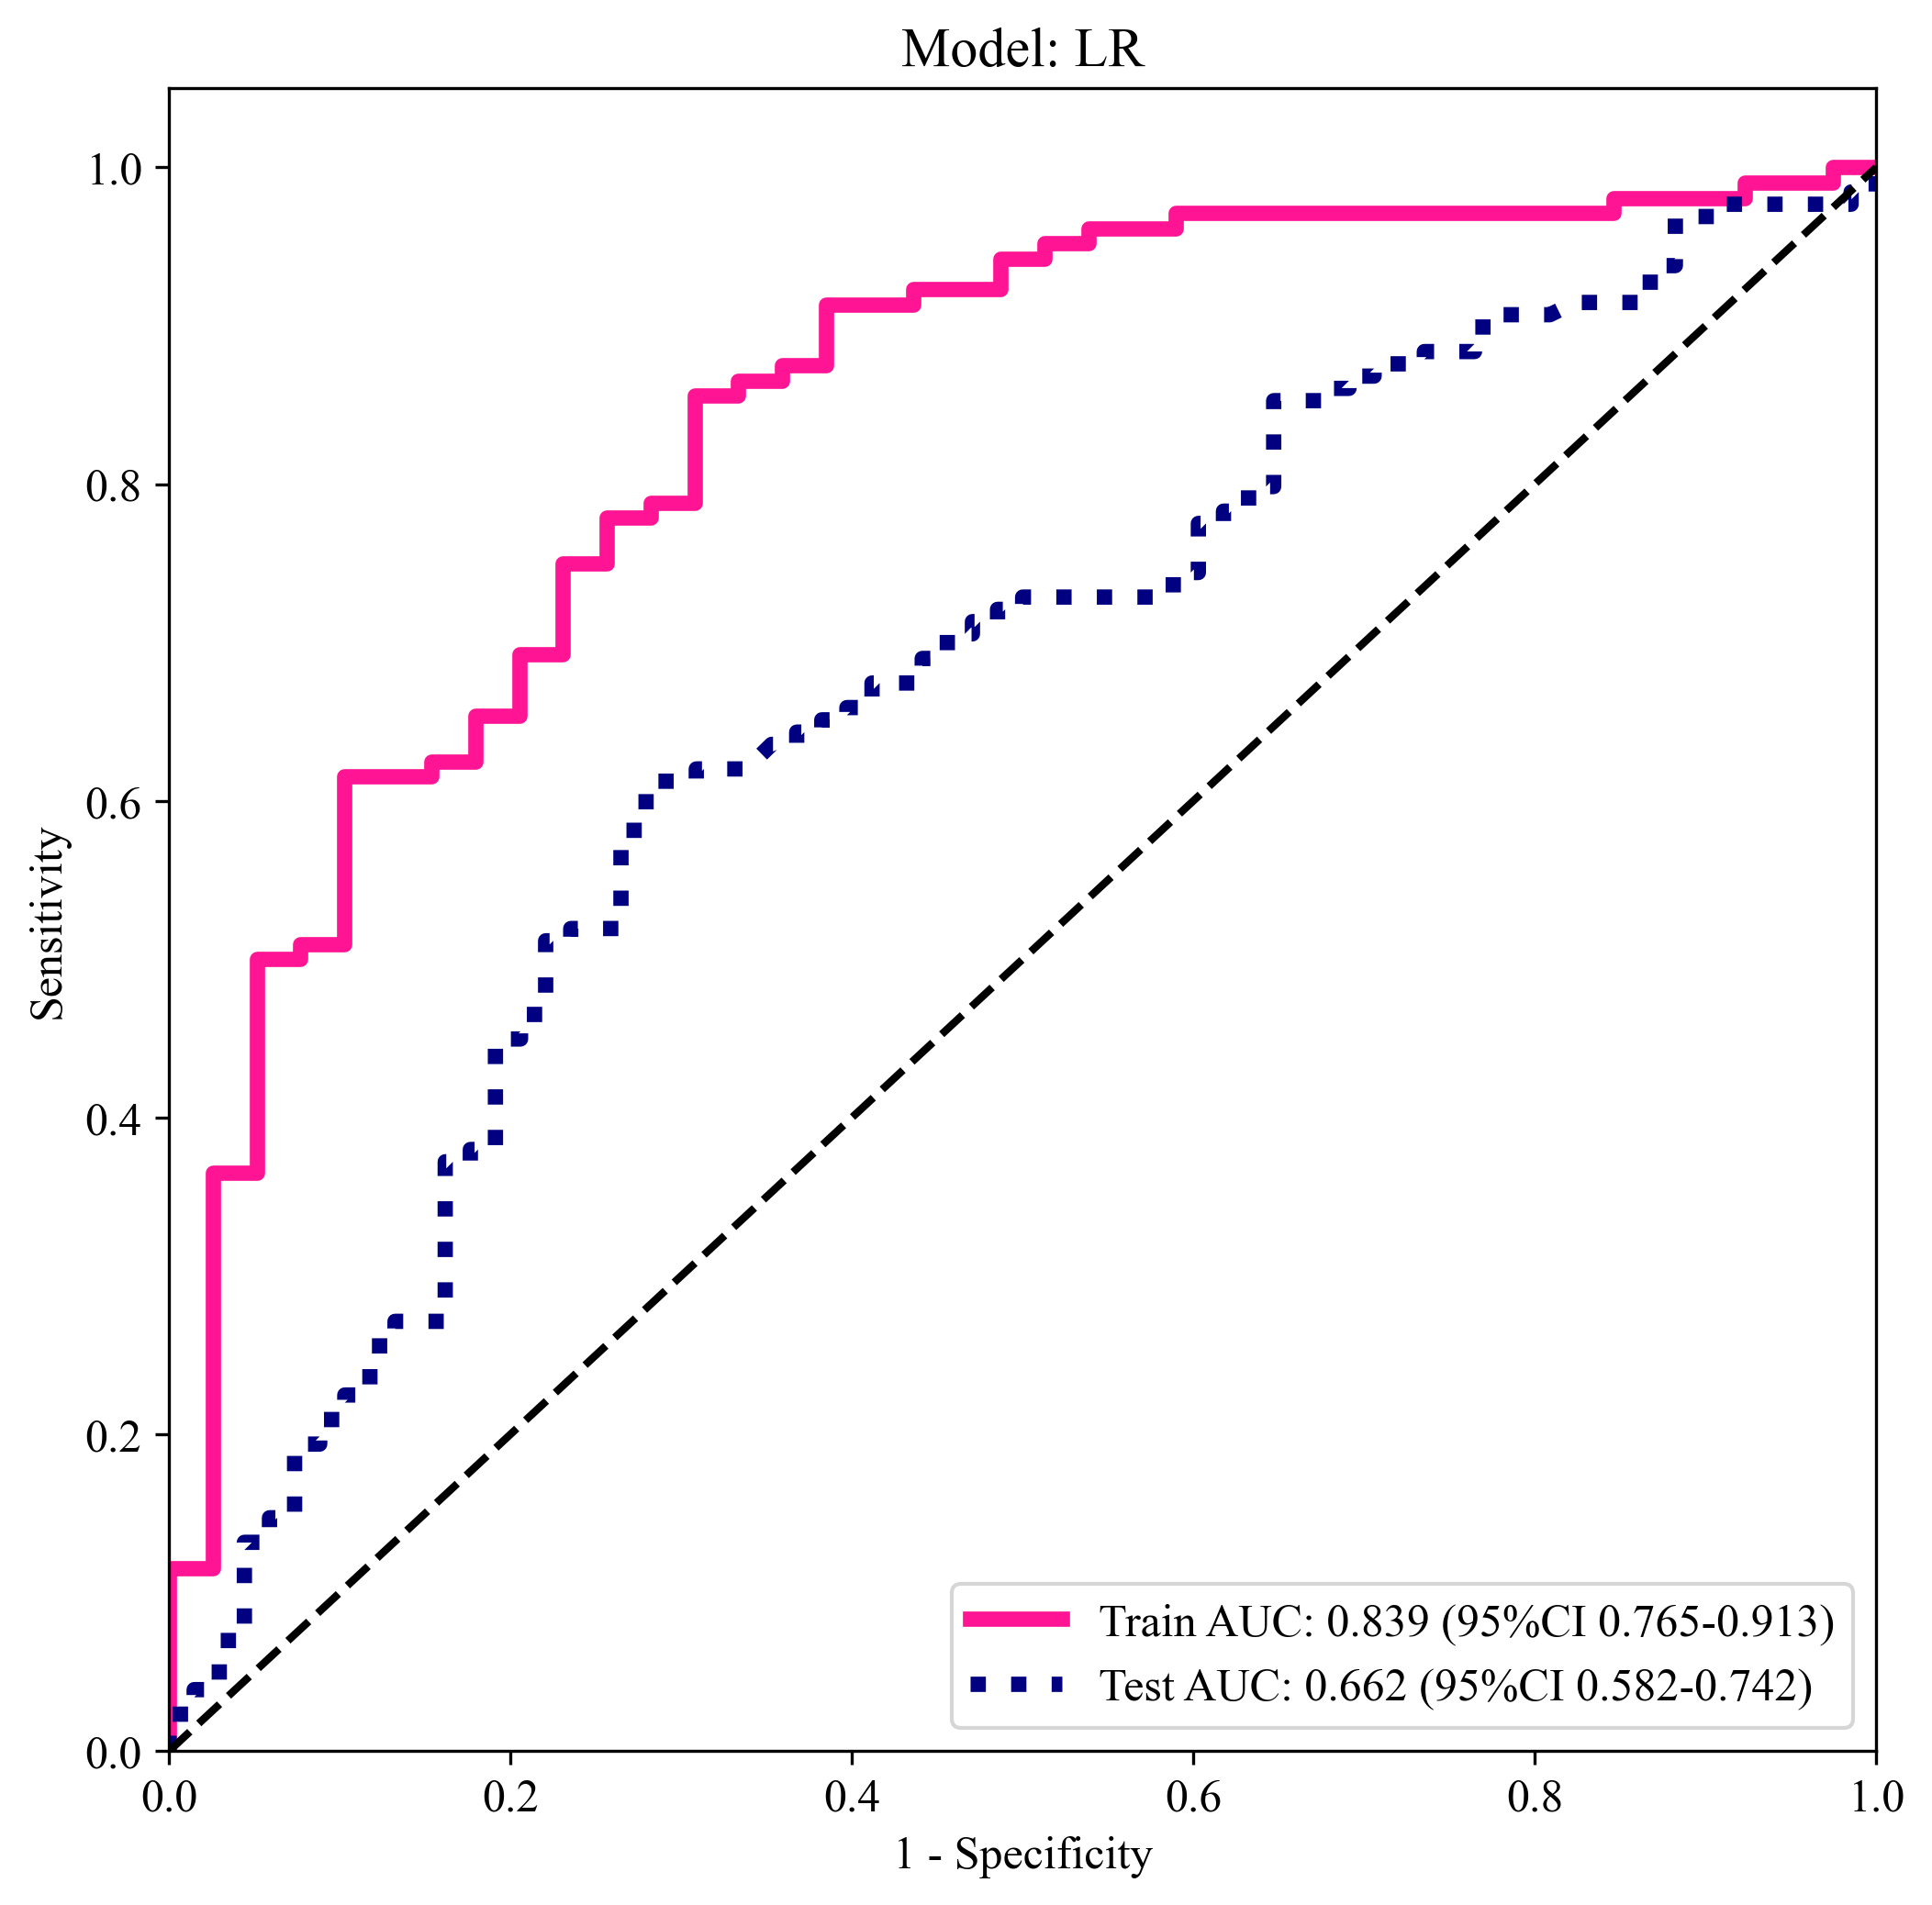

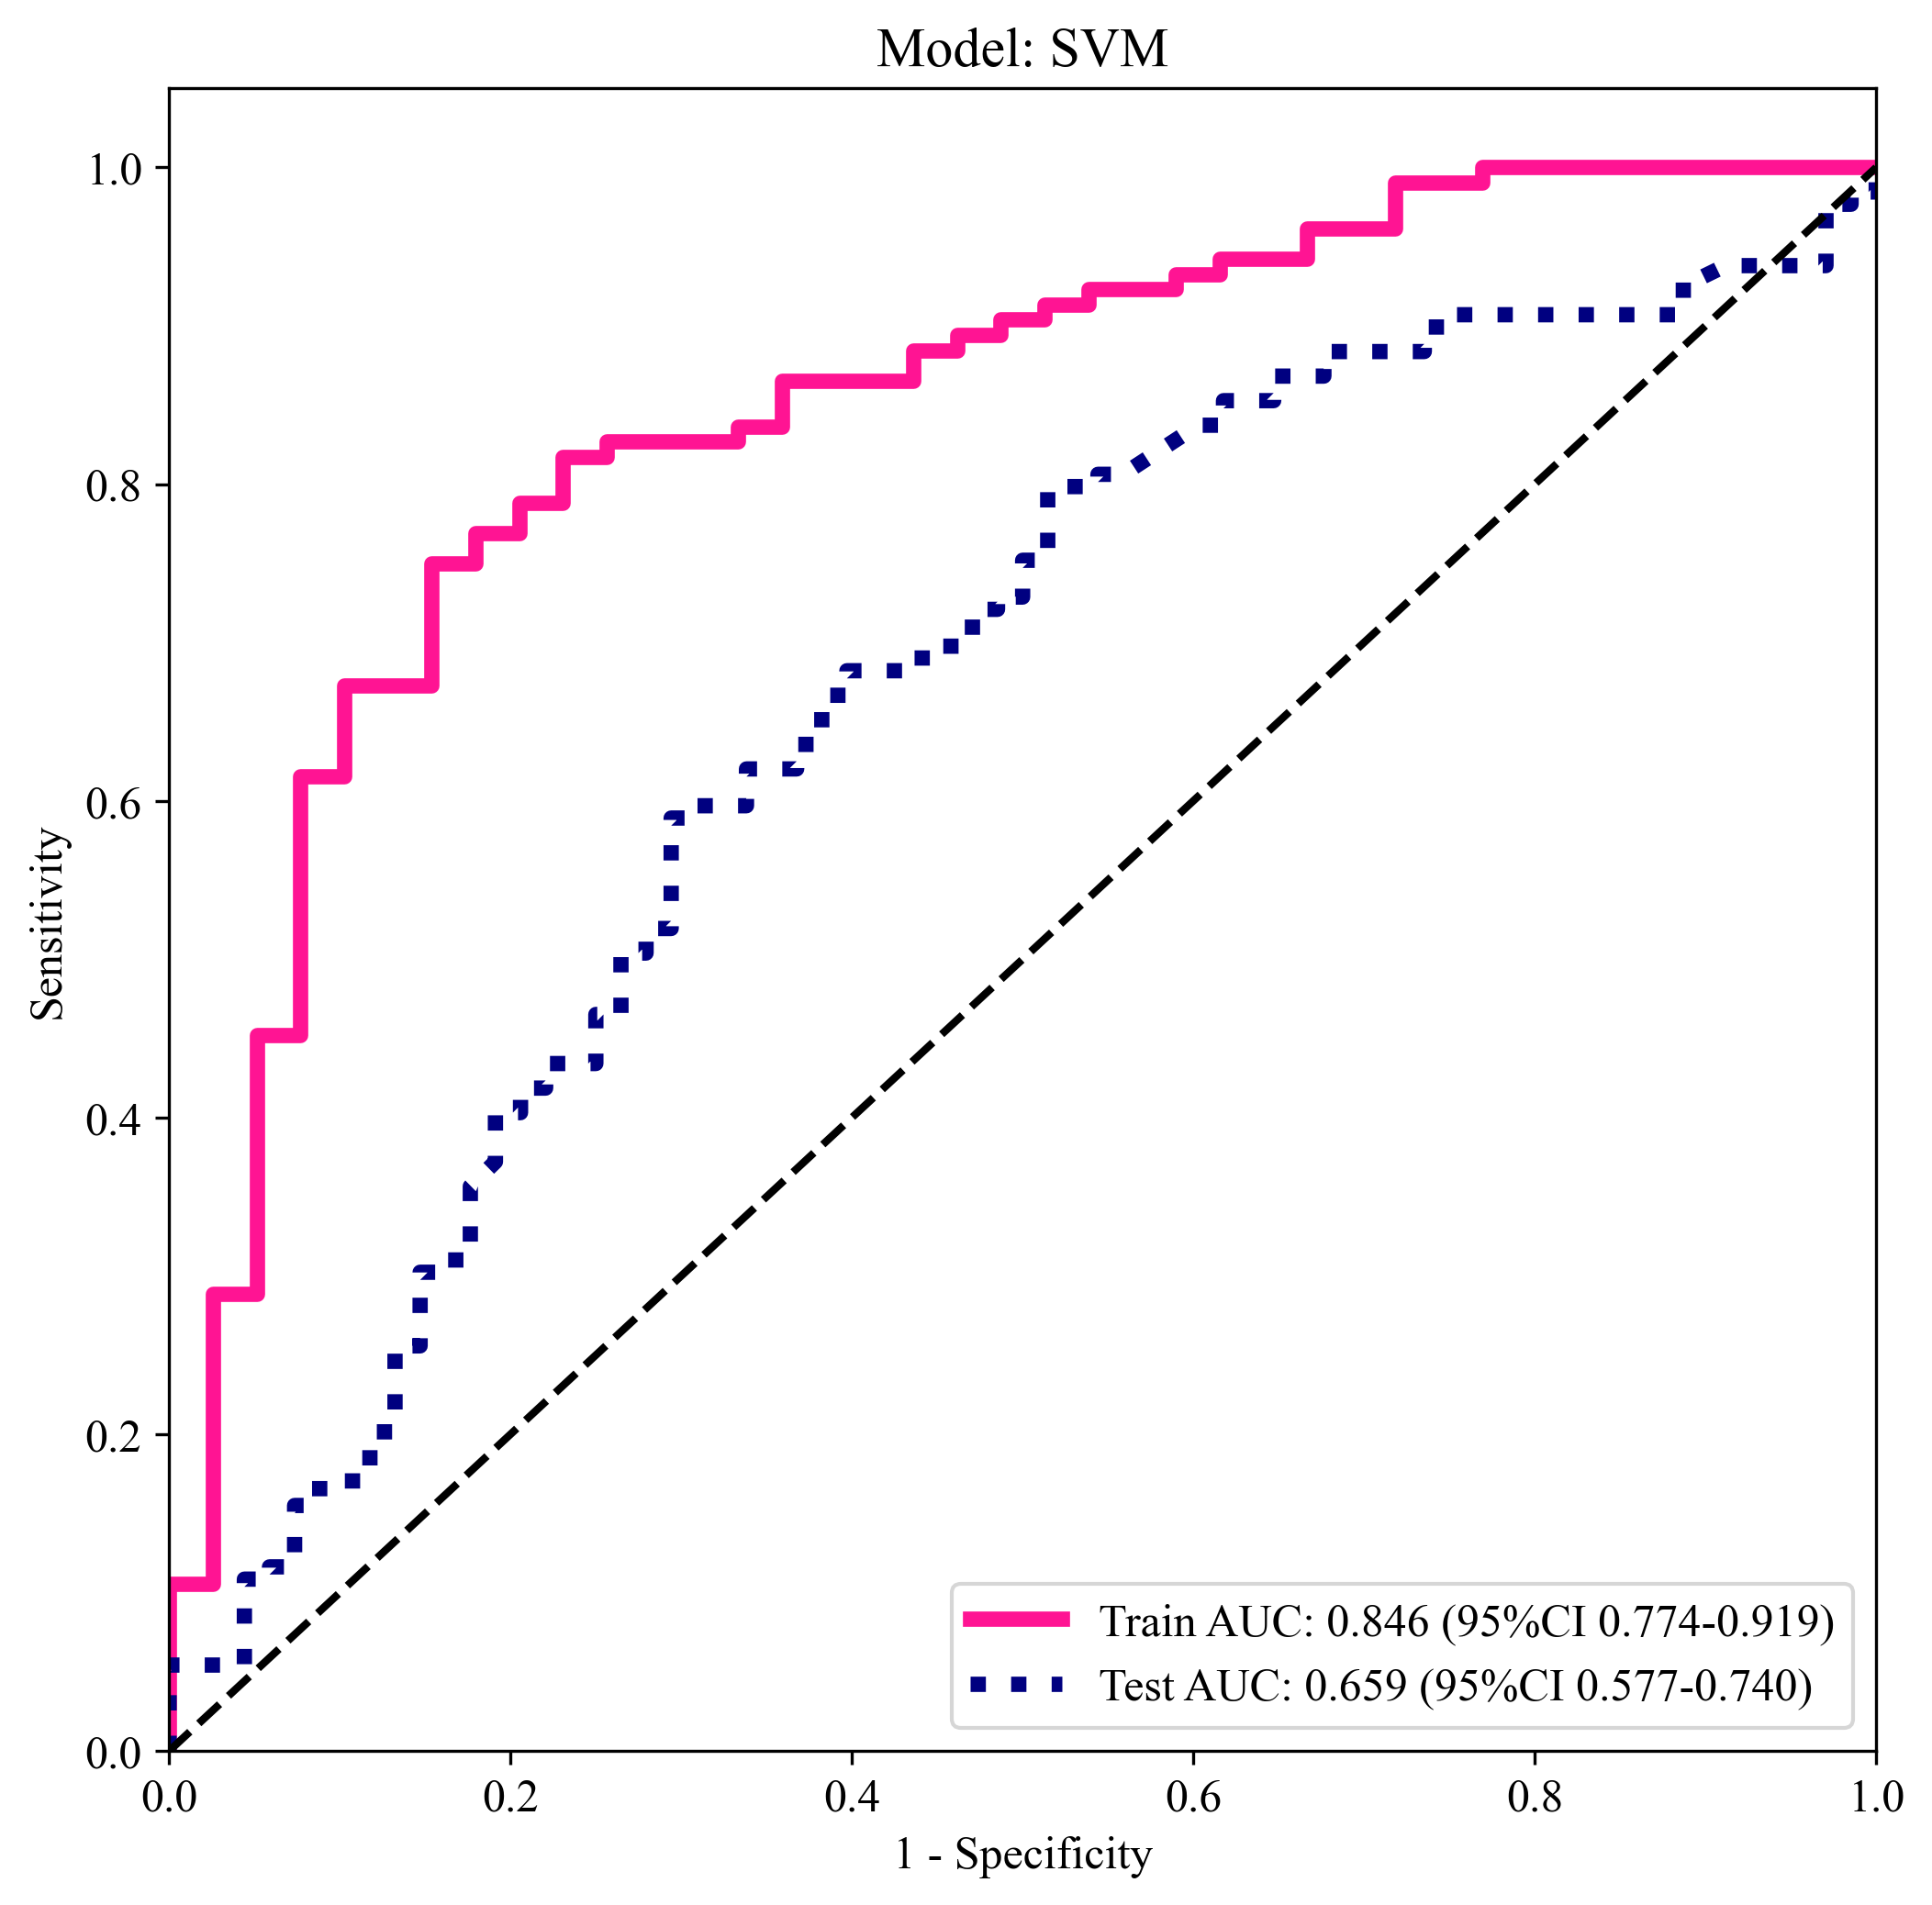

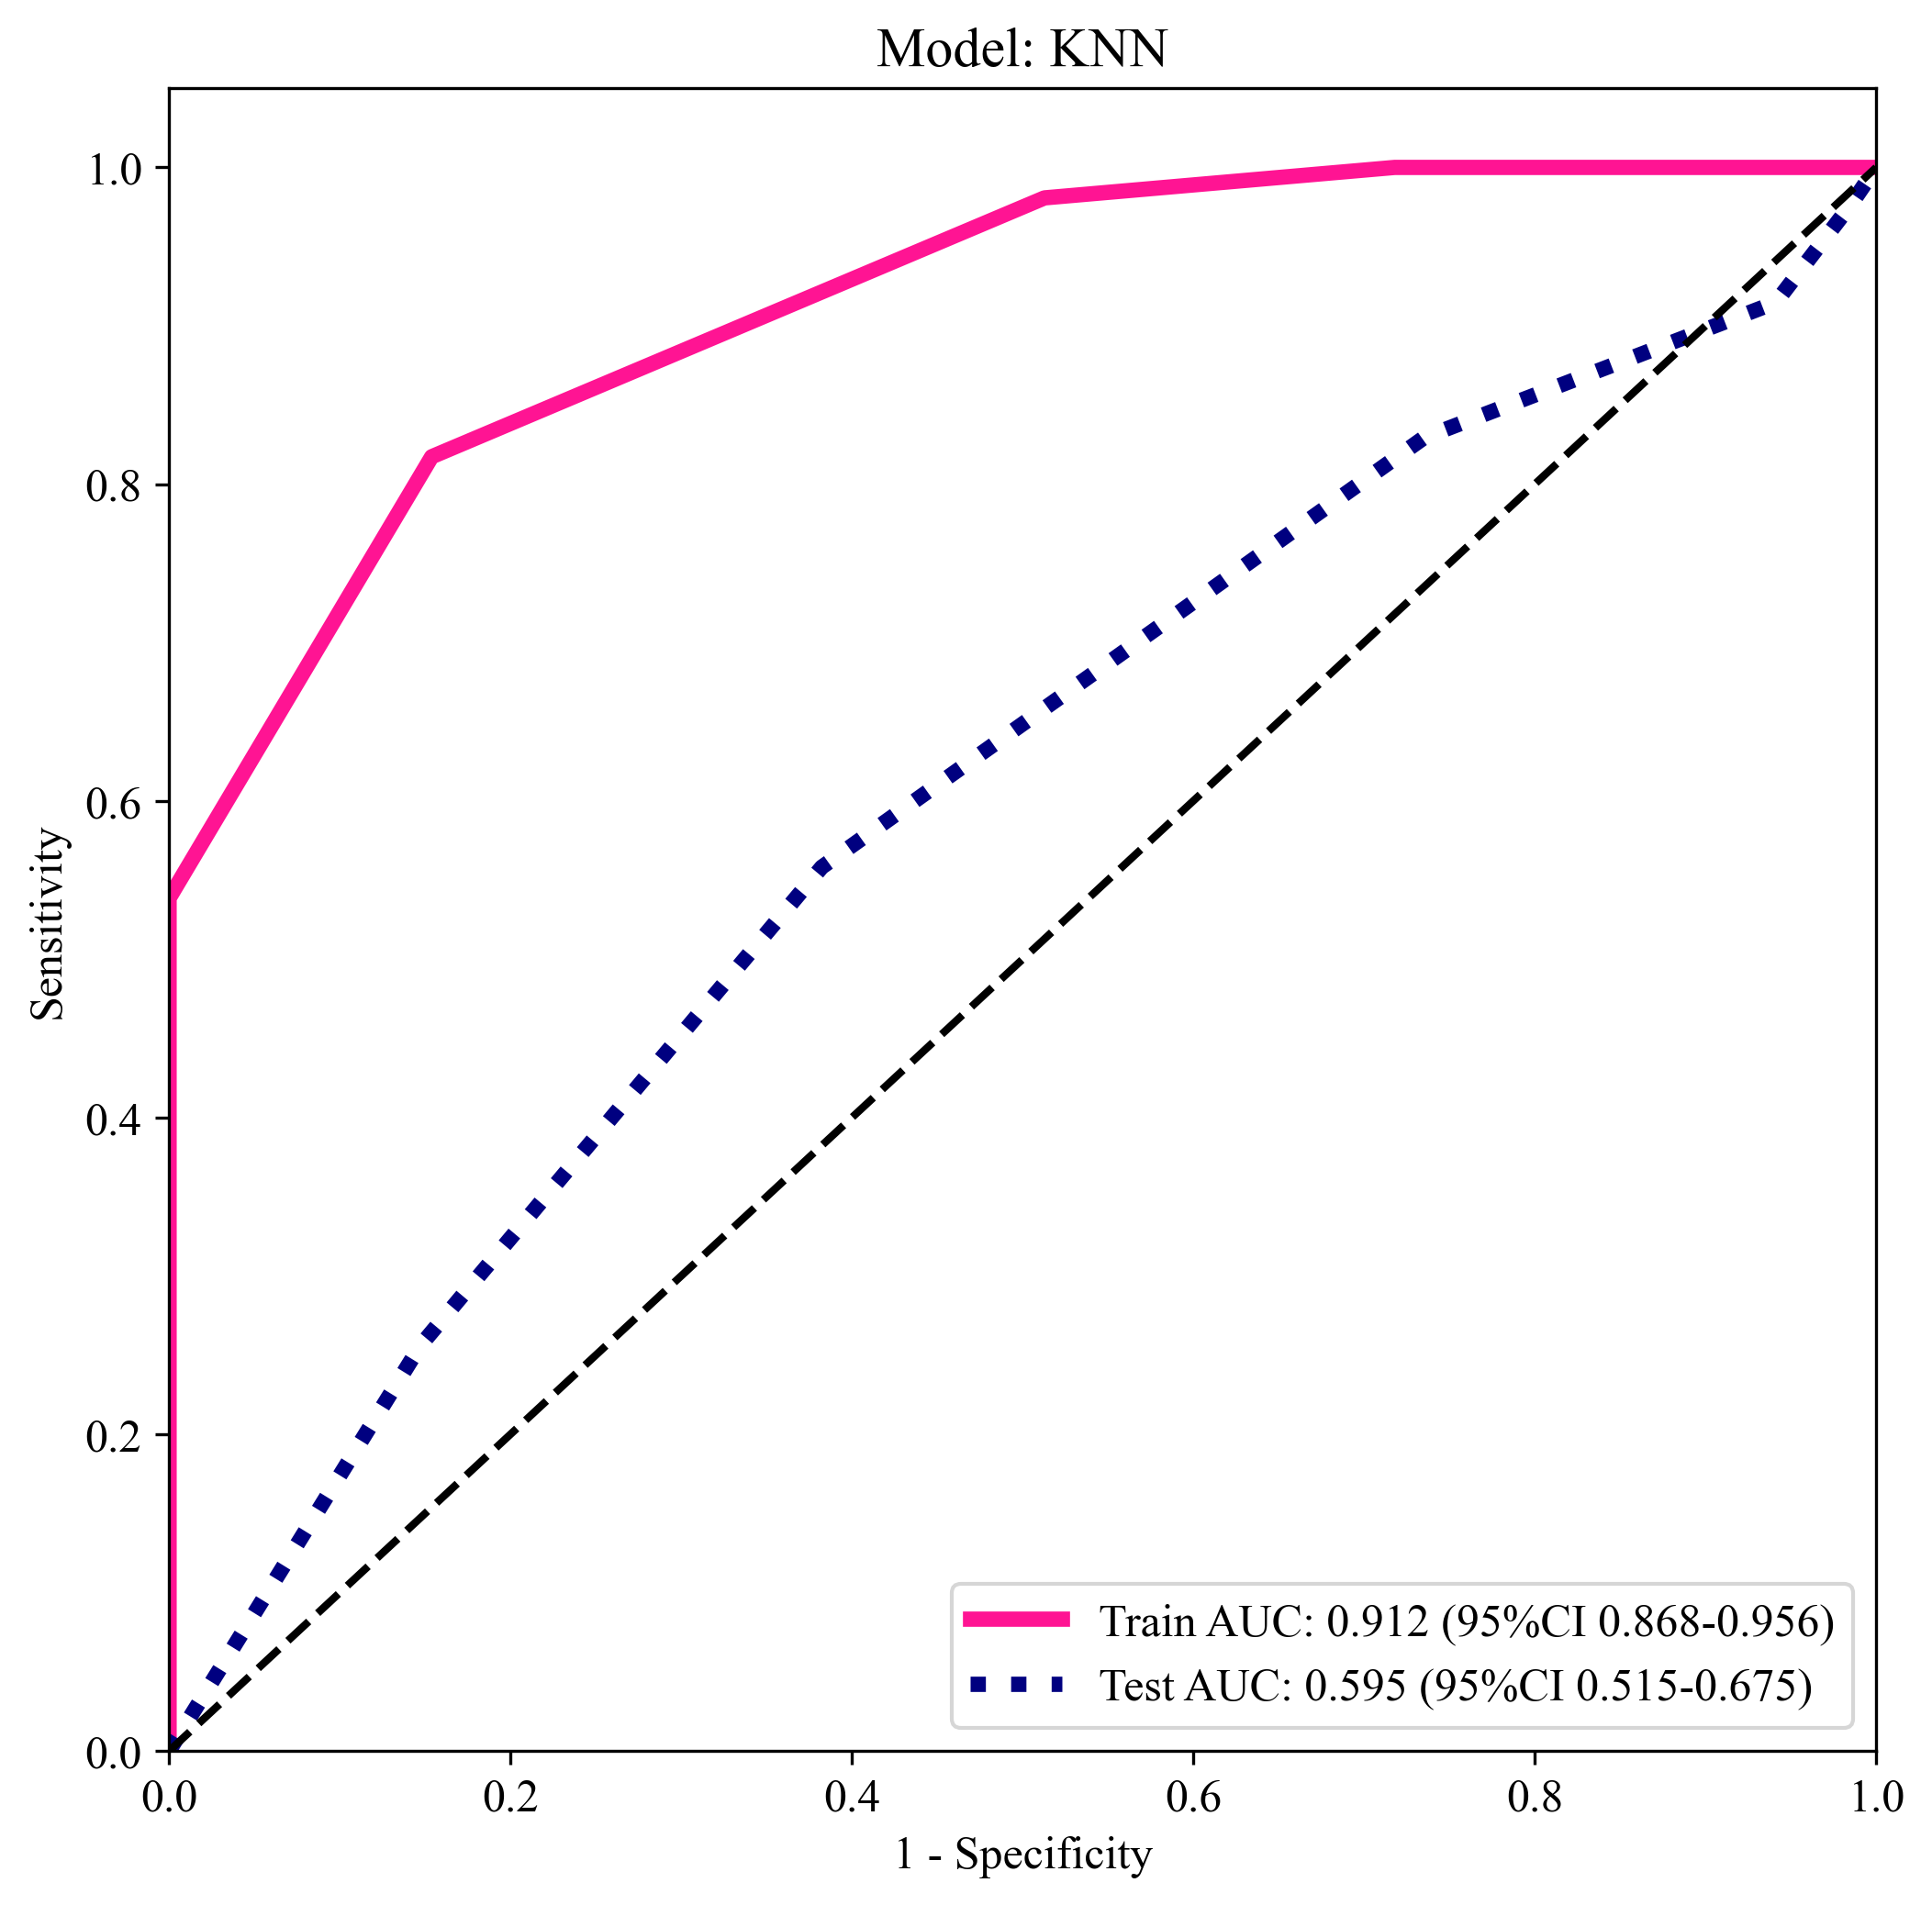

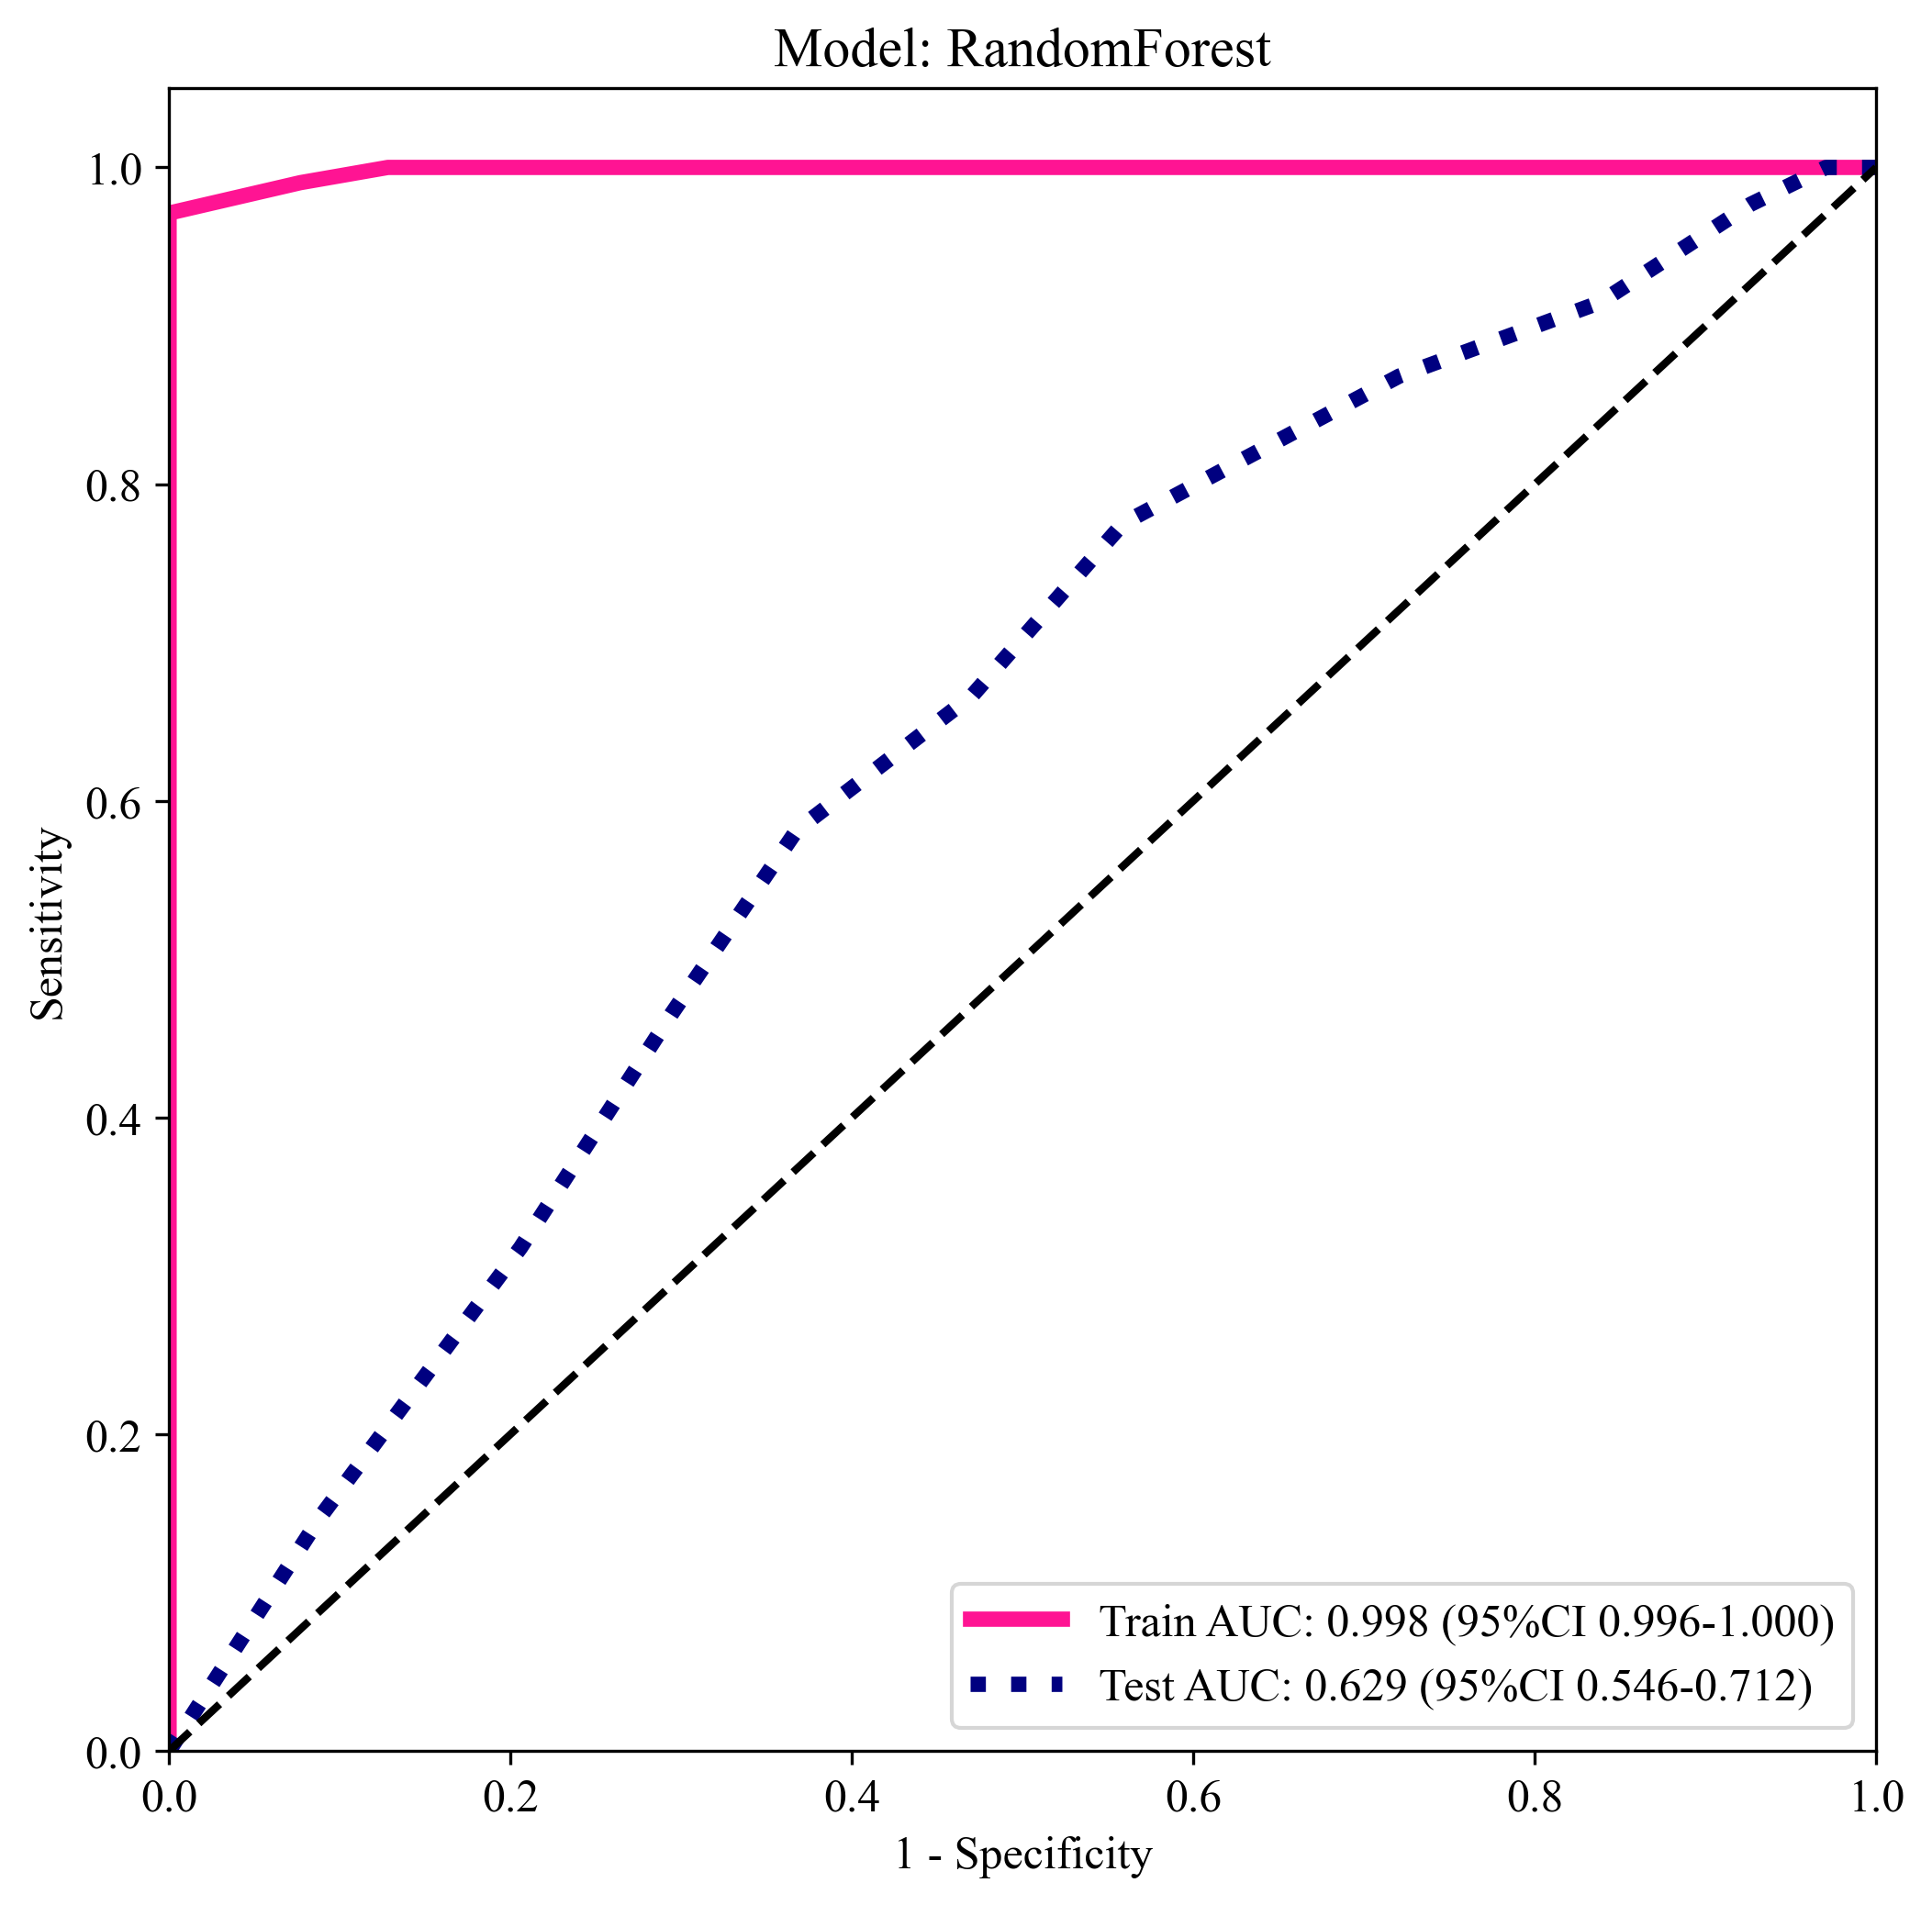

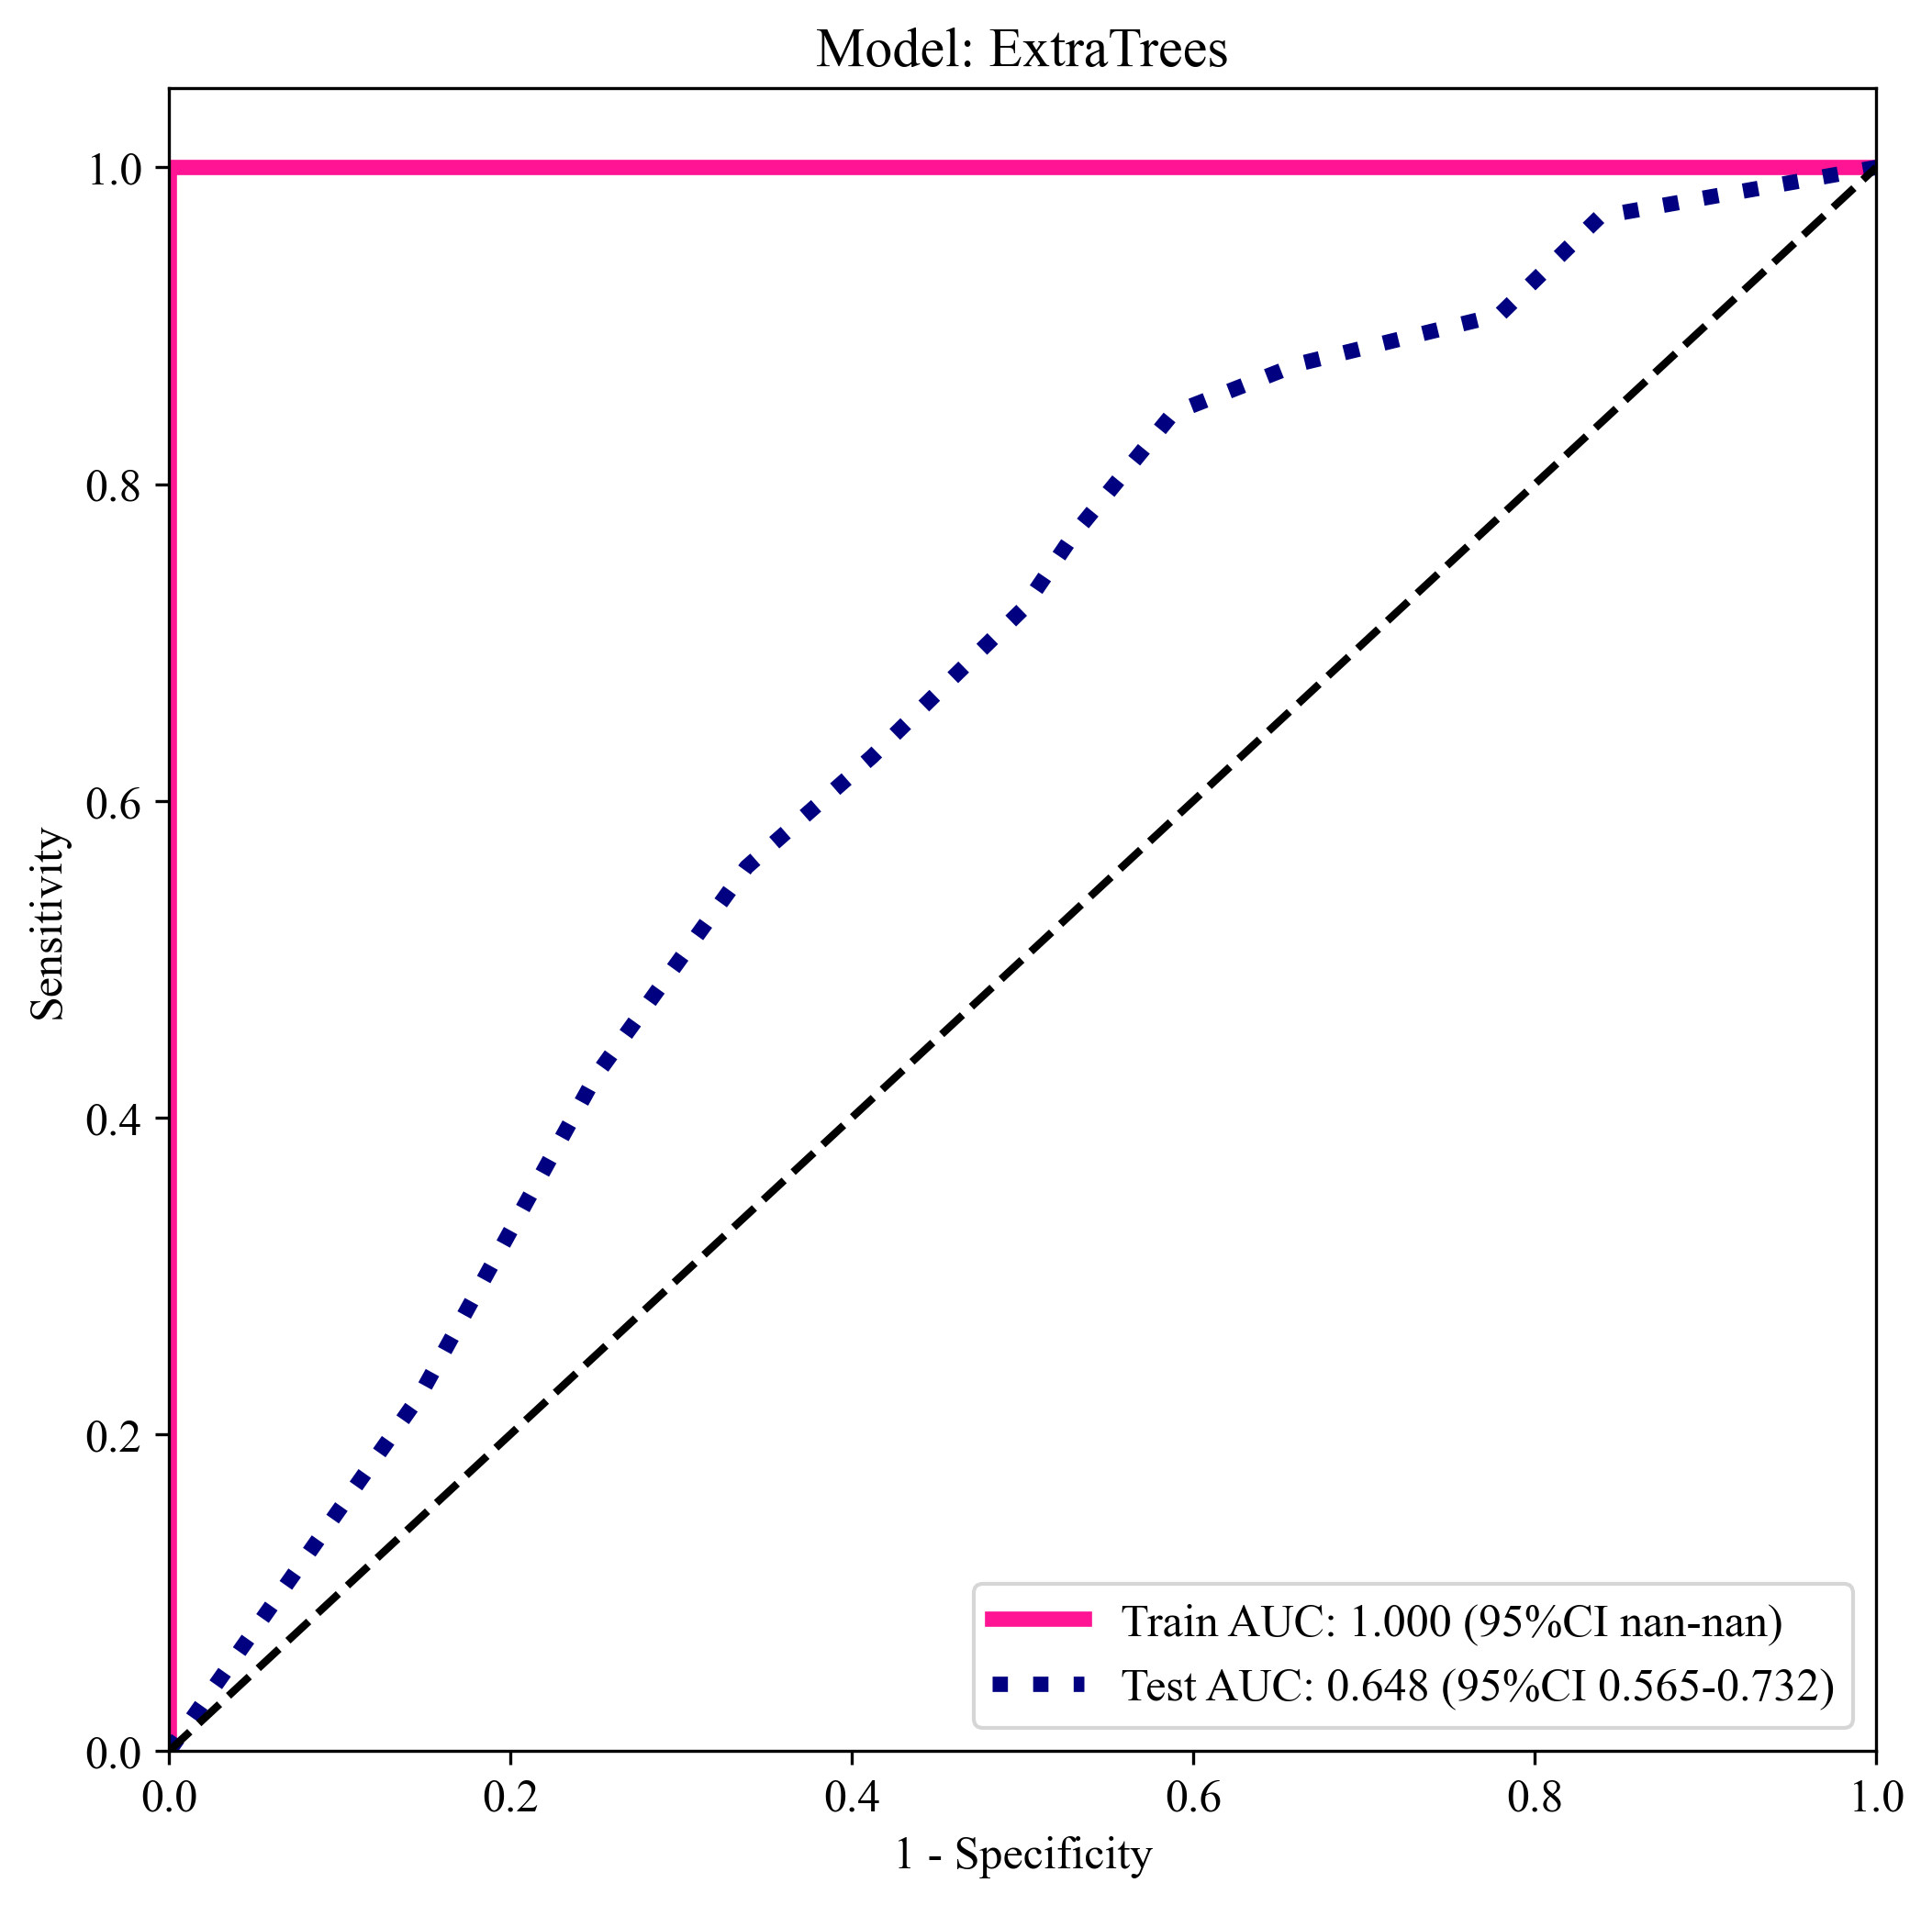

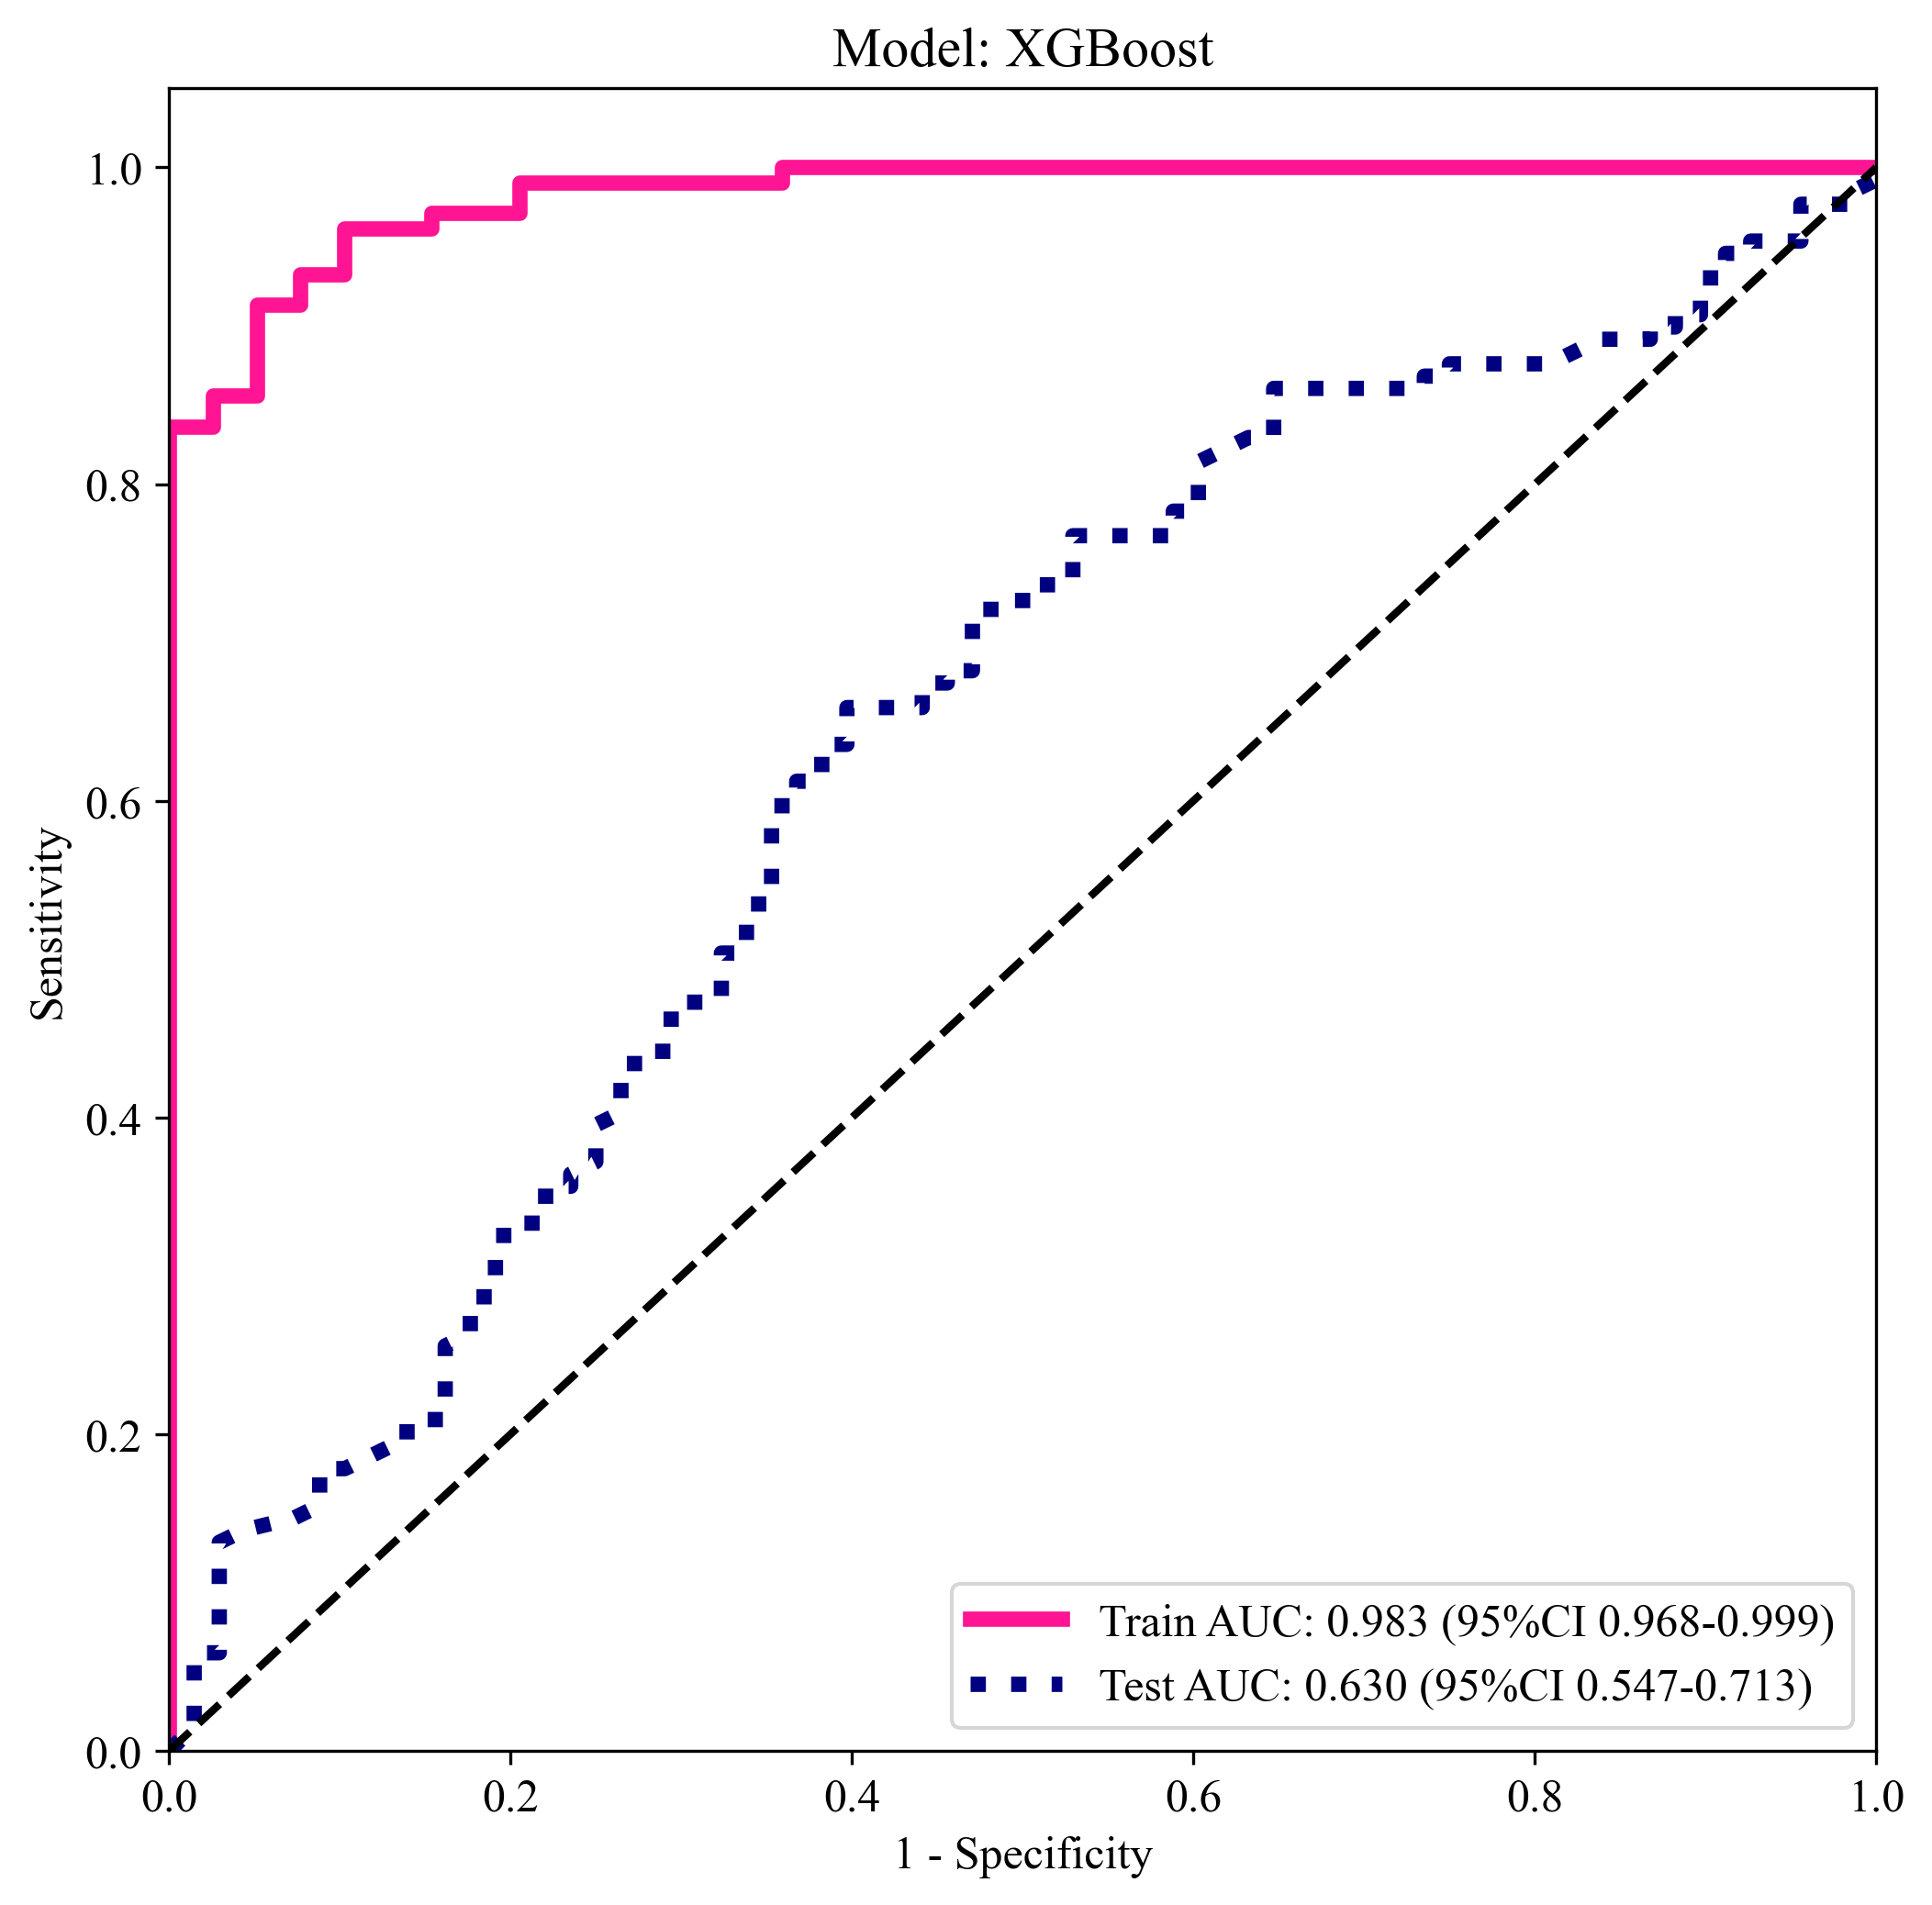

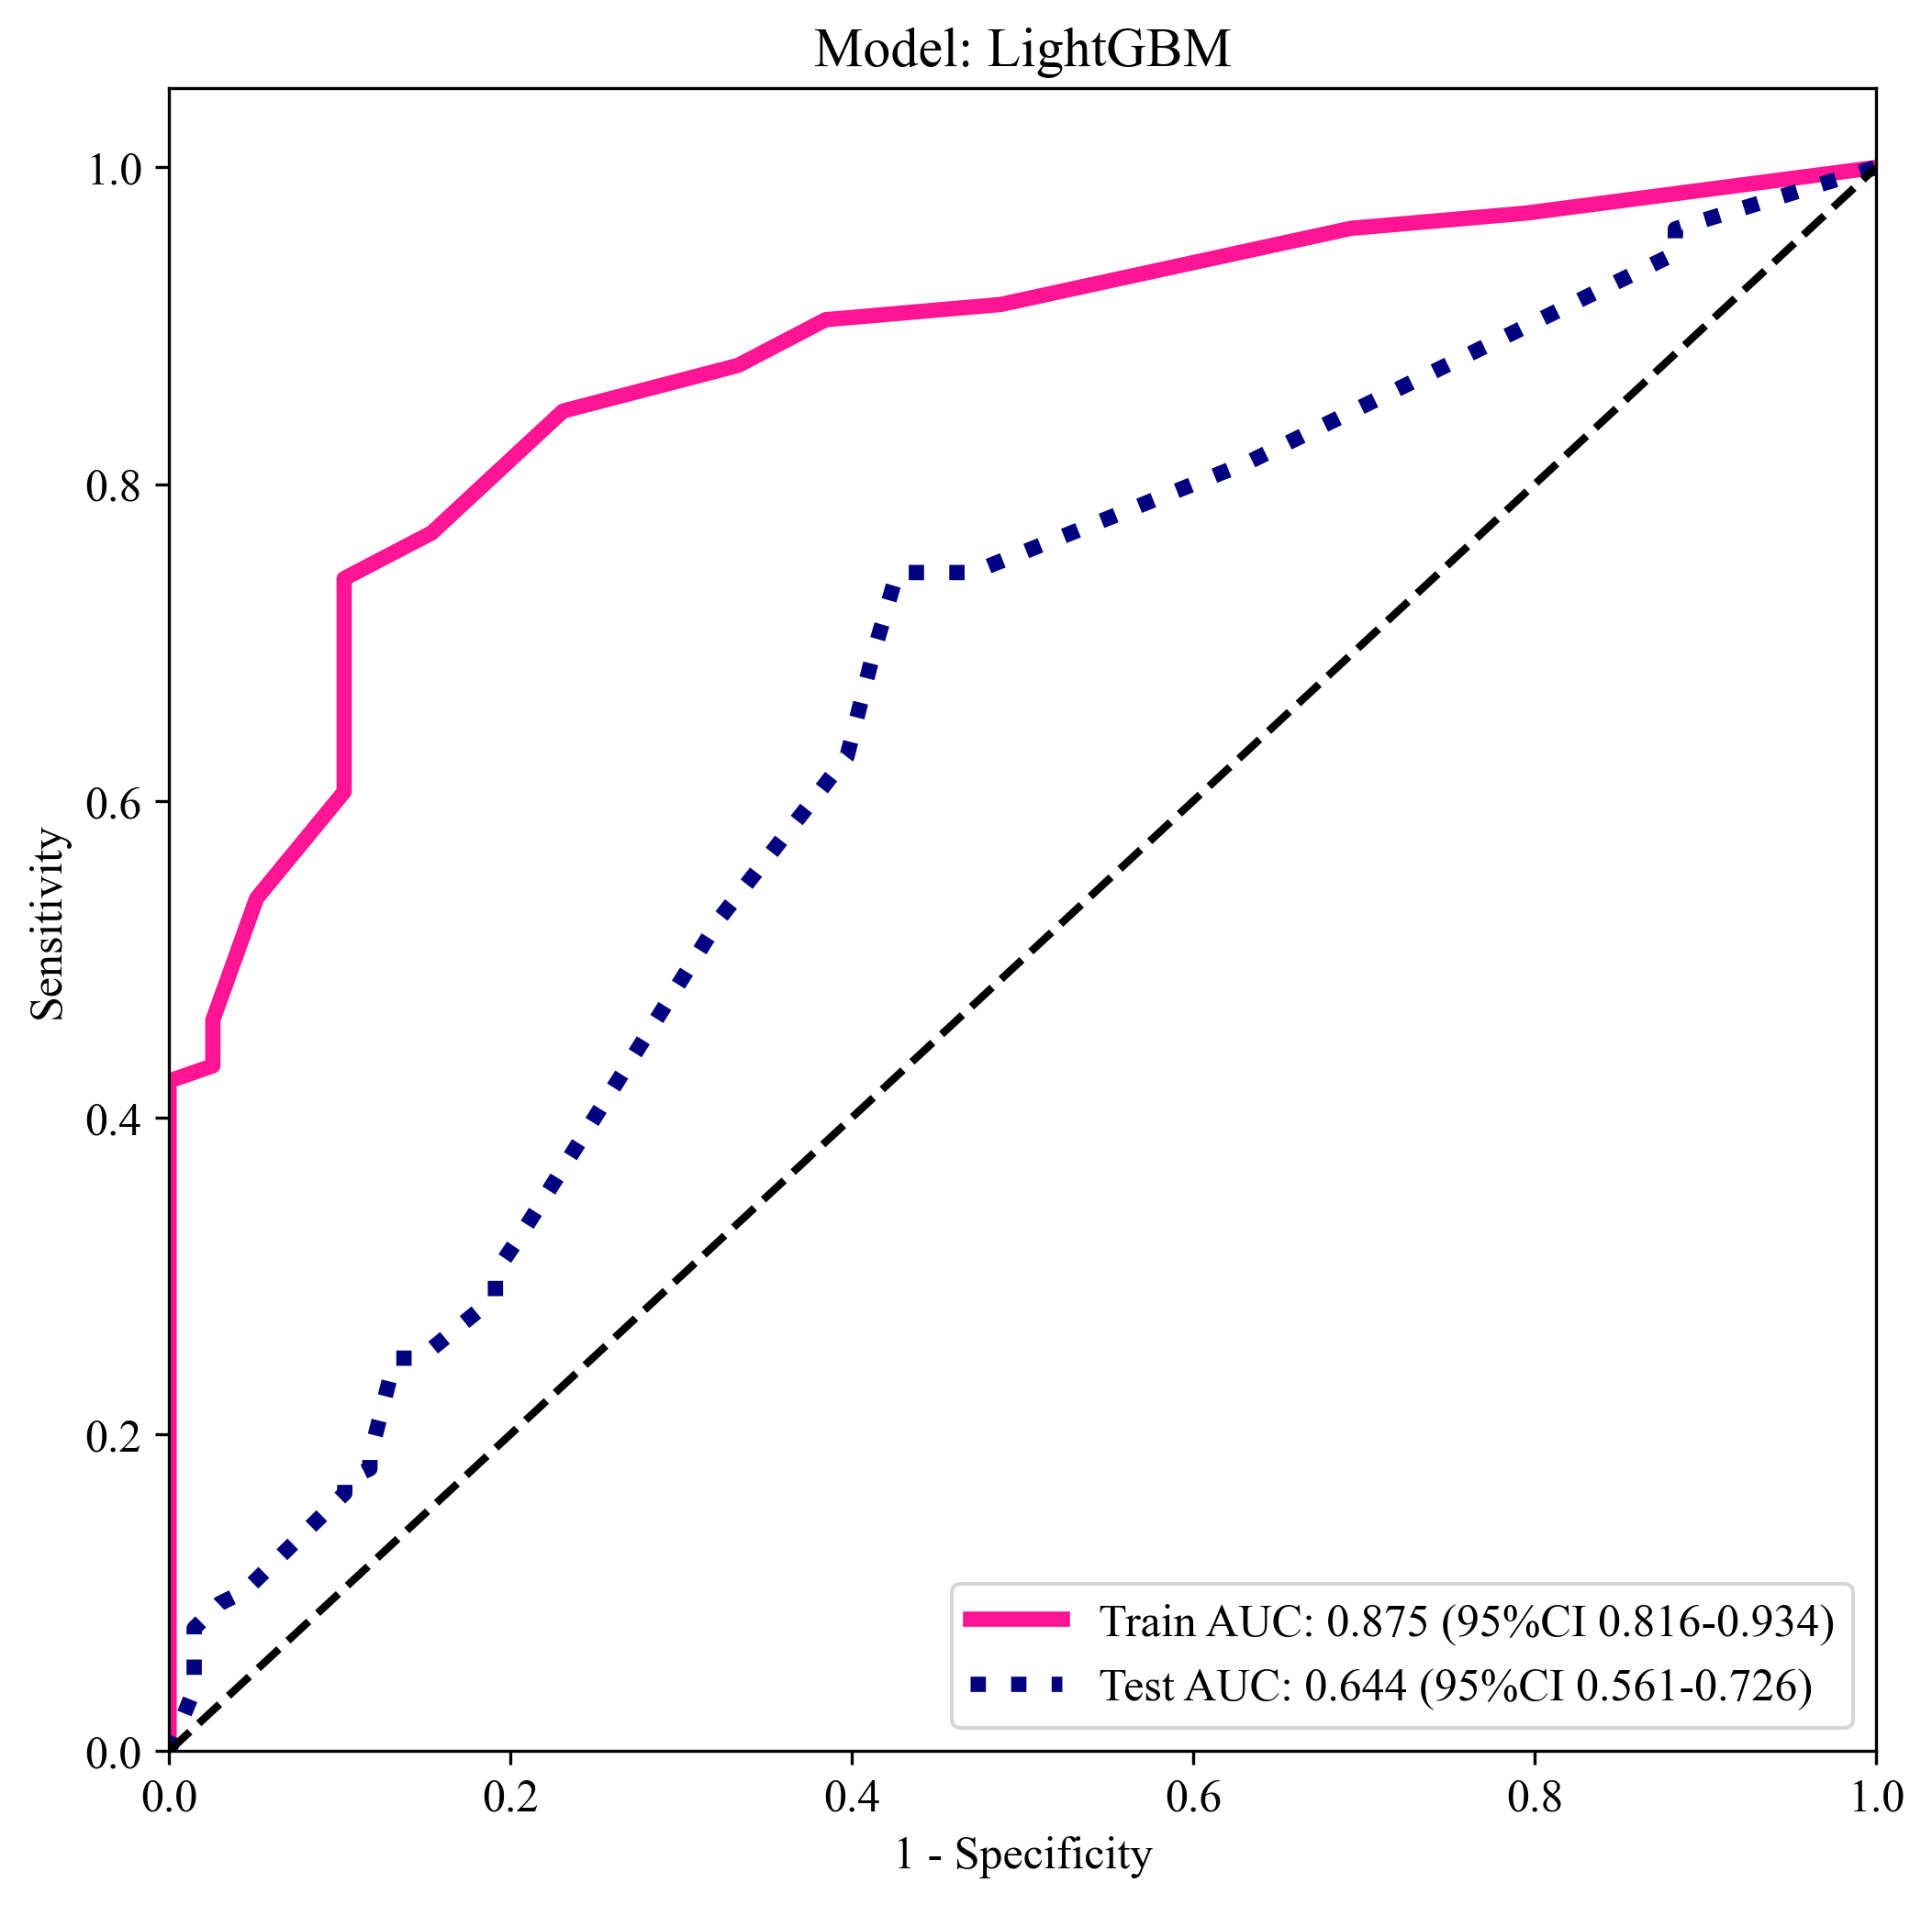

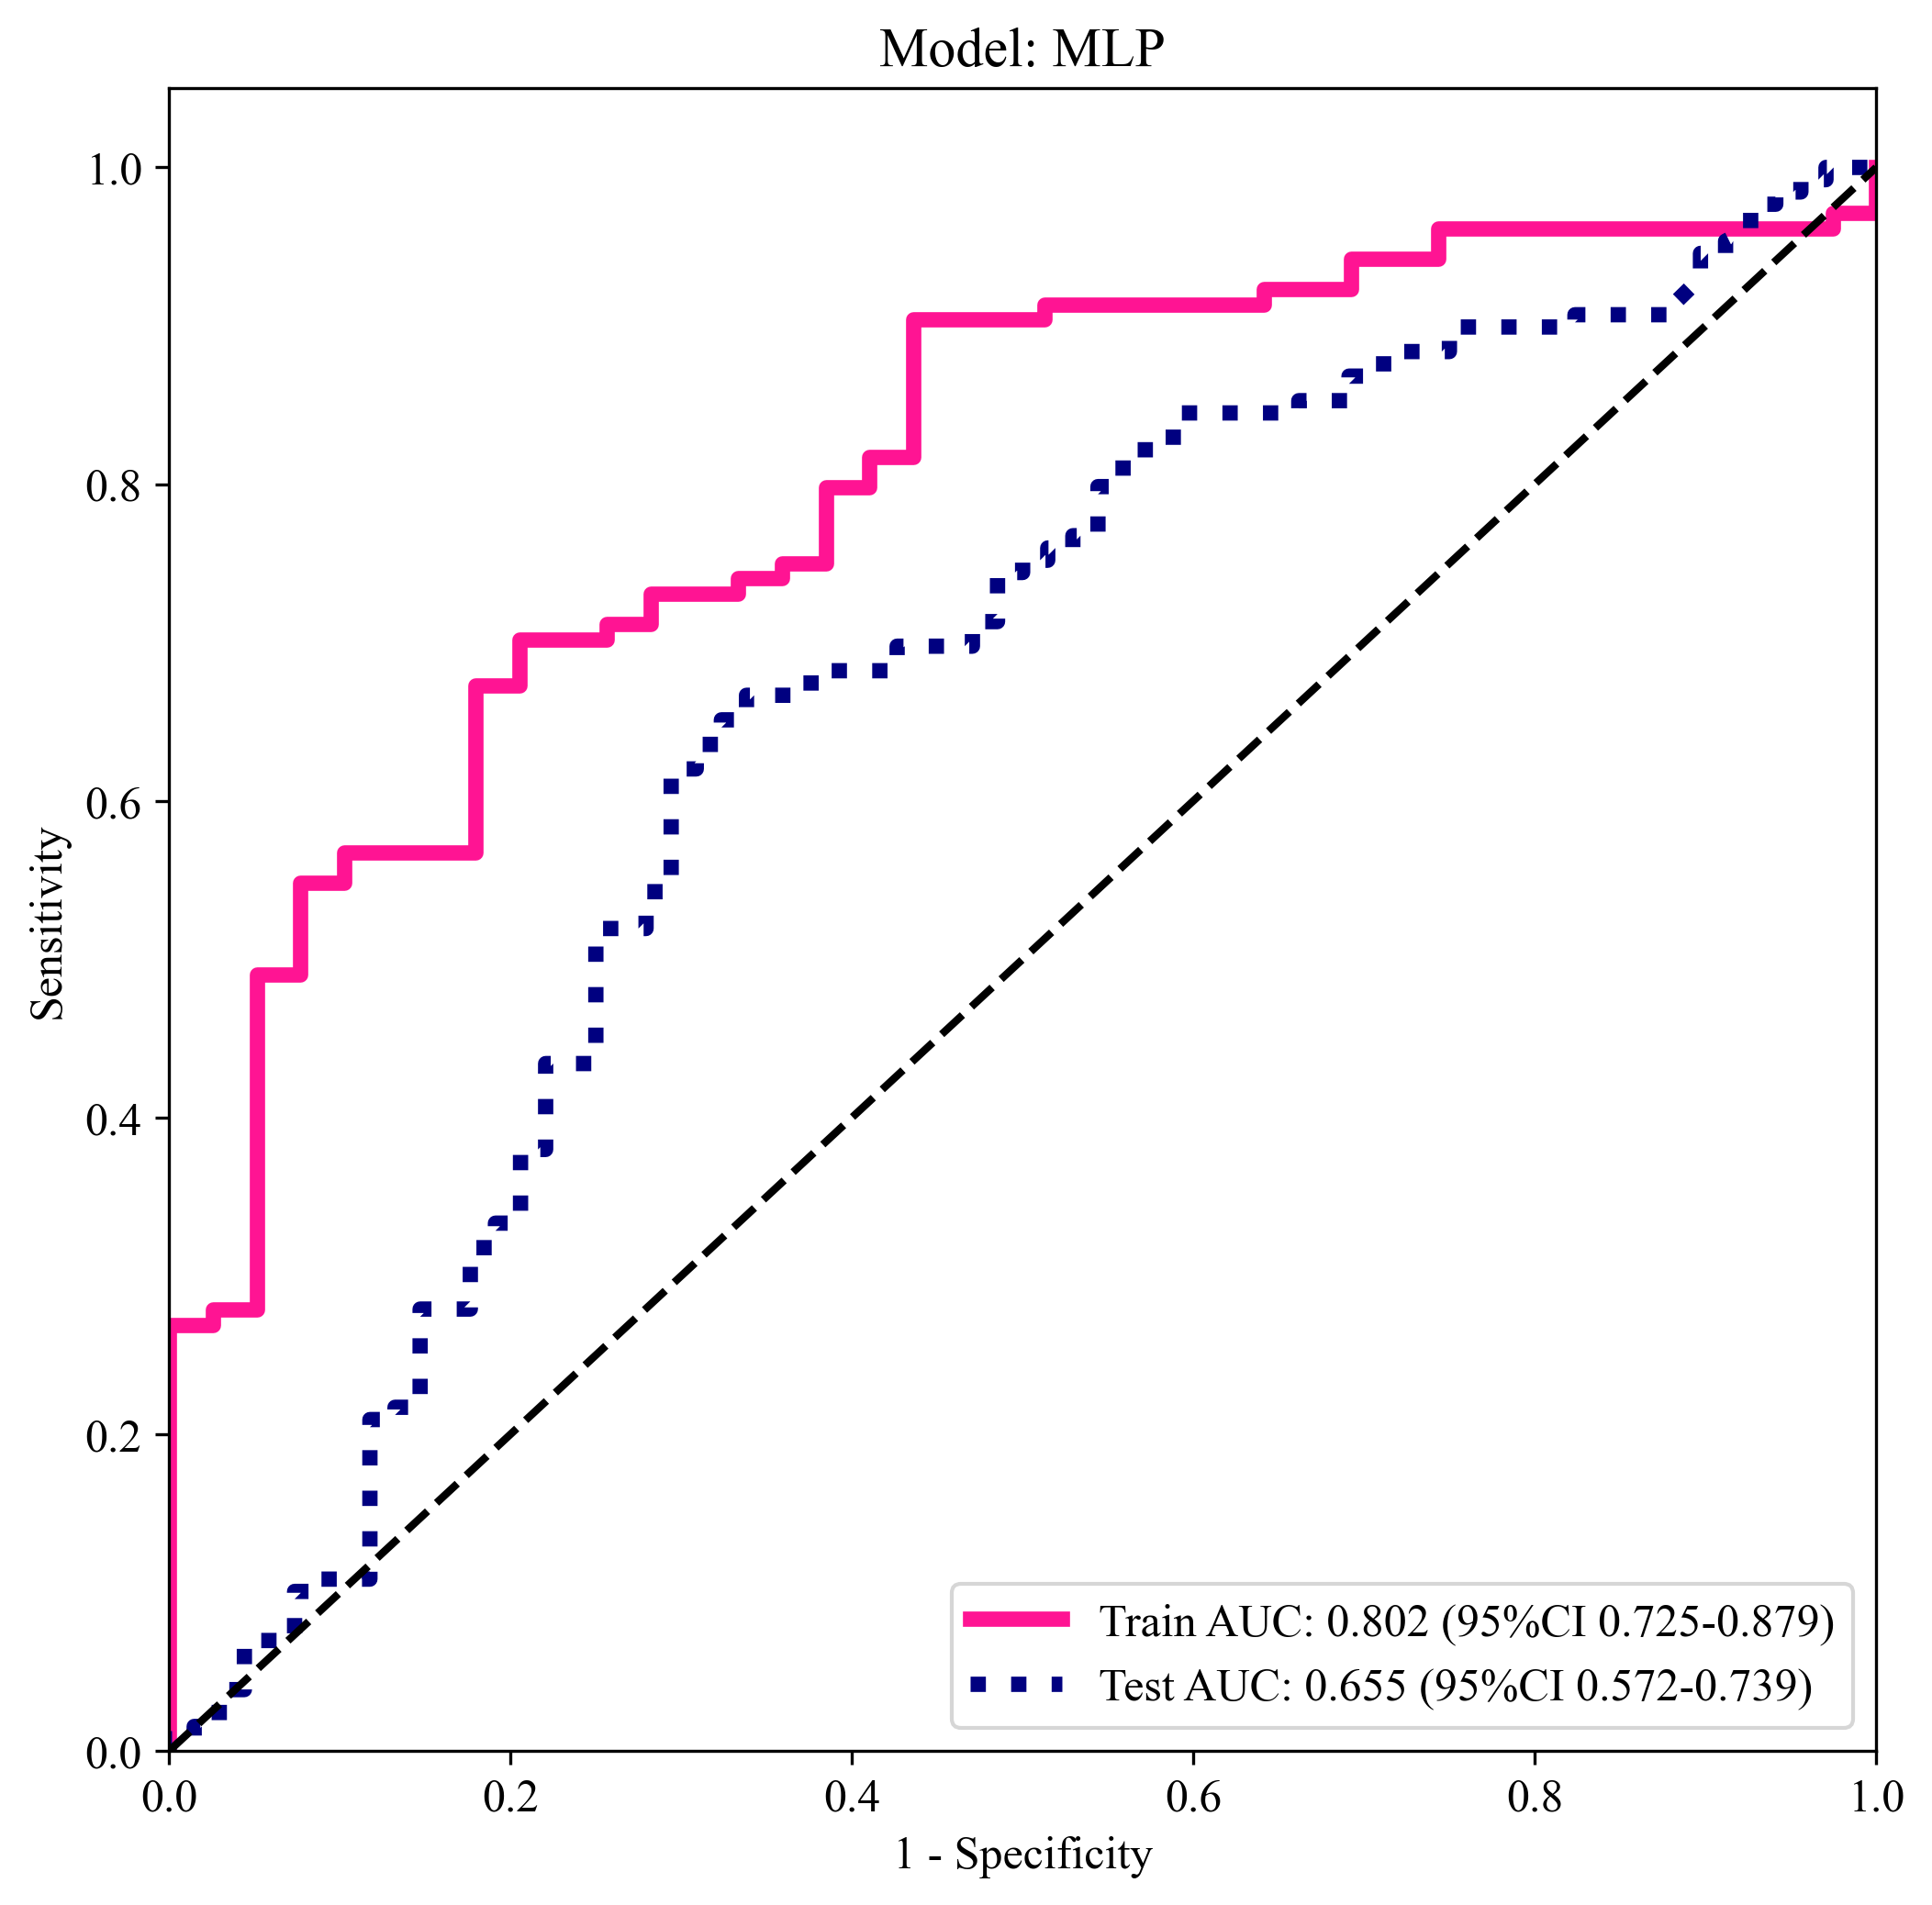

In [13]:
sel_model = model_names

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
    
        # Plot all ROC curves
        plt.figure(figsize=(8, 8))
        for pred_score, label in zip(pred_scores, labels):
            okcomp.comp1.draw_roc([np.array(y_train_sel[label]), np.array(y_test_sel[label])], 
                                  pred_score[sel_model_idx], 
                                  labels=['Train', 'Test'], title=f"Model: {sm}")
            plt.savefig(f'img/Clinic_model_{sm}_roc_label.svg', bbox_inches = 'tight')

### 汇总所有模型

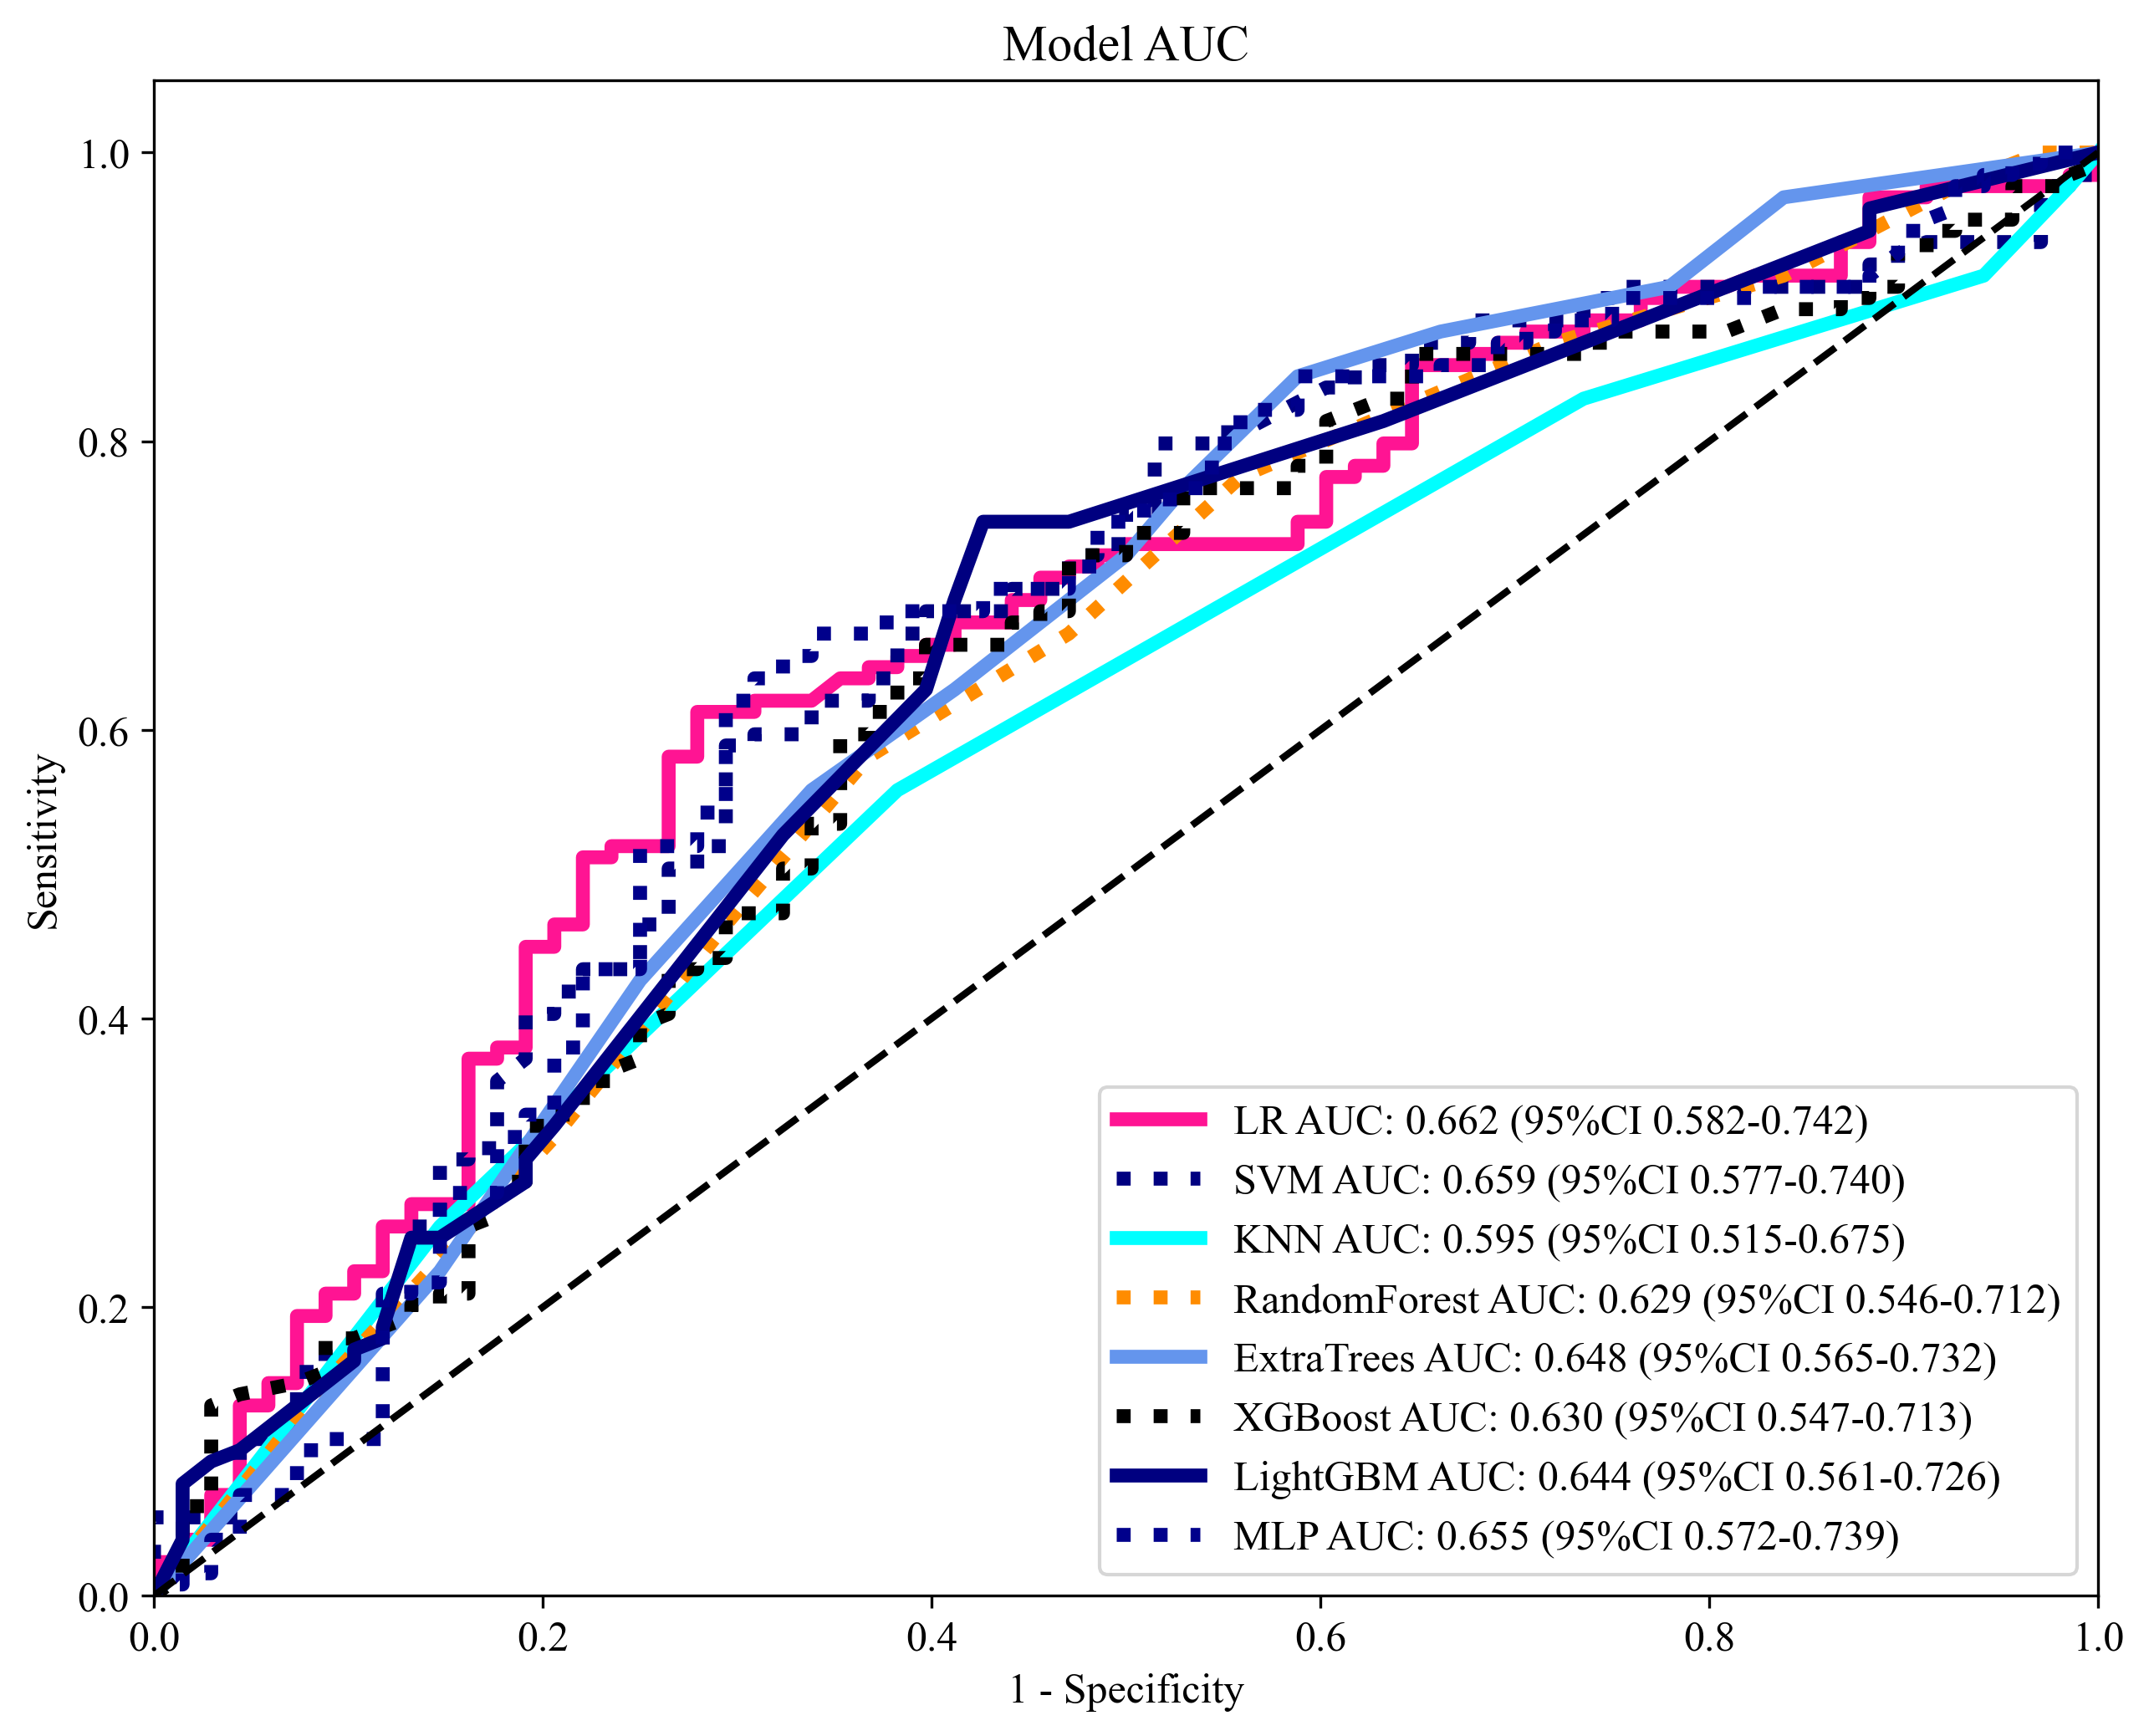

In [14]:
sel_model = model_names

for pred_score, label in zip(pred_scores, labels):
    pred_test_scores = []
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            pred_test_scores.append(pred_score[sel_model_idx][1])
    okcomp.comp1.draw_roc([np.array(y_test_sel[label])] * len(pred_test_scores), 
                          pred_test_scores, 
                          labels=sel_model, title=f"Model AUC")
    plt.savefig(f'img/Clinic_model_roc.svg', bbox_inches = 'tight')

### DCA决策曲线

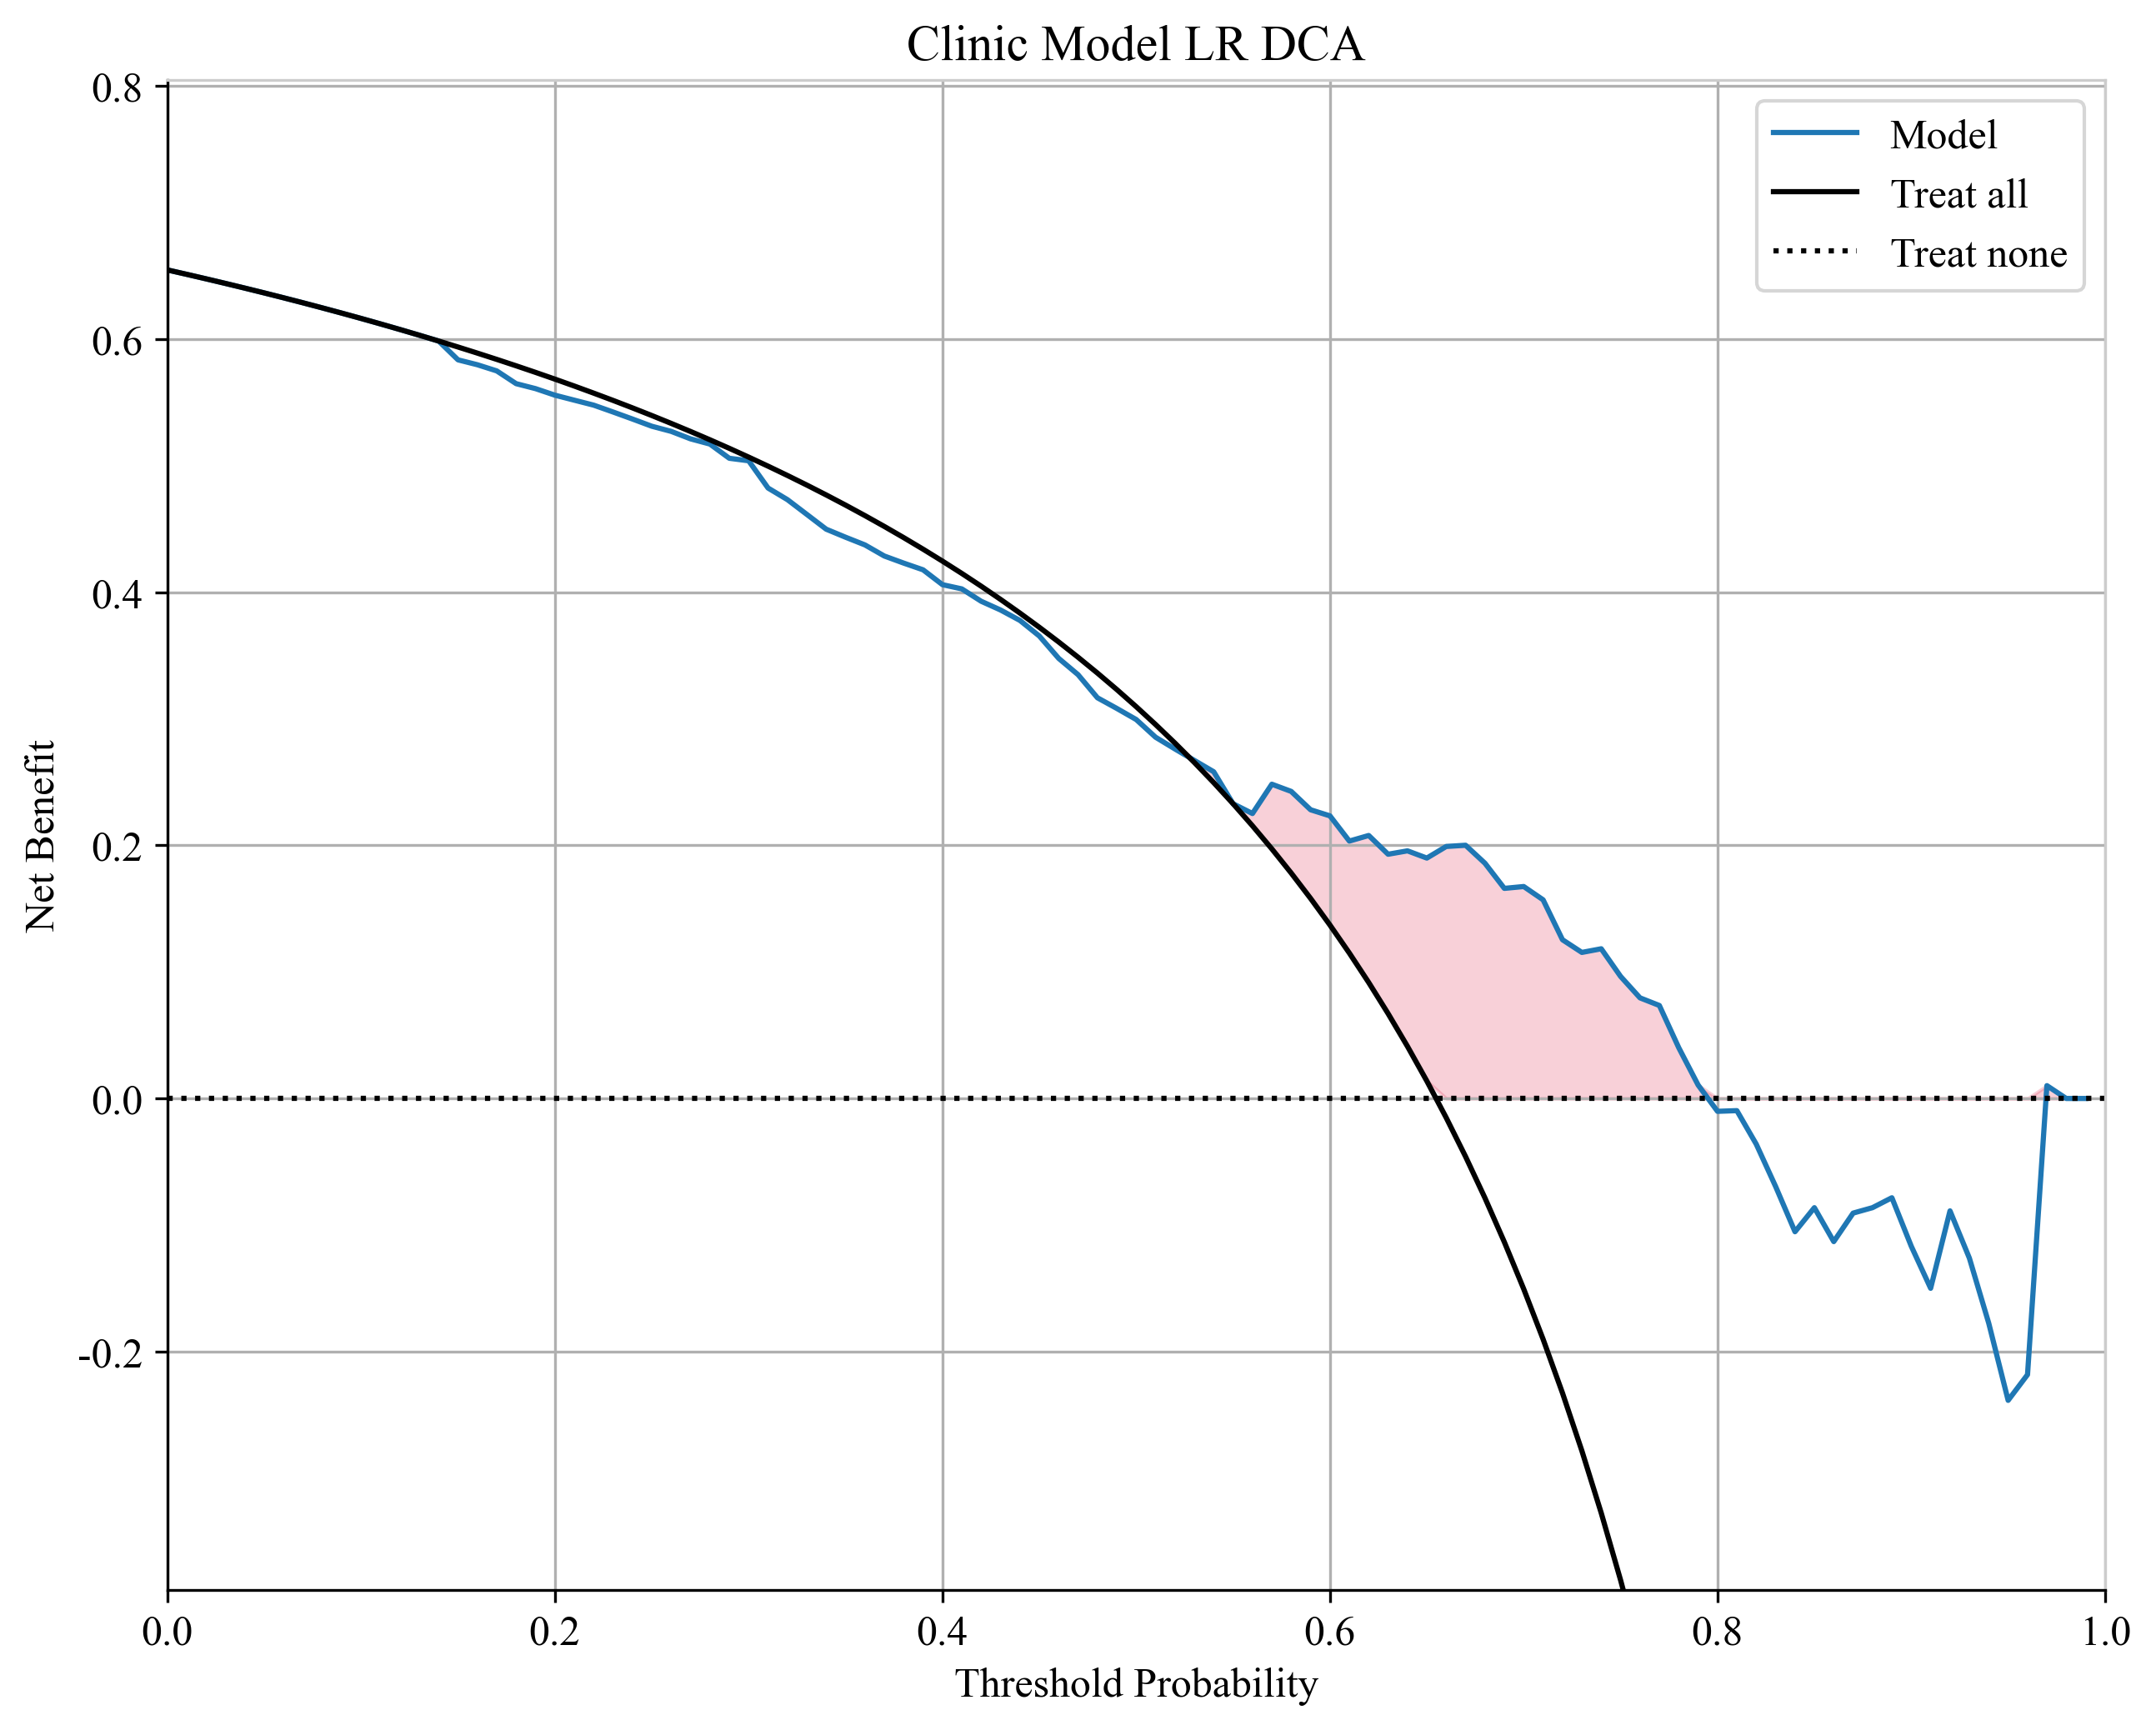

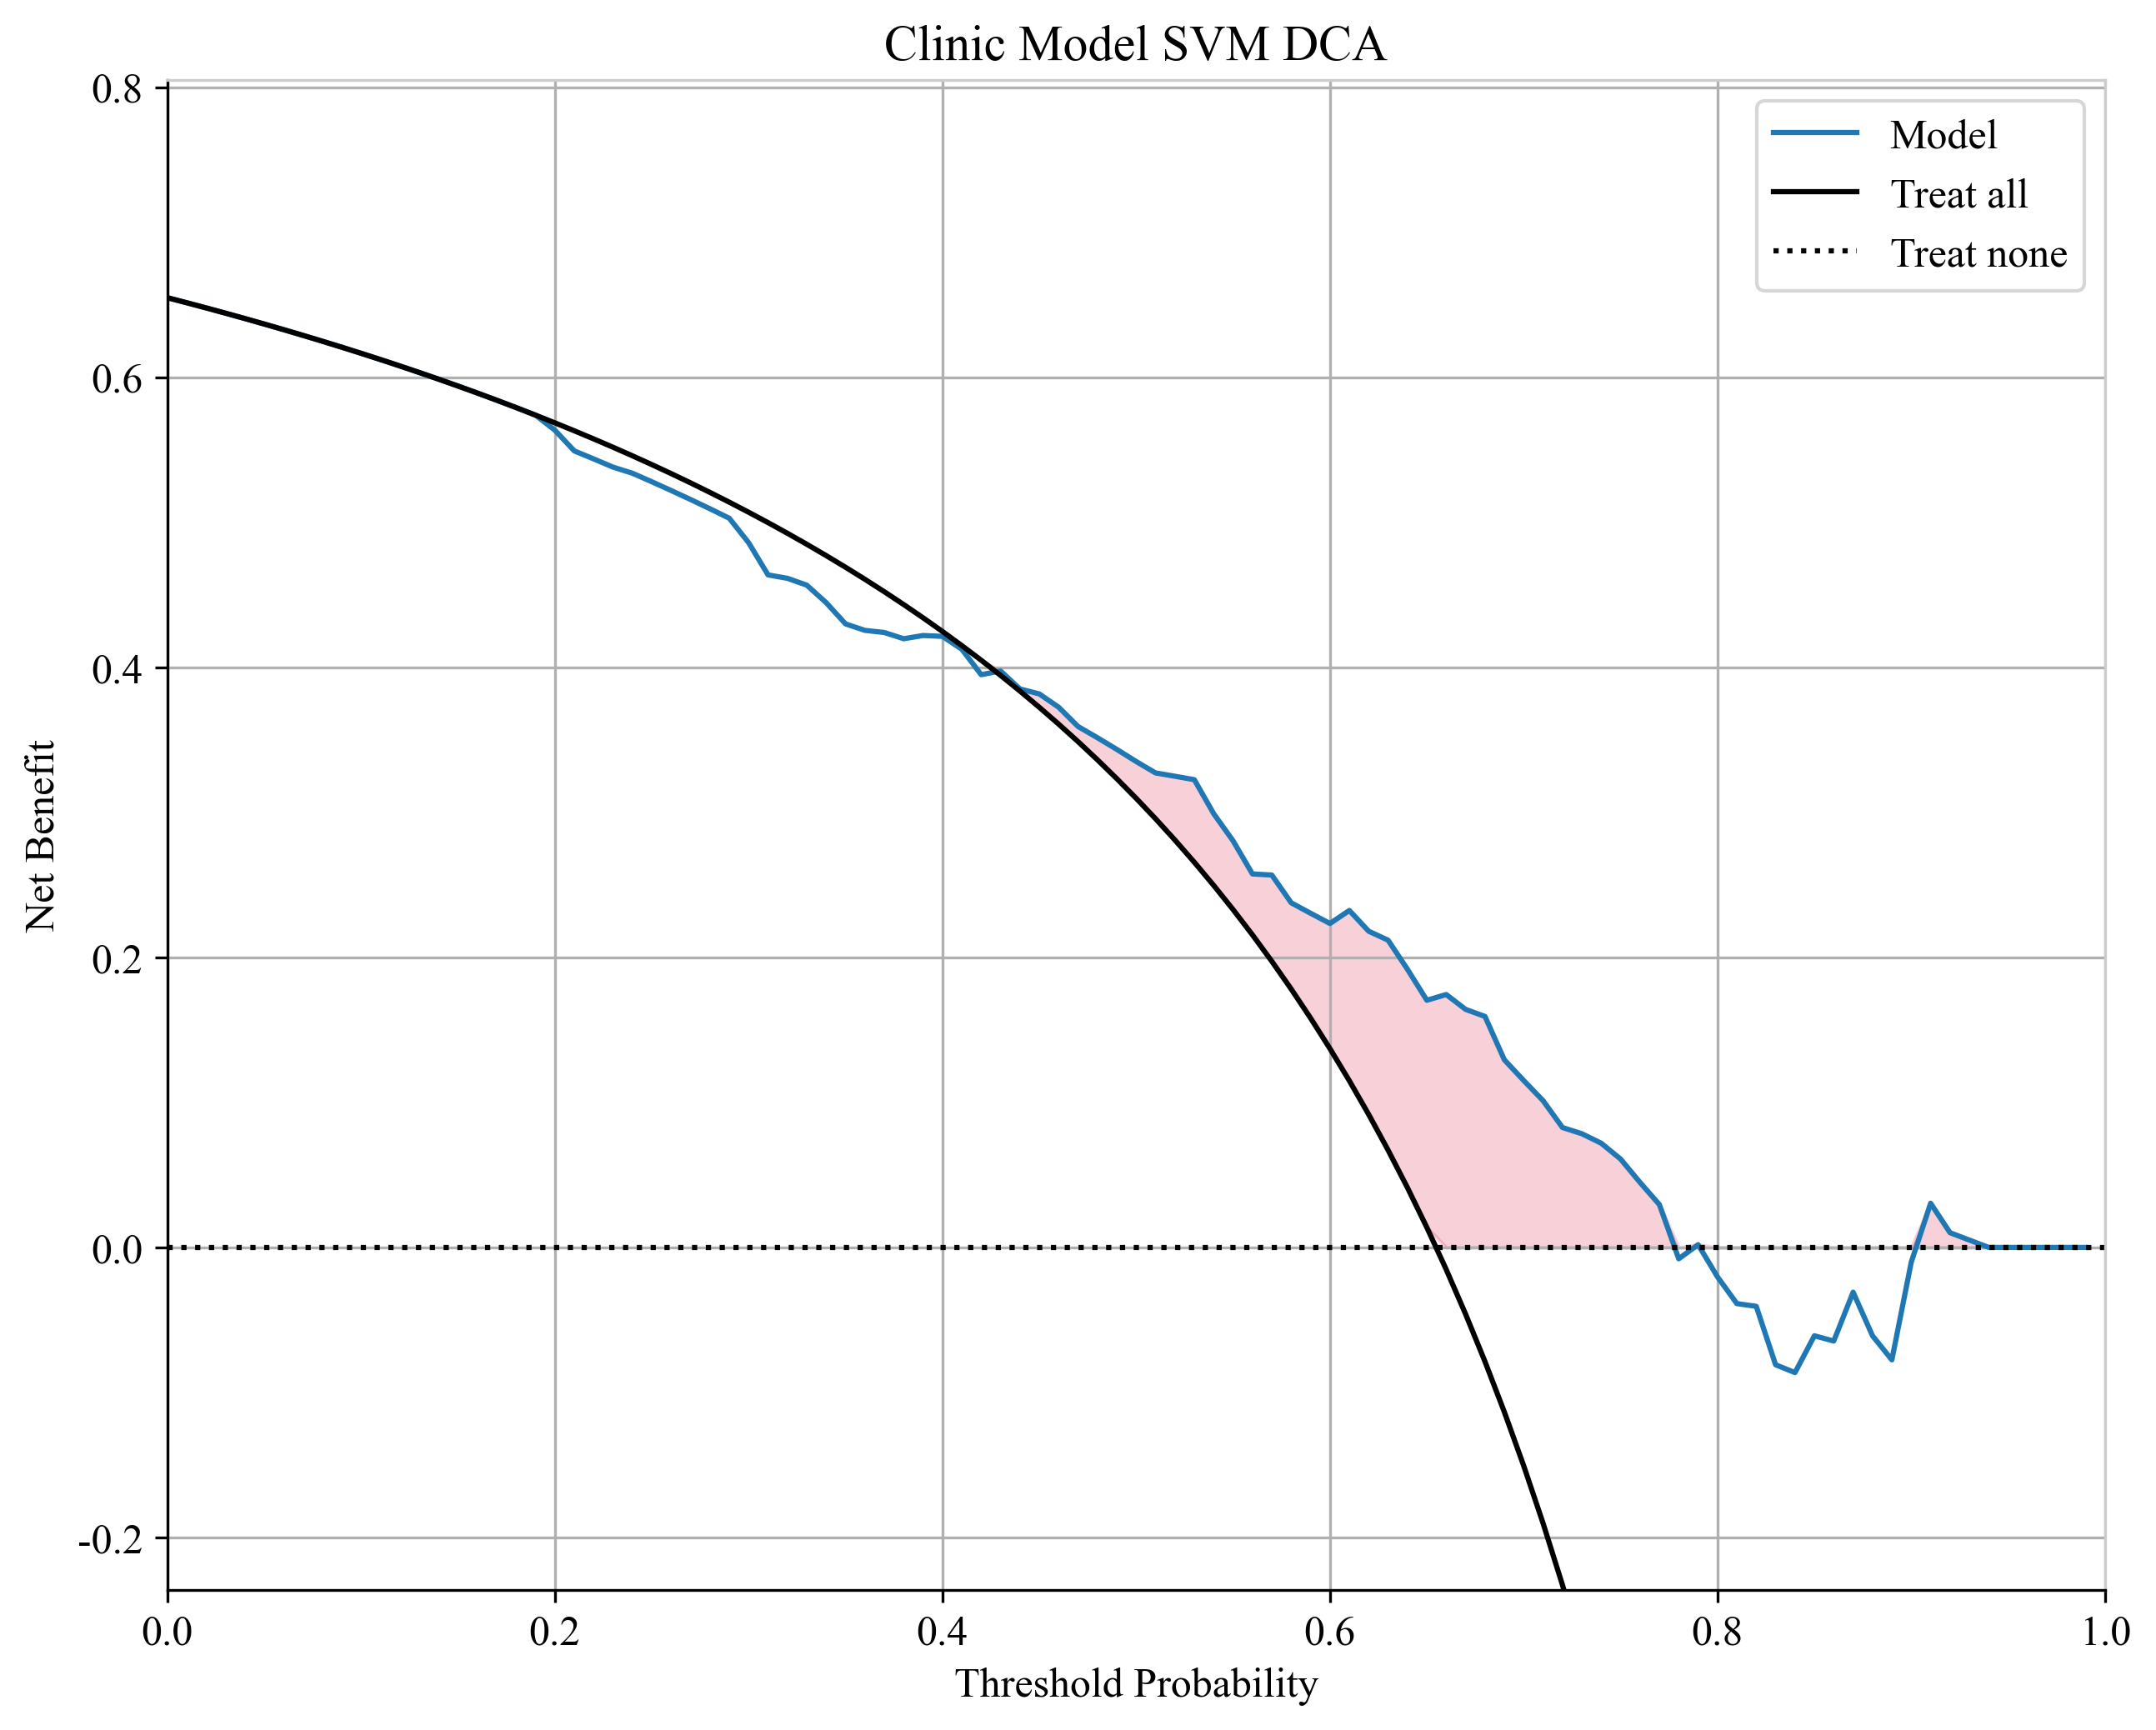

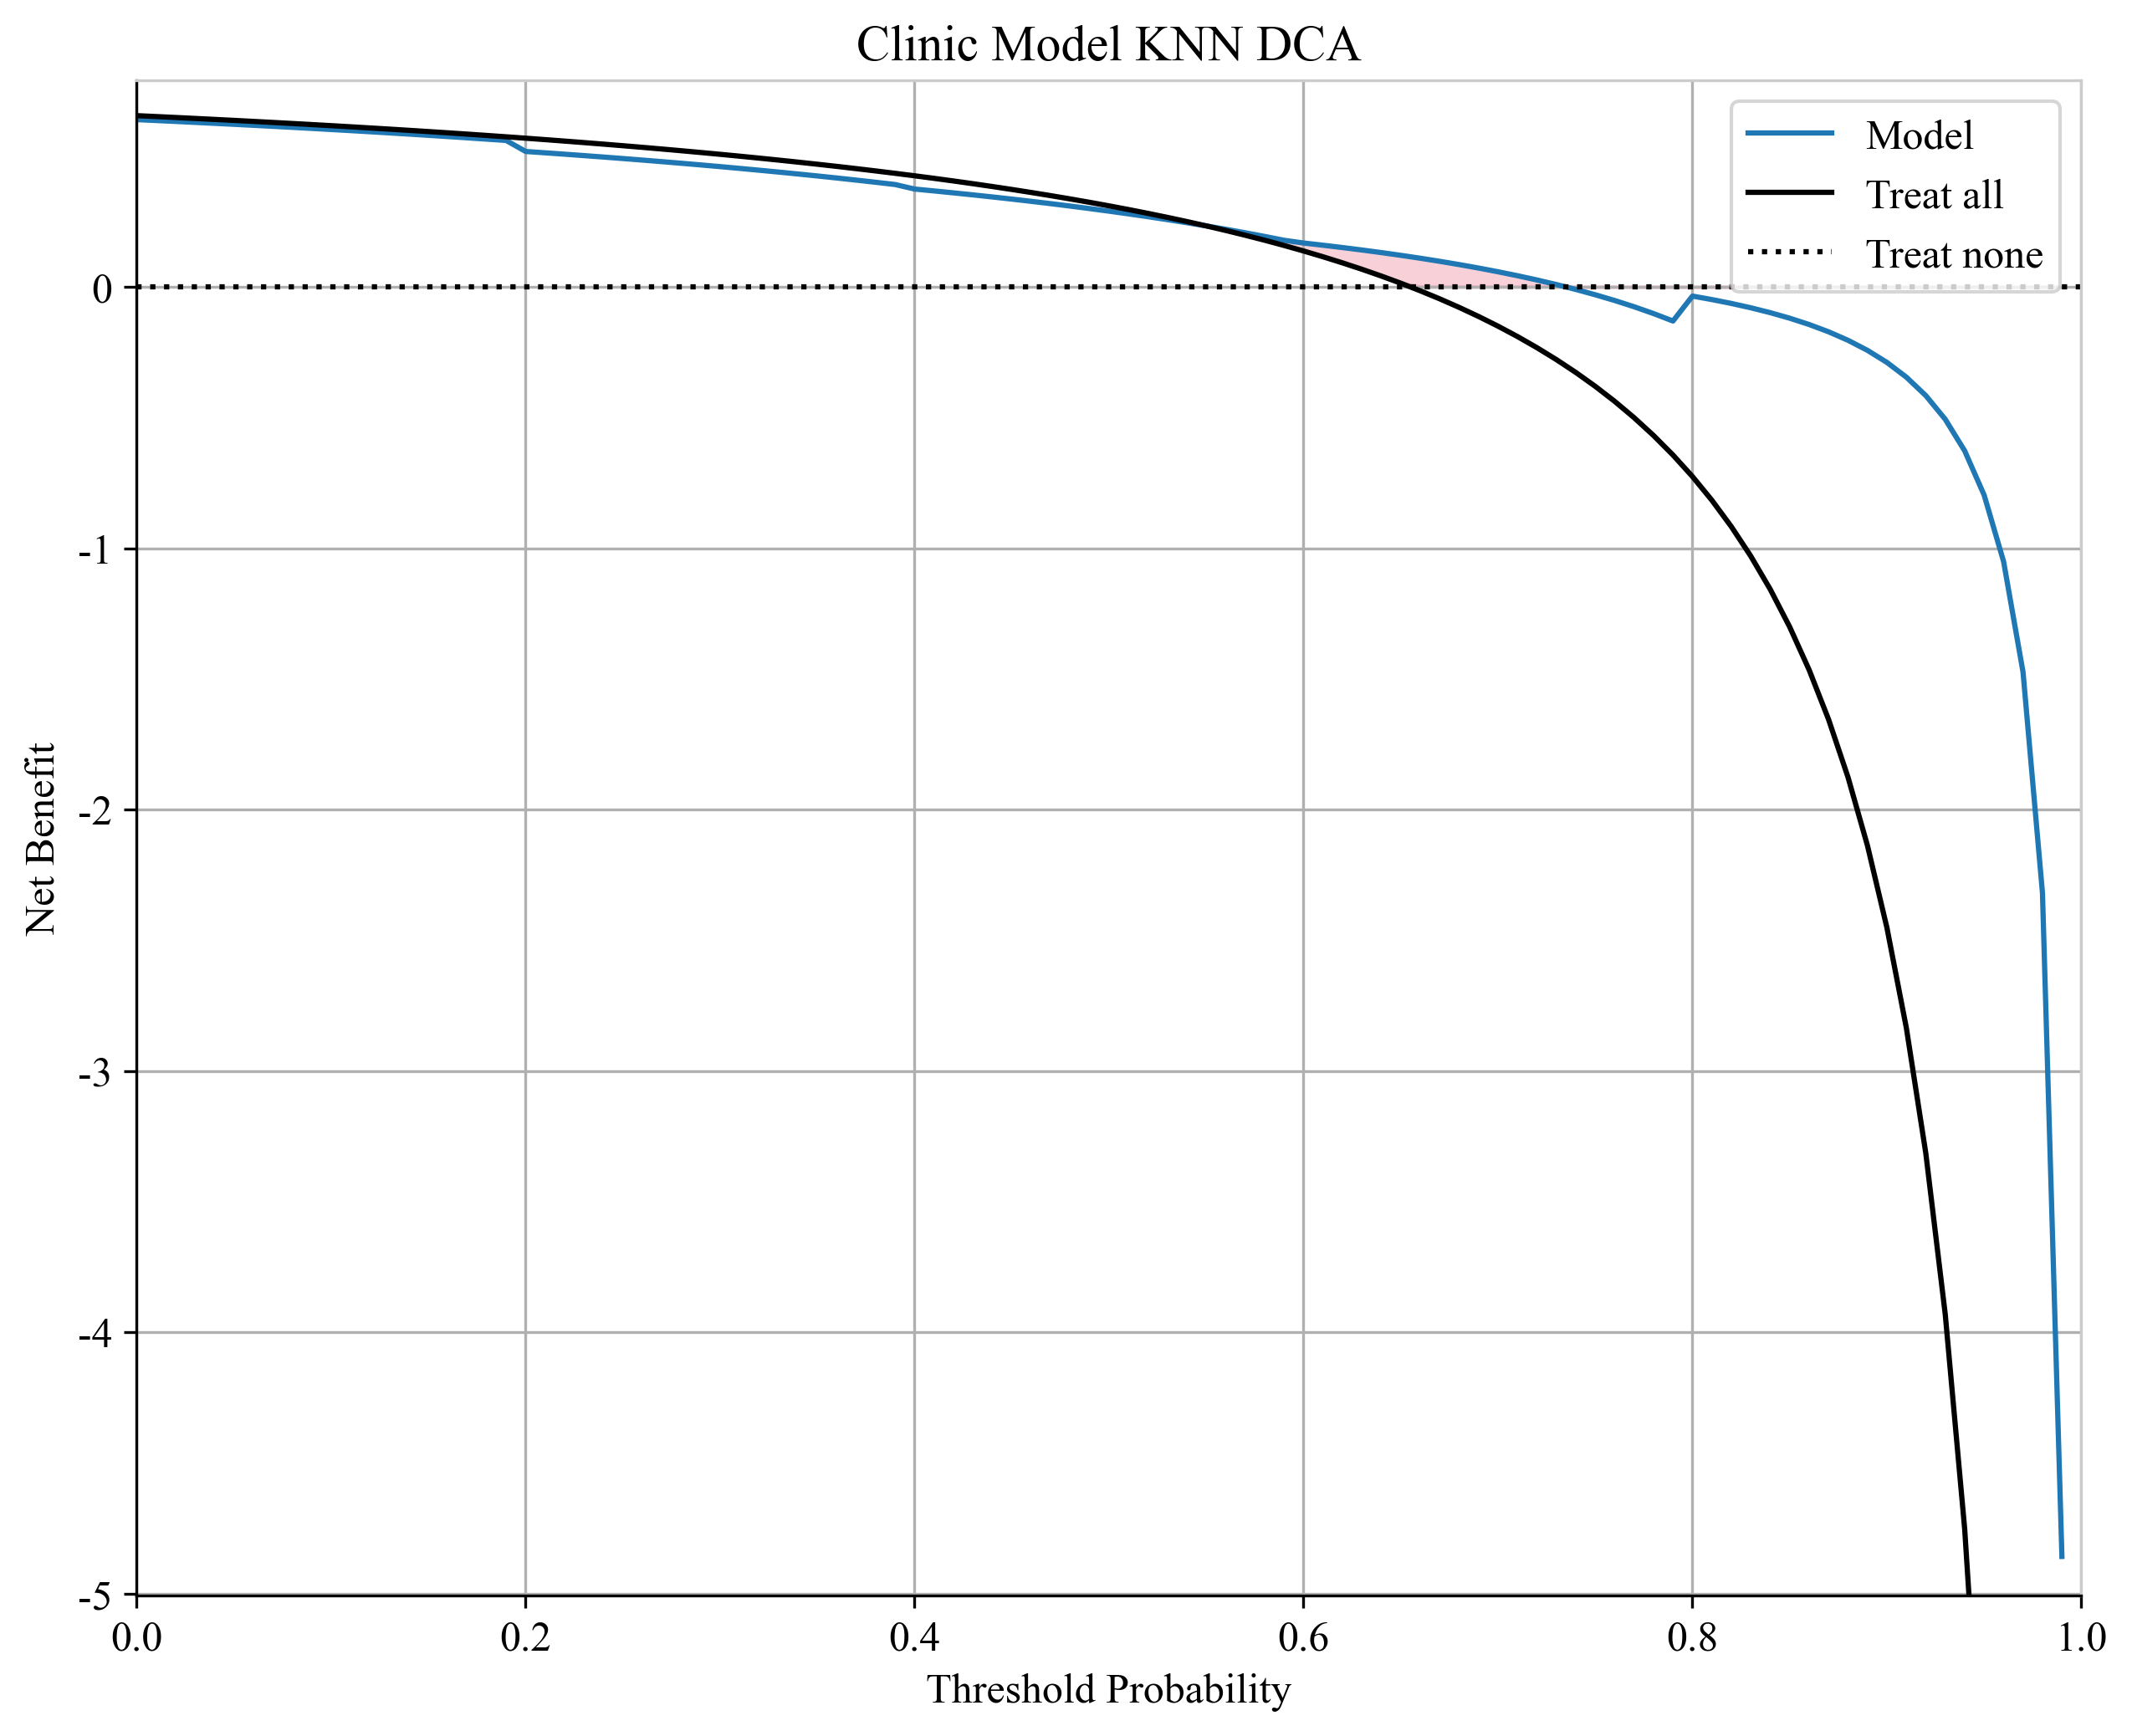

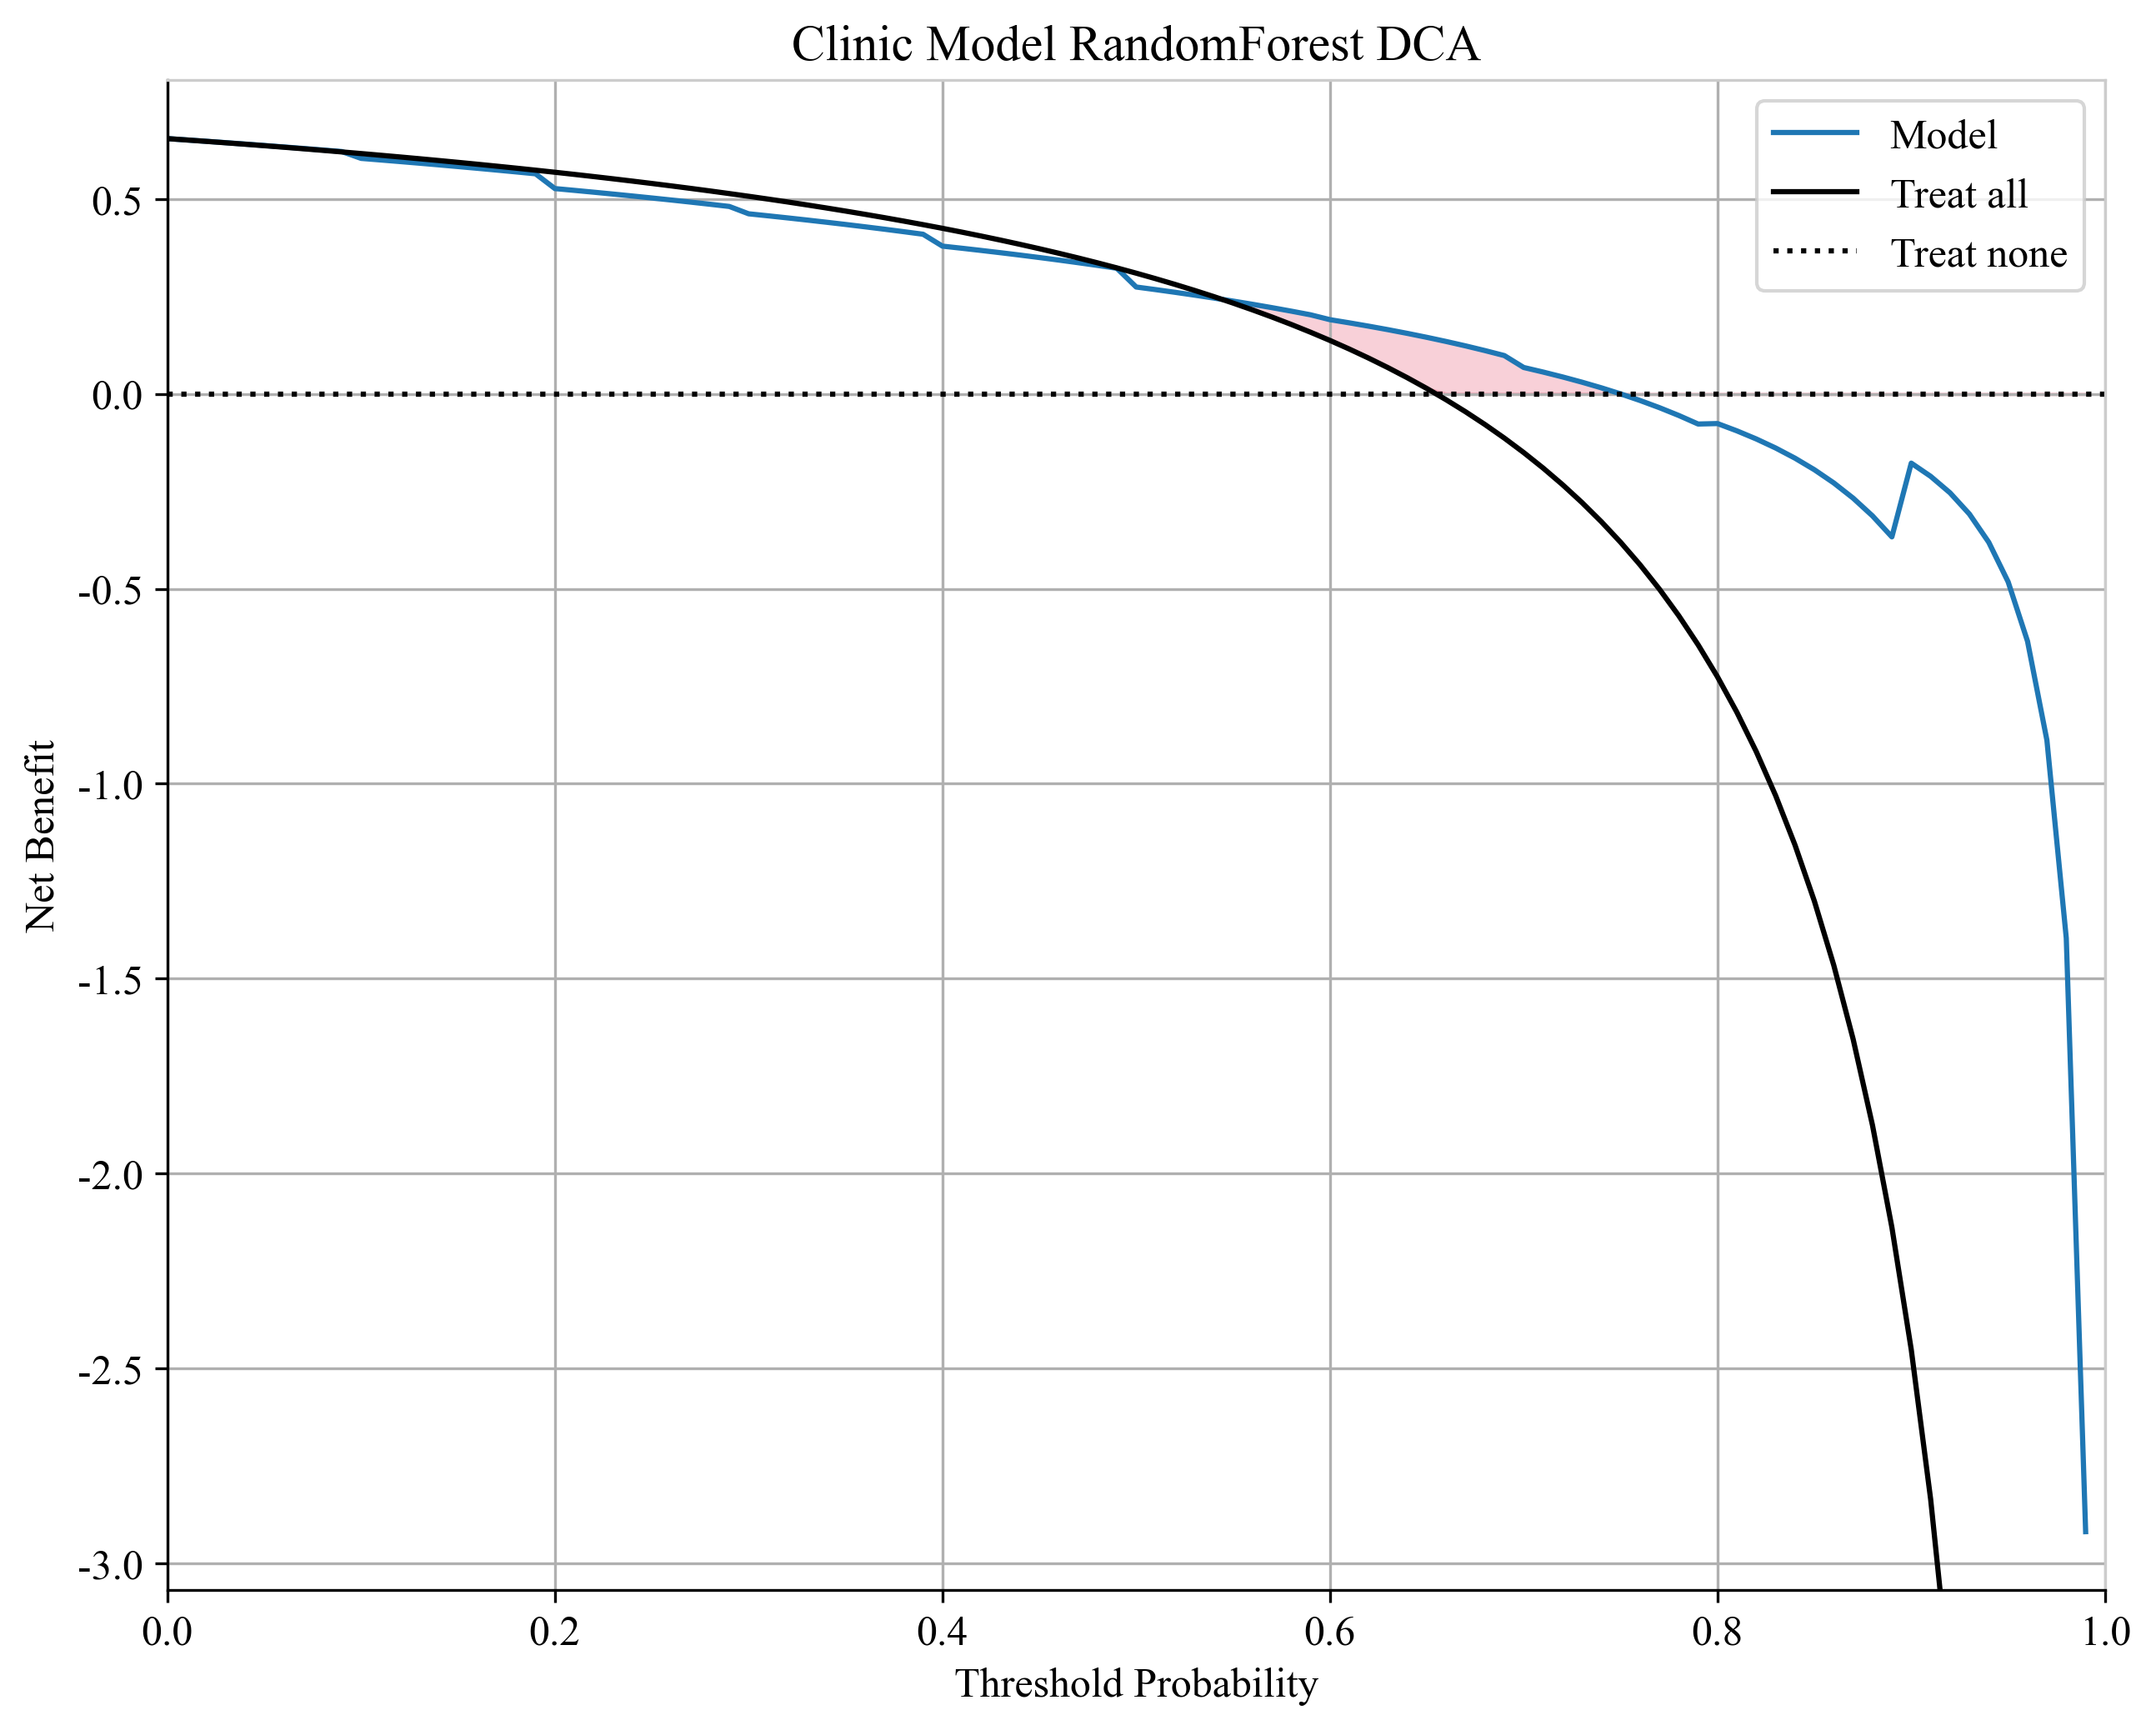

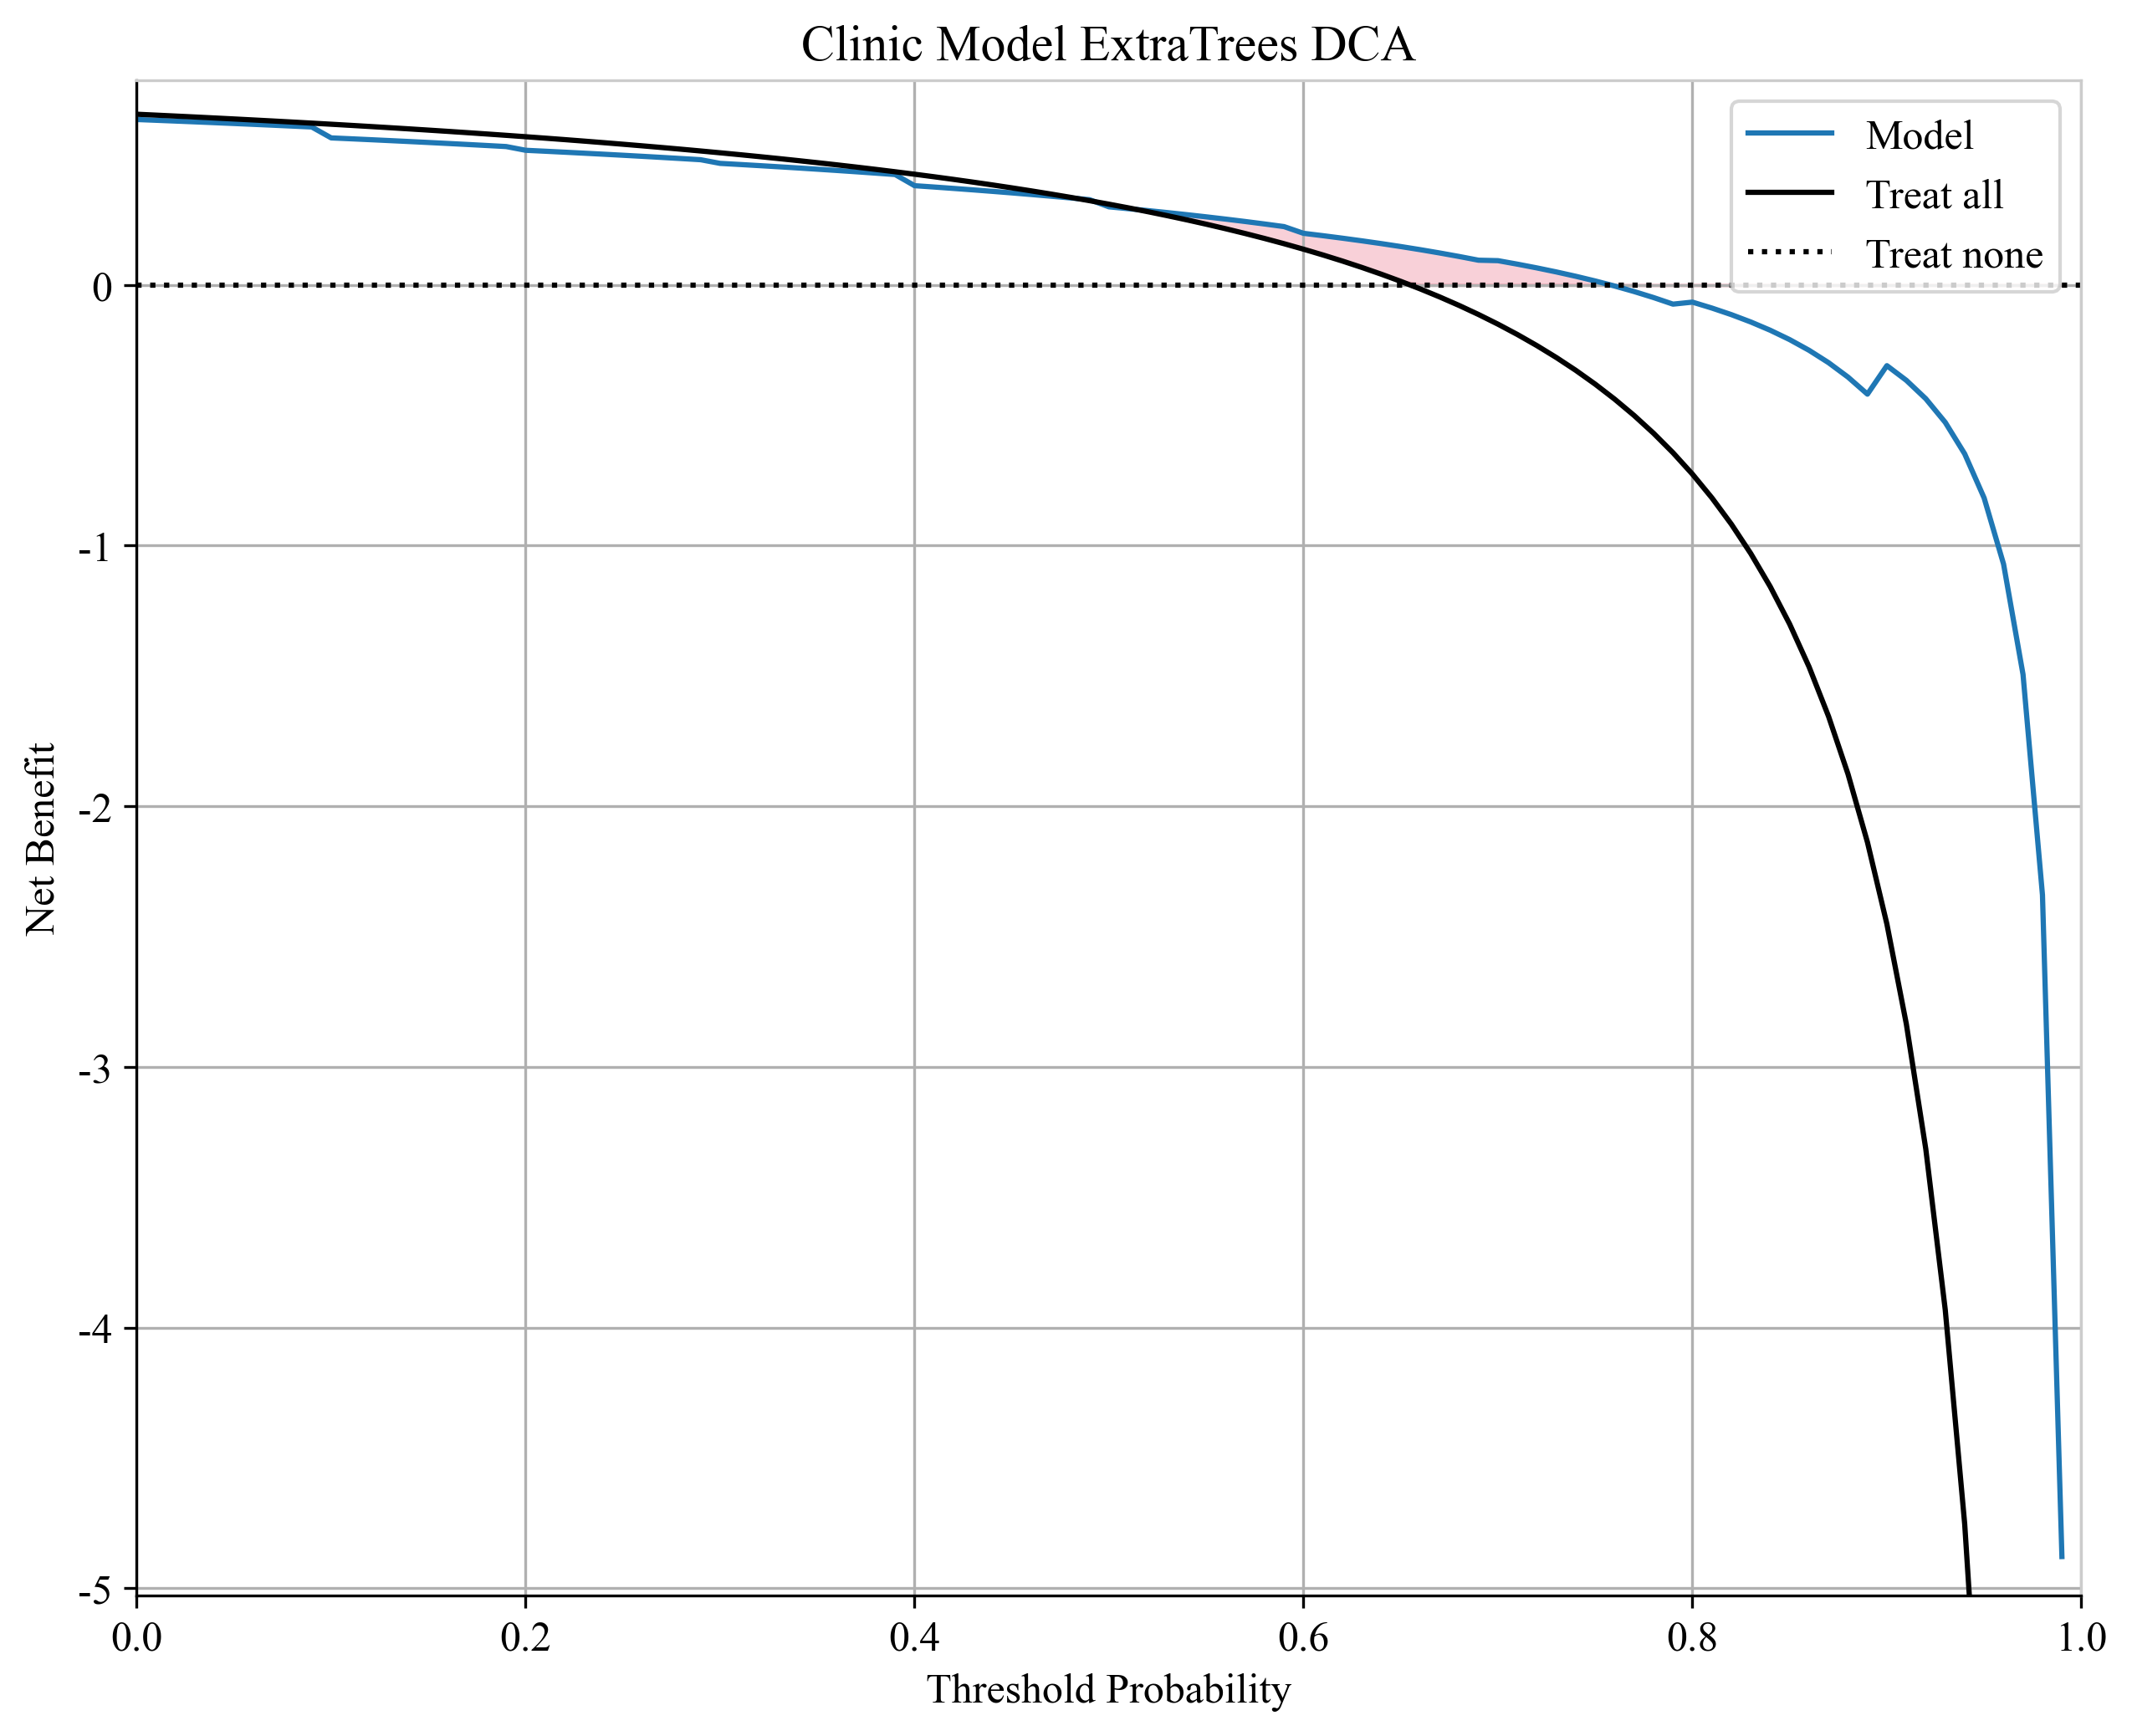

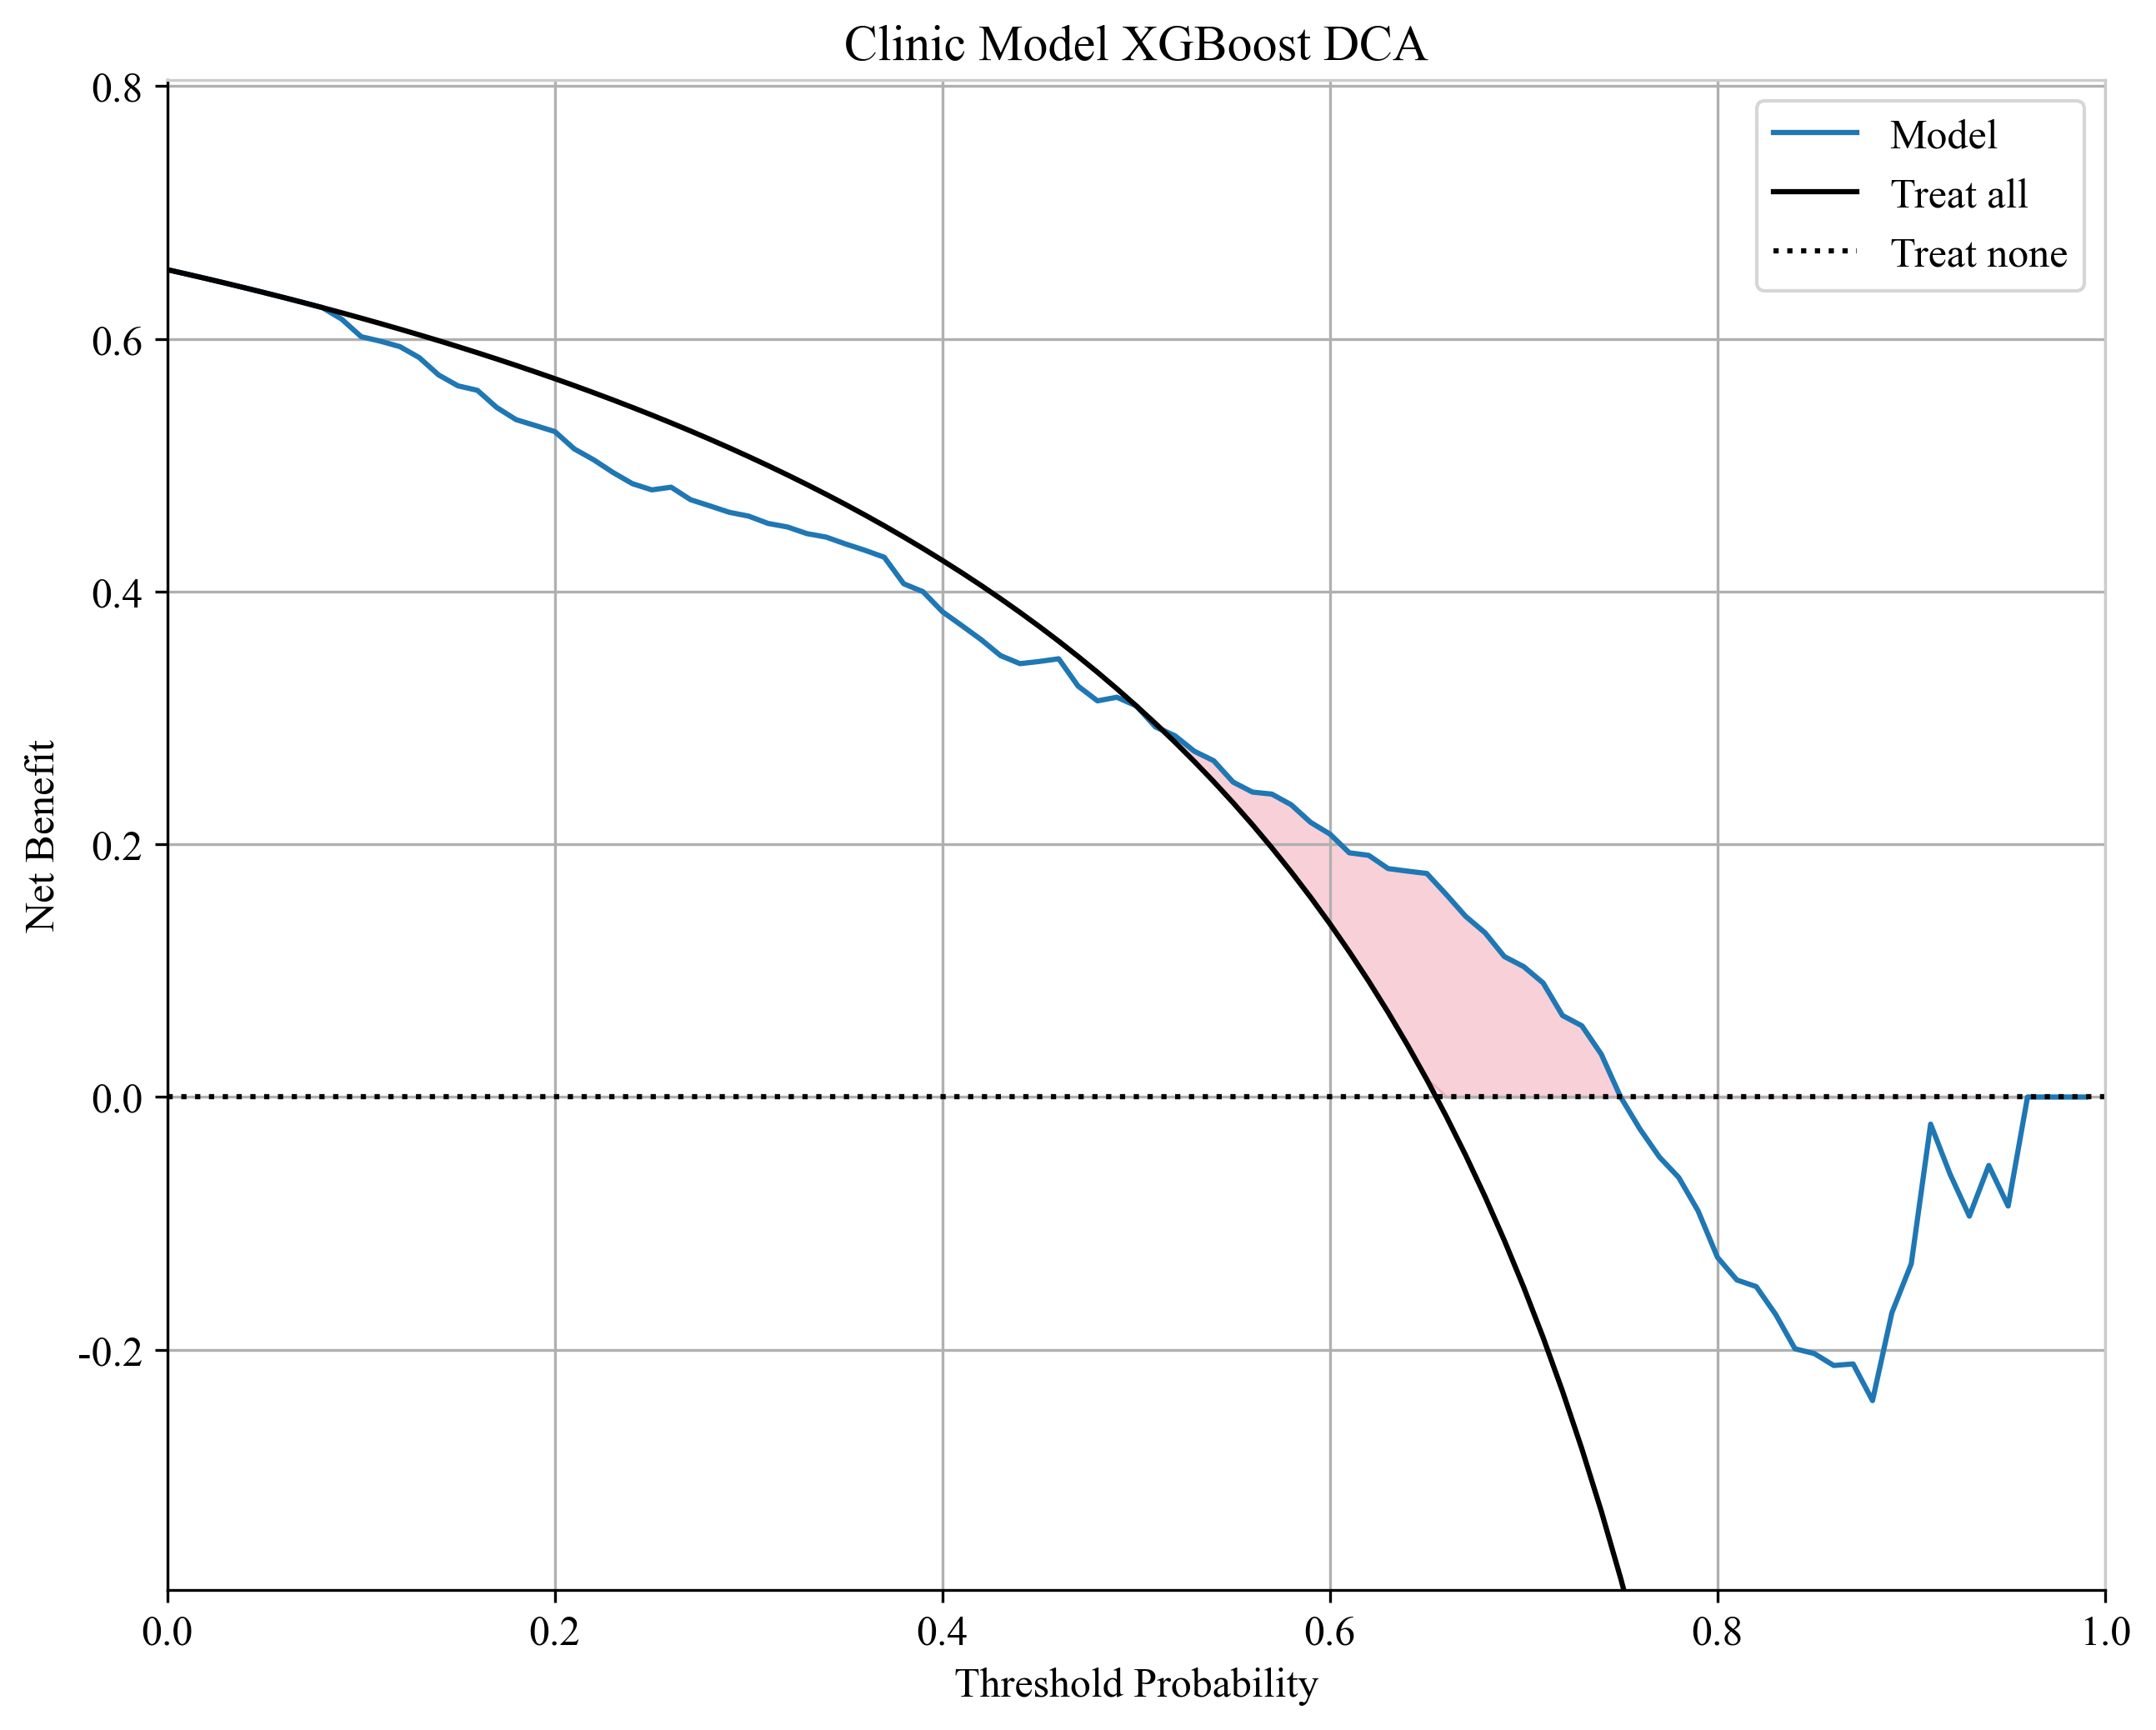

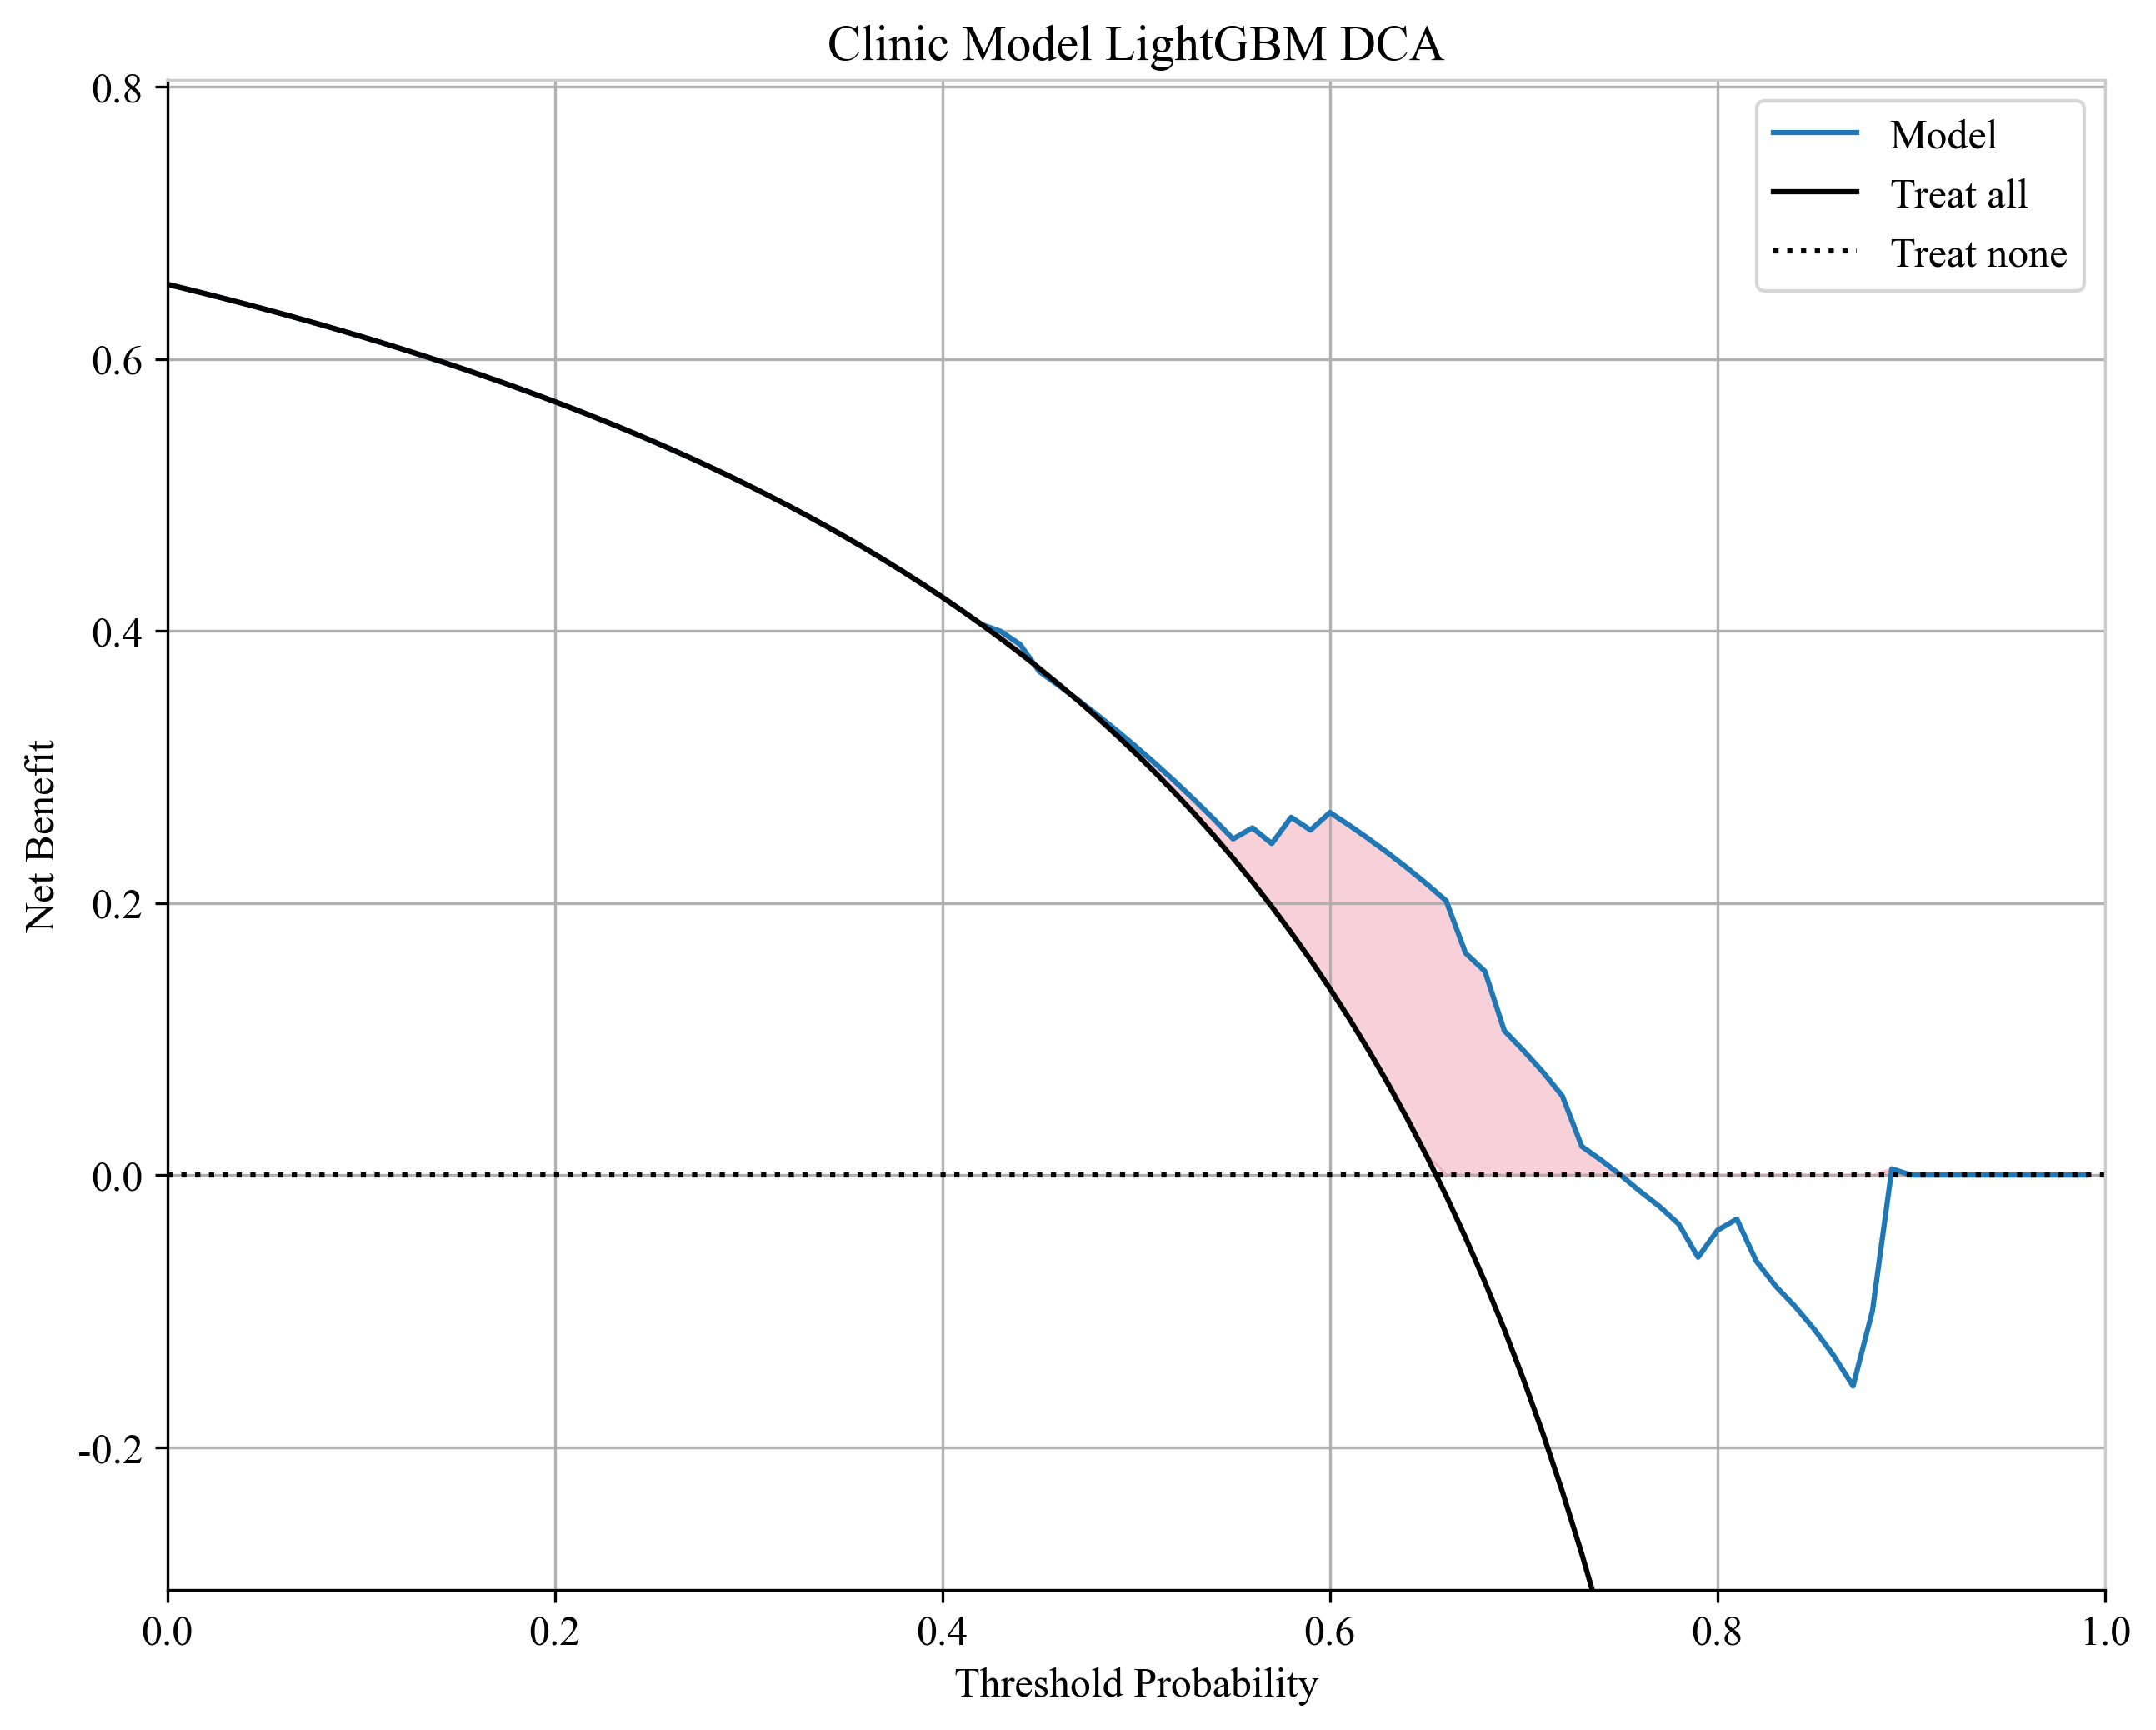

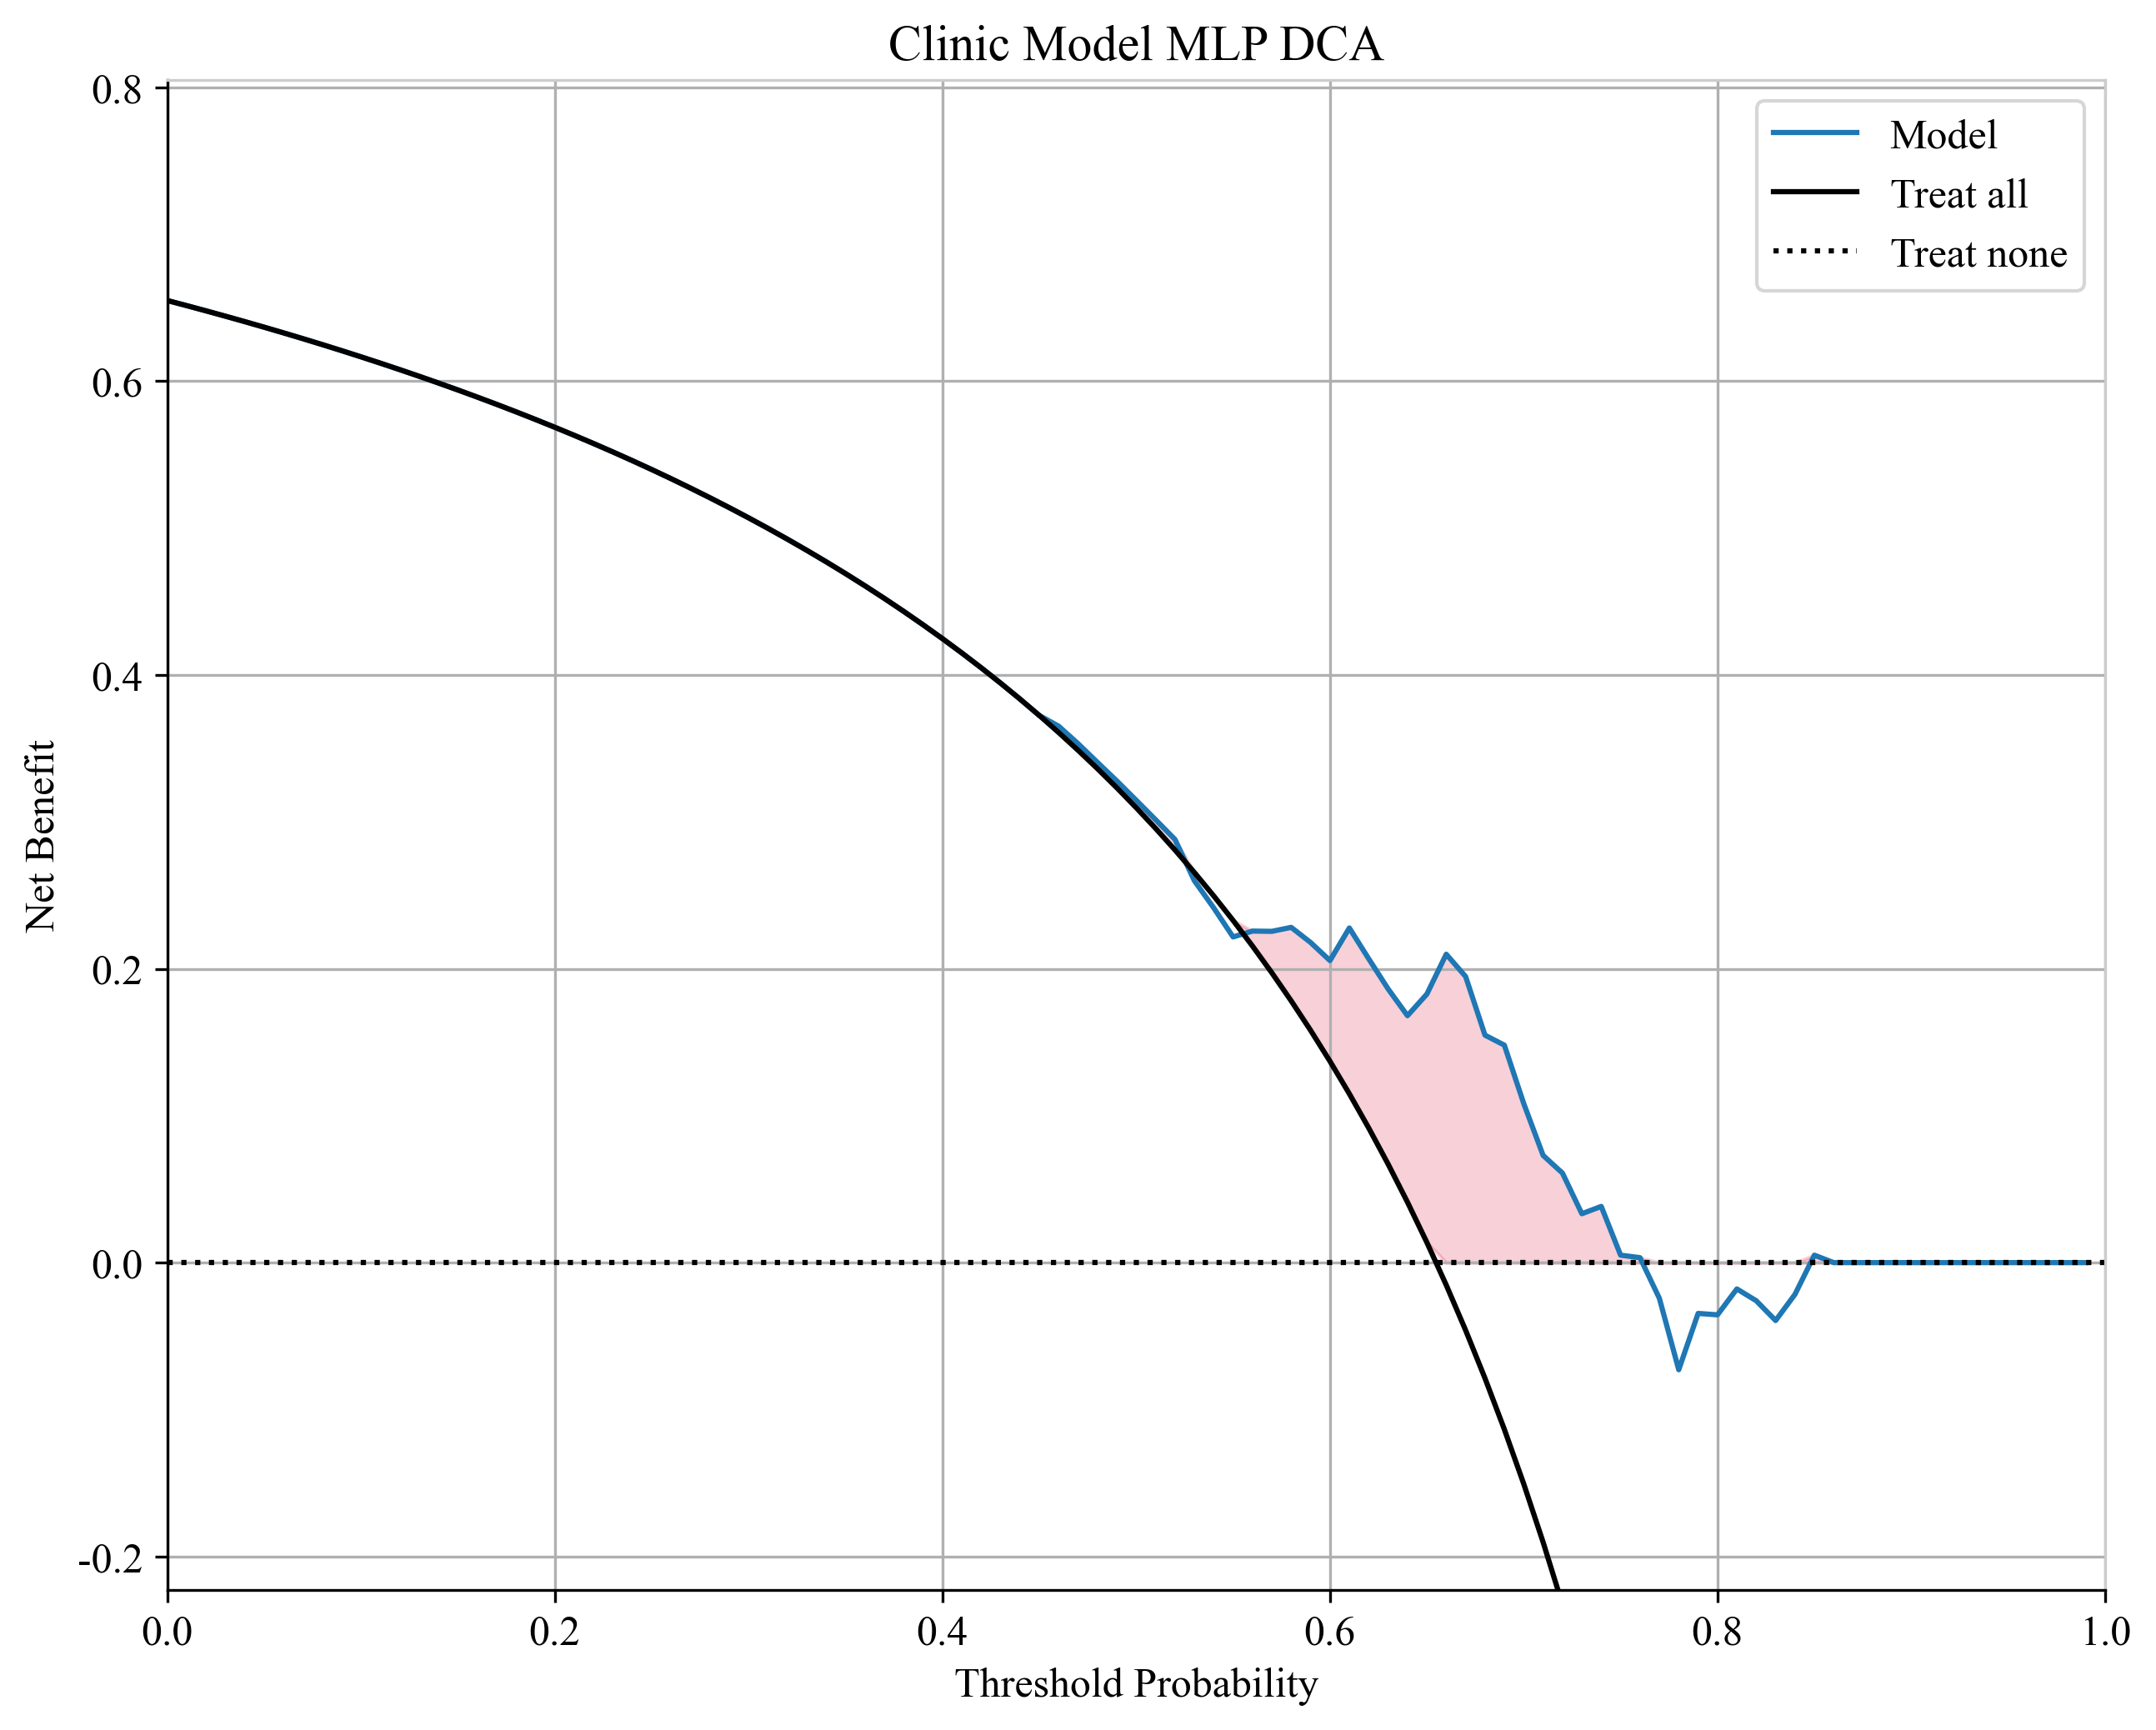

In [15]:
from onekey_algo.custom.components.comp1 import plot_DCA

for pred_score, label in zip(pred_scores, labels):
    pred_test_scores = []
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            okcomp.comp1.plot_DCA(pred_score[sel_model_idx][1][:,1], np.array(y_test_sel[label]),
                                  title=f'Clinic Model {sm} DCA')
            plt.savefig(f'img/Clinic_model_{sm}_dca.svg', bbox_inches = 'tight')

## 绘制混淆矩阵

绘制混淆矩阵，[混淆矩阵解释](https://baike.baidu.com/item/%E6%B7%B7%E6%B7%86%E7%9F%A9%E9%98%B5/10087822?fr=aladdin)
`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

如果需要修改标签到名称的映射，修改`class_mapping={1:'1', 0:'0'}`

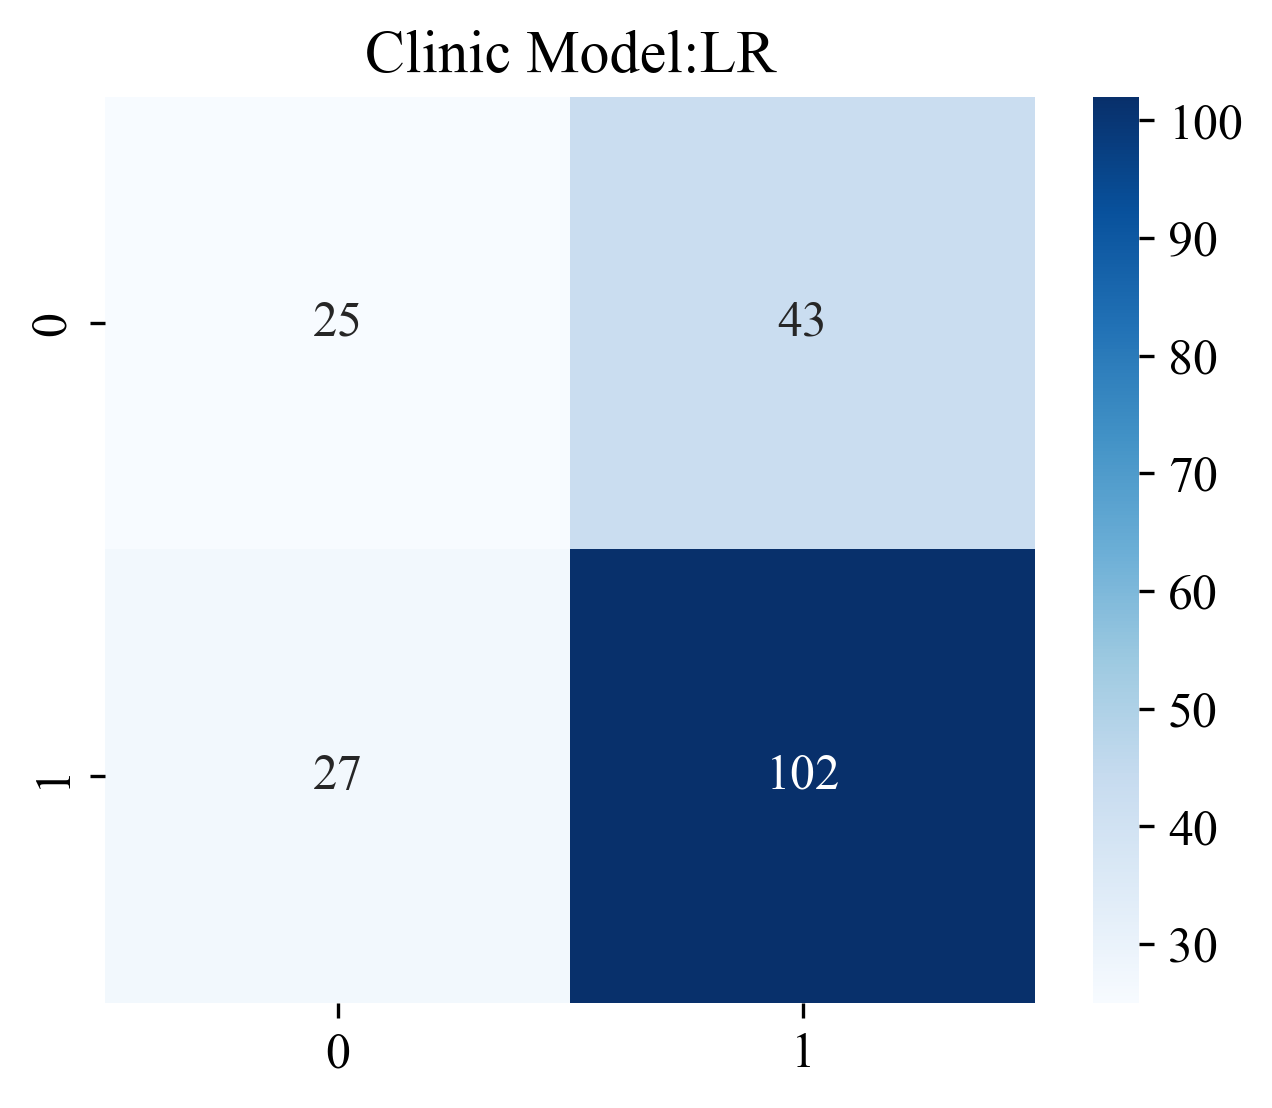

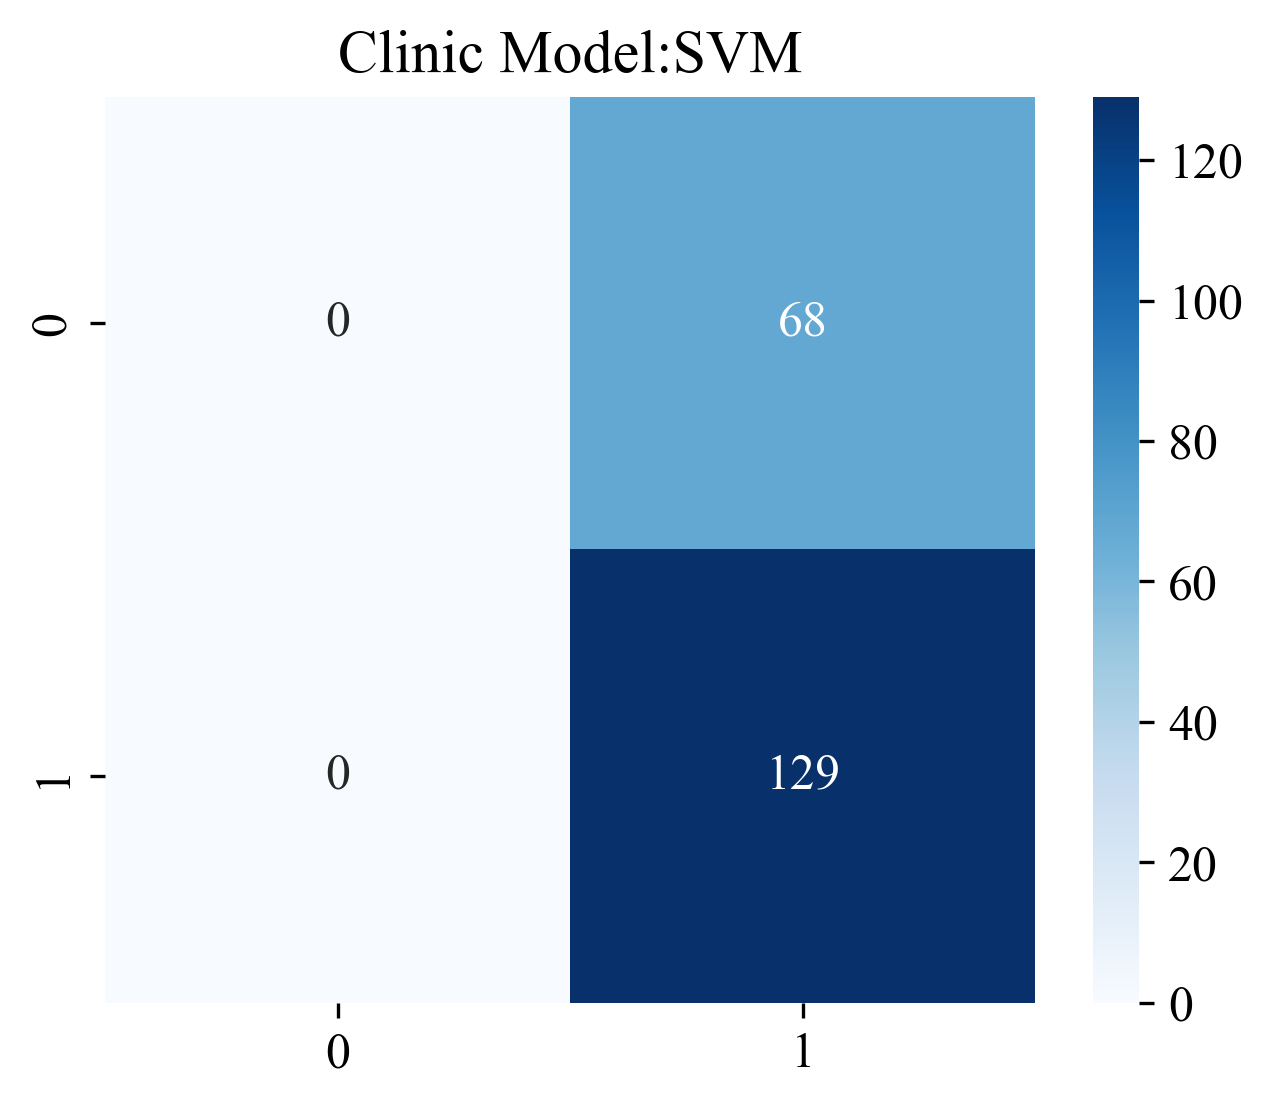

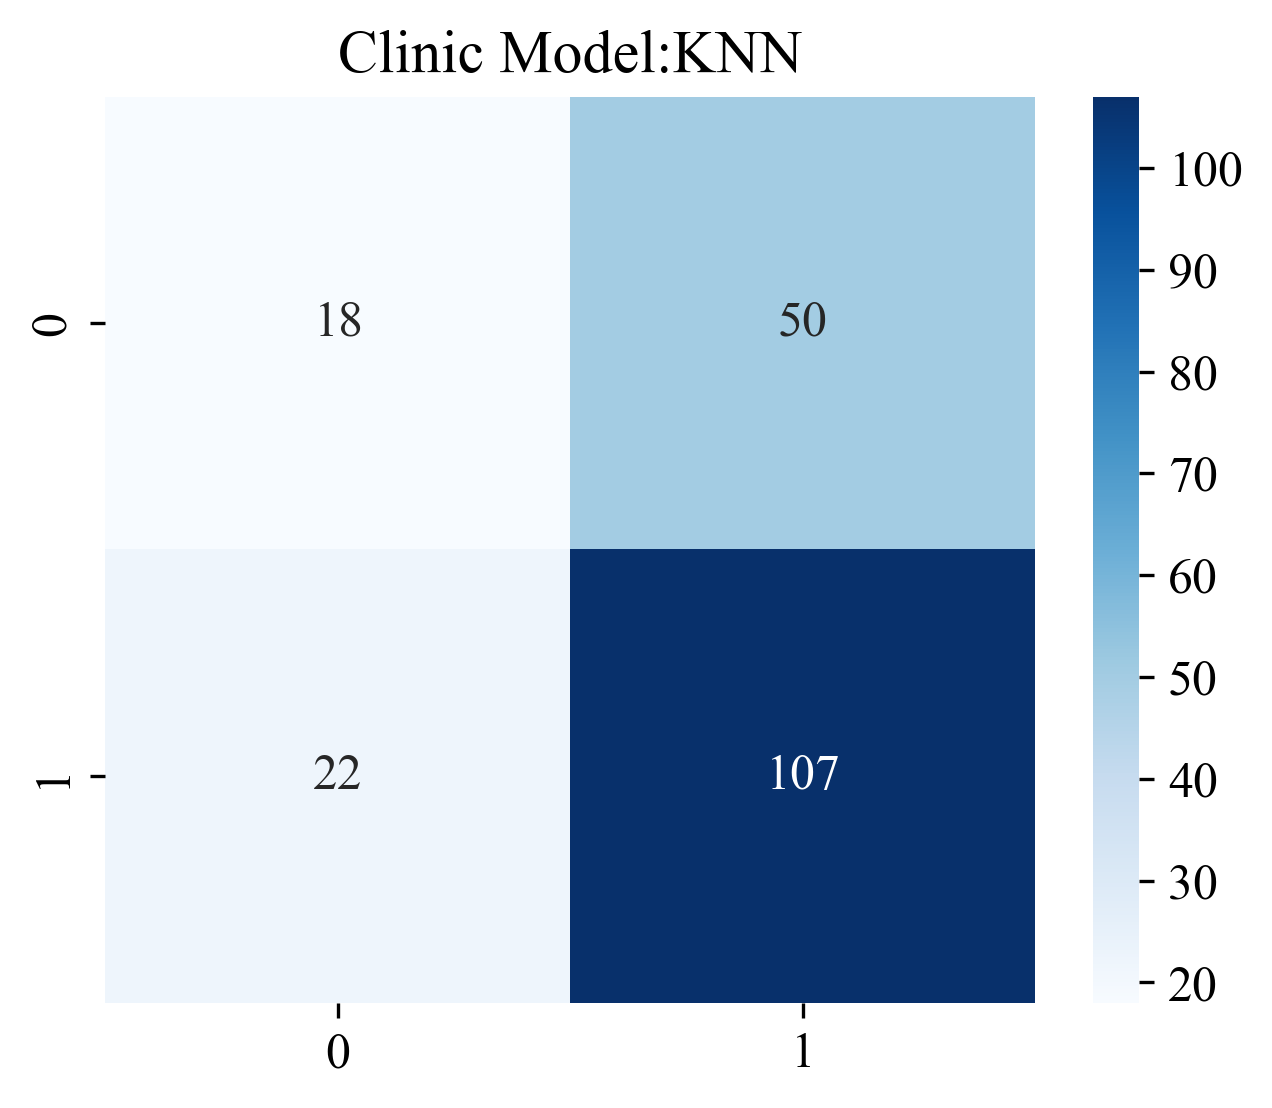

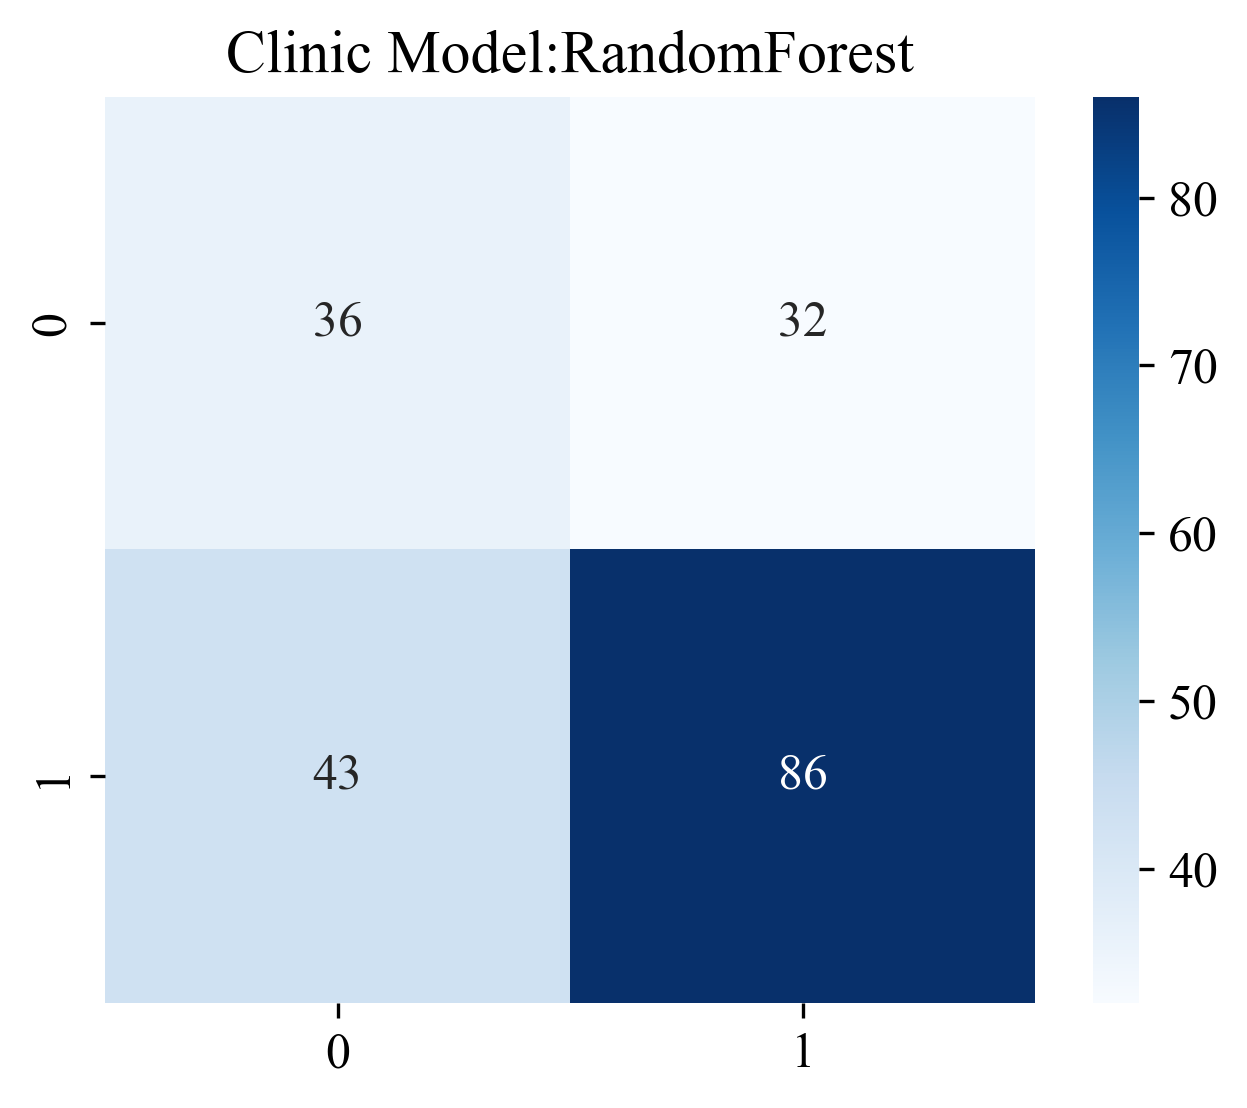

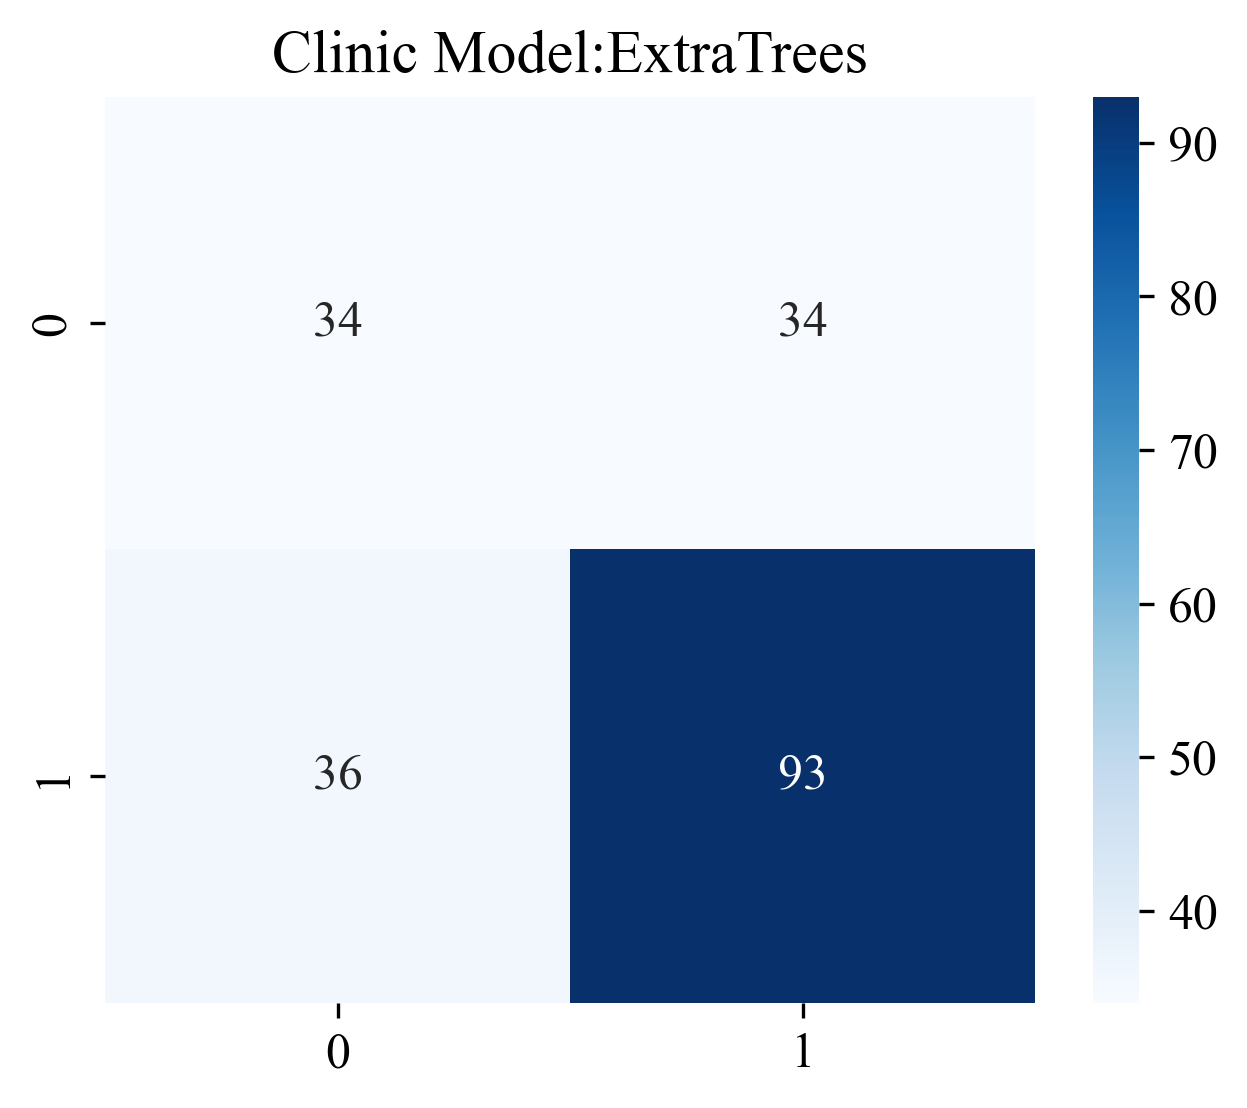

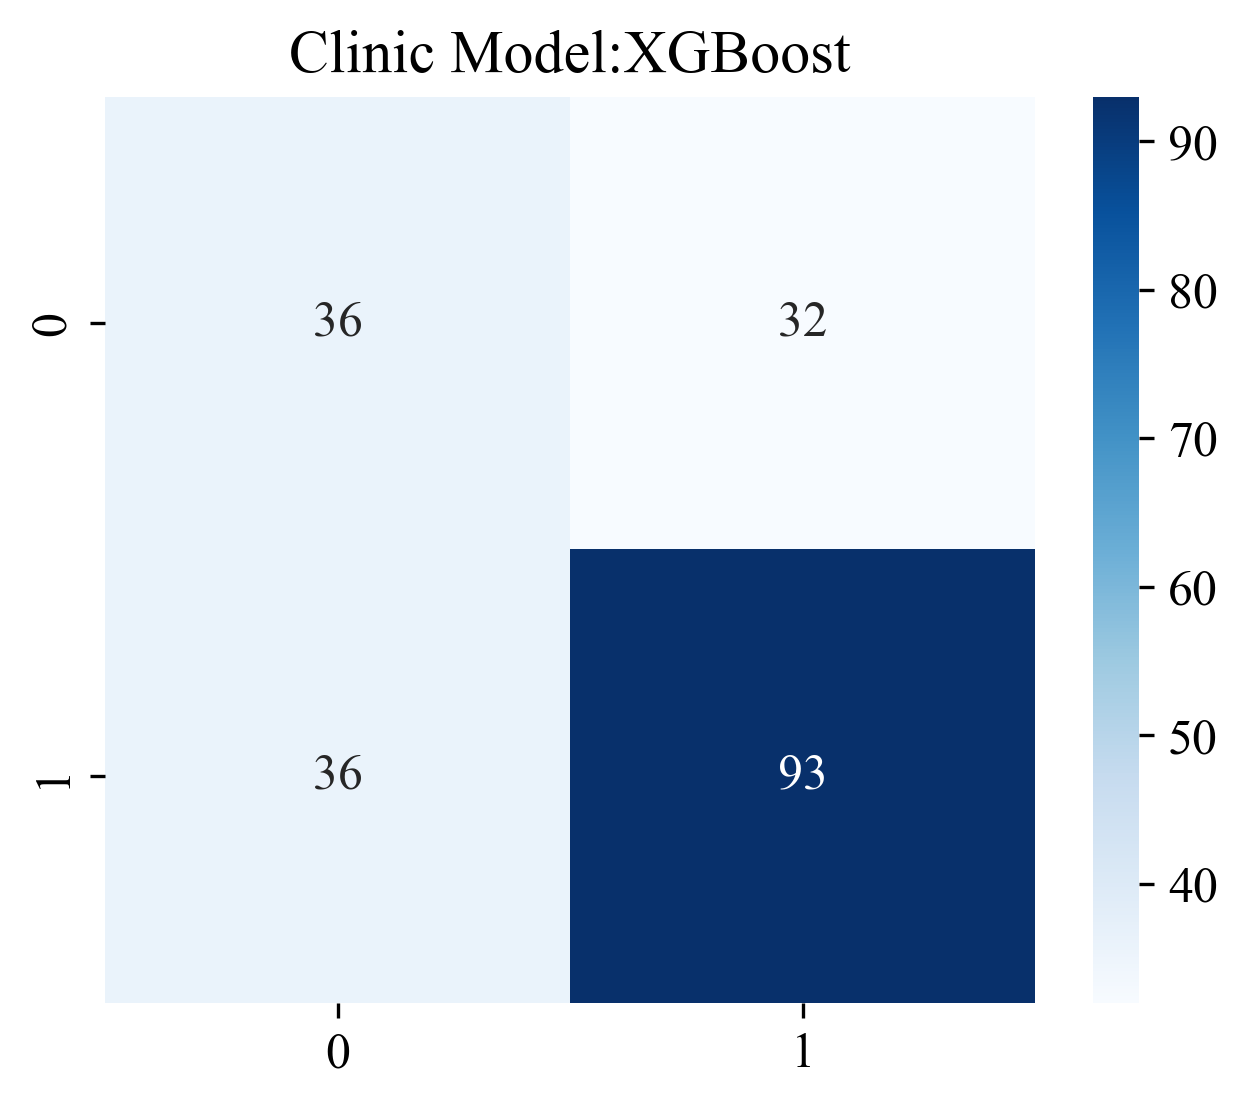

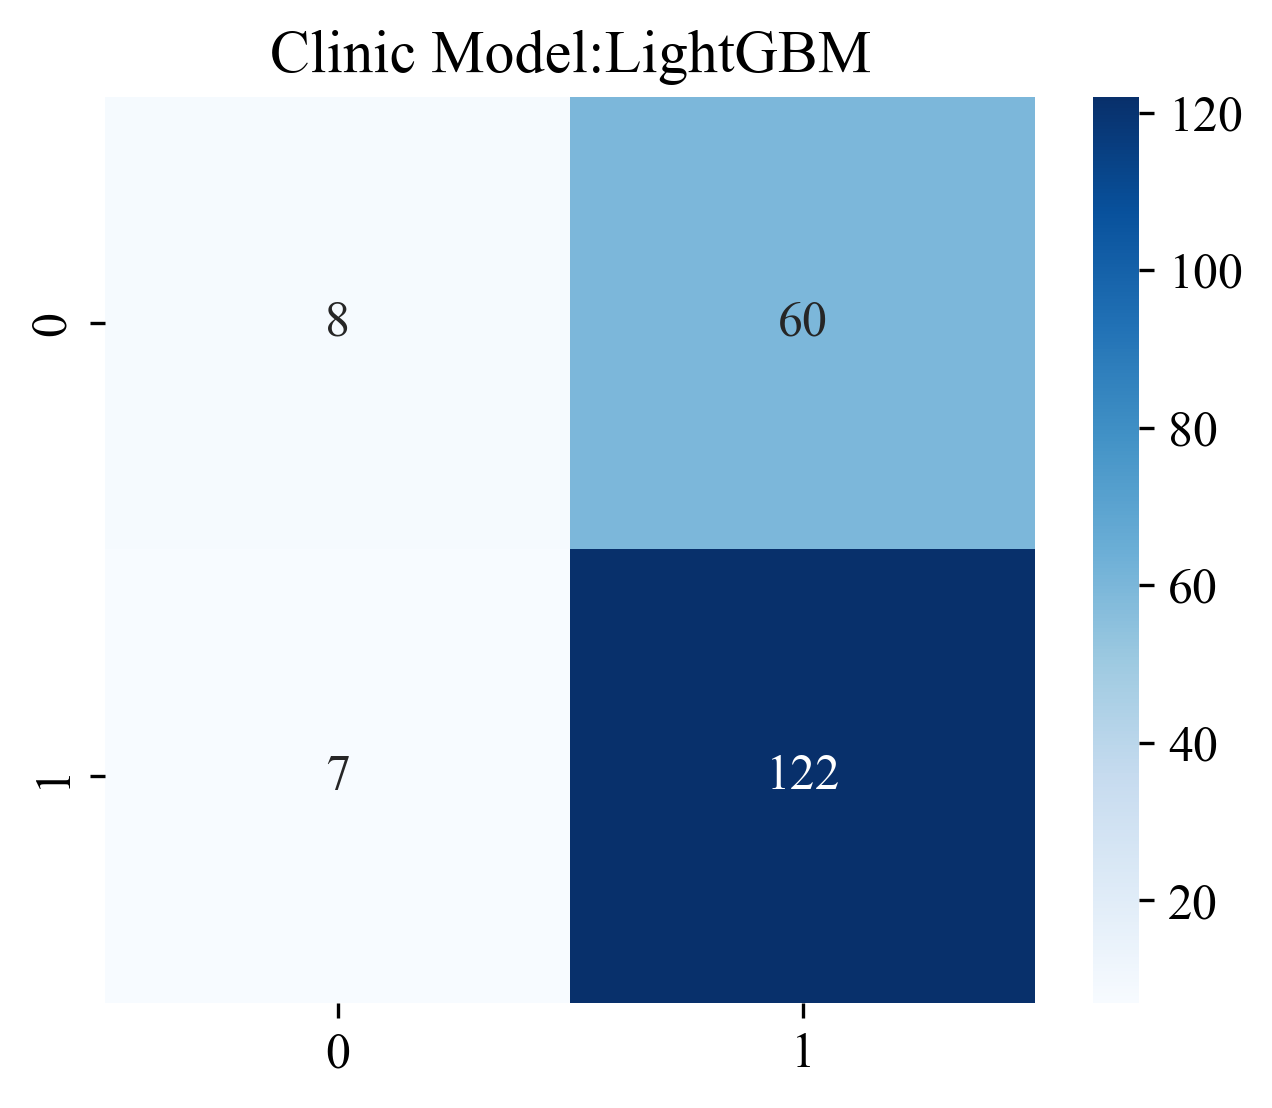

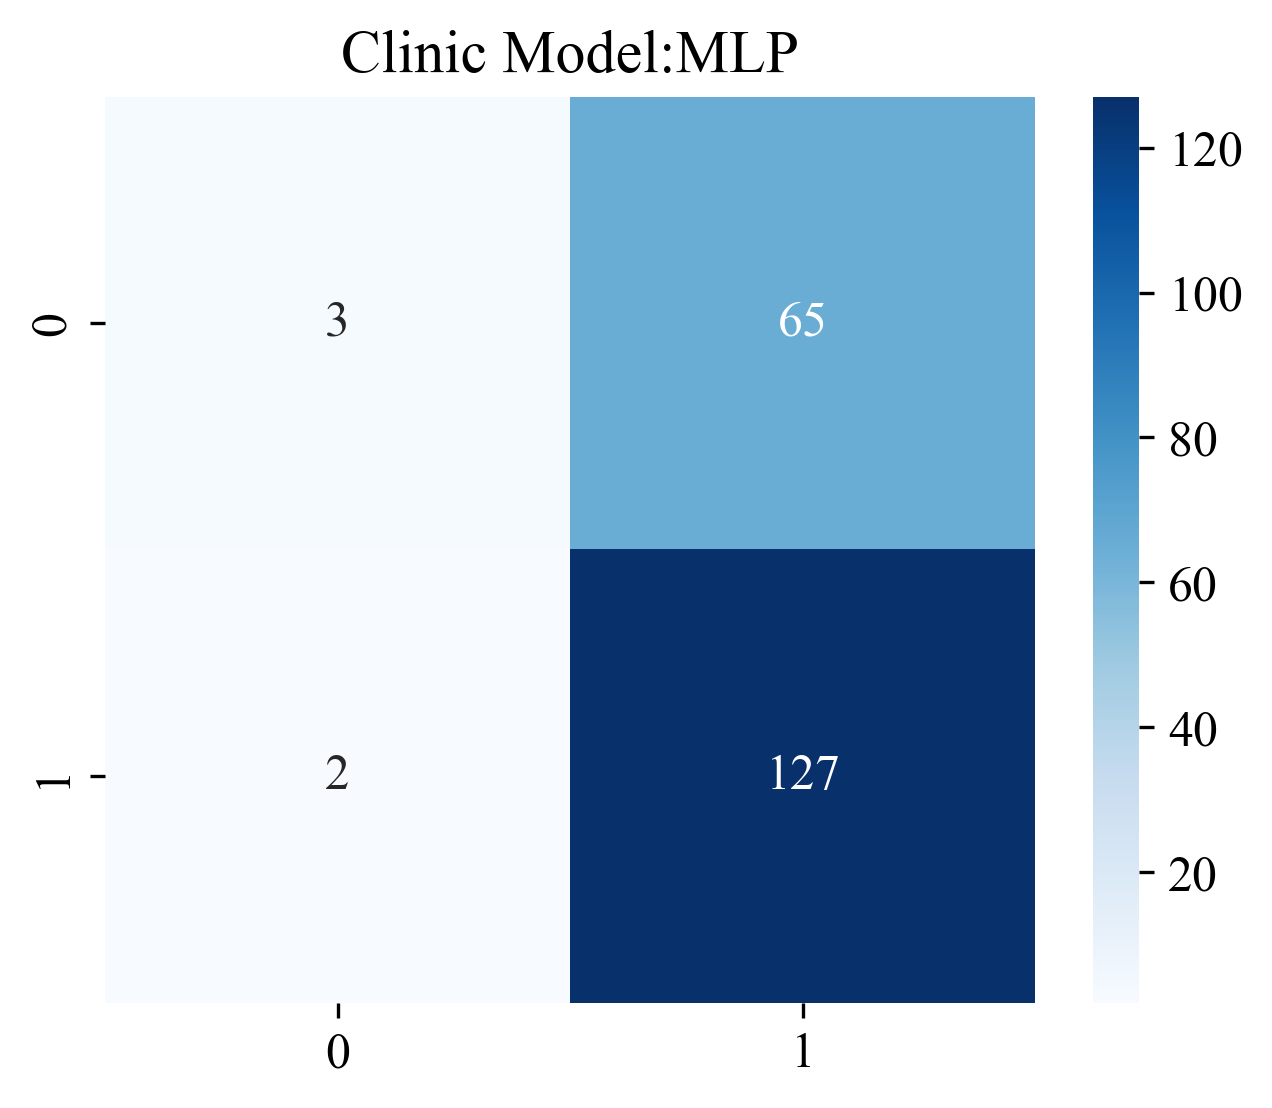

In [16]:
# 设置绘制参数
sel_model = model_names
c_matrix = {}

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
        for idx, label in enumerate(labels):
            cm = okcomp.comp1.calc_confusion_matrix(predictions[idx][sel_model_idx][-1], y_test_sel[label],
#                                                     sel_idx = pred_sel_idx[idx][sel_model_idx],
                                                    class_mapping={1:'1', 0:'0'}, num_classes=2)
            c_matrix[label] = cm
            plt.figure(figsize=(5, 4))
            plt.title(f'Clinic Model:{sm}')
            okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues', fmt=".3g")
            plt.savefig(f'img/Clinic_model_{sm}_cm.svg', bbox_inches = 'tight')

In [17]:
import os
import numpy as np

sel_model = model_names
os.makedirs('results', exist_ok=True)
for idx, label in enumerate(labels):
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            target = targets[idx][sel_model_idx]
            # 预测训练集和测试集数据。
            train_indexes = np.reshape(np.array(train_ids), (-1, 1)).astype(str)
            test_indexes = np.reshape(np.array(test_ids), (-1, 1)).astype(str)
            y_train_pred_scores = target.predict_proba(X_train_sel)
            y_test_pred_scores = target.predict_proba(X_test_sel)
            columns = ['ID'] + [f"{label}-{i}"for i in range(y_test_pred_scores.shape[1])]
            # 保存预测的训练集和测试集结果
            result_train = pd.DataFrame(np.concatenate([train_indexes, y_train_pred_scores], axis=1), columns=columns)
            result_train.to_csv(f'./results/Clinic_{sm}_train.csv', index=False)
            result_test = pd.DataFrame(np.concatenate([test_indexes, y_test_pred_scores], axis=1), columns=columns)
            result_test.to_csv(f'./results/Clinic_{sm}_test.csv', index=False)